# Random Feature Model on Synthetic Dataset

In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
class RF_NonLinear_Model(nn.Module):
    def __init__(self, p, d, o, coef):
        """RF_models
        
        Args:
            p (int): the hidden size
            d (int): the input feature dimension
            o (int): the output dimension
            coef (floatl): the ridge regression penalty coefficient
        """
        super(RF_NonLinear_Model, self).__init__()

        self.fc1 = nn.Linear(d, p, bias=False)
        stdv = 1
        self.fc1.weight.data.normal_(mean=0.0, std = stdv) # Gaussian initialization
        self.fc2 = nn.Linear(p, o, bias=False)
        self.p = p
        self.d = d
        self.o = o 
        self.coef = coef

    def forward(self, x):
        z = 1/np.sqrt(self.d) * F.relu(1/np.sqrt(self.d)* torch.mm(x, self.fc1.weight.data.t()))
        out = np.sqrt(self.d) * torch.mm(self.fc2.weight.data, z.t())
        return out.t()
    def optimize_second_layer(self, x, y):
        N = x.size(0)
        z = 1/np.sqrt(self.d) * F.relu(1/np.sqrt(self.d)* torch.mm(x, self.fc1.weight.data.t()))
        identity = torch.eye(self.p)
        identity = identity.to(x.device)
        beta = torch.mm(z.t(), z) + self.coef*self.p*N/(self.d**2) * identity
        beta = torch.mm(z, torch.inverse(beta))
        a = 1/np.sqrt(self.d) * torch.mm(y.t(), beta) 
        self.fc2.weight = torch.nn.Parameter(a)
        

In [2]:
import queue
class Ensemble_Two_Layer_NN(object):
    def __init__(self, n_classifiers, p, d=784, o=10, coef=1e-1):
        """Ensemble_Two_Layer_NN
        
        Args:
            p (int): the hidden size
            d (int, optional): the input feature dimension
            o (int, optional): the output dimension
            coef (float, optional): the ridge regression penalty coefficient
        """
        self.n_classifiers = n_classifiers
        self.p = p
        self.d = d 
        self.o = o 
        self.coef = coef
        self.learners = queue.LifoQueue(maxsize = self.n_classifiers)
        self.MODEL_TYPE = RF_NonLinear_Model
    def __len__(self):
        return len(self.learners.queue)
    
    def train_one_classifier(self, x, y):
        model = self.MODEL_TYPE(self.p, self.d, self.o, self.coef)
        if x.is_cuda:
            model.cuda()
        rho = 1/self.n_classifiers
        model.optimize_second_layer(x, y)
        self.learners.put([model, rho])
    def put_model_rho(self, model, rho):
        self.learners.put([model, rho])
    def get_init_model(self, cuda=True):
        model = self.MODEL_TYPE(self.p, self.d, self.o, self.coef)
        if cuda:
            model.cuda()
        return model
    def cuda(self):
        if len(self) == 0:
            return 
        else:
            for model, rho in self.learners.queue:
                model.cuda()
            return
    def train(self):
        if len(self)!=0:
            for model, rho in self.learners.queue:
                model.train()
    def eval(self):
        if len(self)!=0:
            for model, rho in self.learners.queue:
                model.eval()
    def forward(self, x):
        Bs = x.size(0)
        if len(self) == 0:
            zeros = torch.zeros(Bs, self.o)
            zeros = zeros.to(x.device)
            return zeros
        else:
            outputs = torch.zeros(Bs, self.o)
            outputs = outputs.to(x.device) 
            for model, rho in self.learners.queue:
                output = model(x)
                outputs += rho*output
            return outputs


In [3]:
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
from typing import Type, Any, Callable, Union, List, Optional

def sample_true_distribution(feature_dim, output_dim, norm = 1):
    beta = np.random.multivariate_normal(np.zeros([feature_dim]), np.eye(feature_dim)/feature_dim, 
        size=(output_dim)).T
    beta = beta/np.linalg.norm(beta, ord=2) * norm # F norm = norm
    beta = beta.astype('float32')
    return beta
def random_draw_samples(beta, feature_dim, output_dim, num_samples):
    data = np.random.multivariate_normal(
        np.zeros([feature_dim])  , 
        np.eye(feature_dim), 
        size=(num_samples)) #X ~ N(0,1)
    data = data.astype('float32')
    targets = np.matmul(data, beta)
    targets = targets.astype('float32')
    return data, targets

def sample_nosie_to_data(data, targets, output_dim, variance):

    noises = np.random.multivariate_normal(
        np.zeros([output_dim]), 
        np.eye(output_dim)* (variance),
        size = (len(targets)))
    noises = noises.astype('float32')
    return data, targets + noises
def sample_dataset(feature_dim, output_dim, F_norm, SNR, num_samples, beta=None):

    if beta is None:
        beta = sample_true_distribution(feature_dim, output_dim, F_norm)
    data, targets = random_draw_samples(beta, feature_dim, output_dim, num_samples)
    if SNR !=0:
        variance = F_norm * SNR
        data, targets = sample_nosie_to_data(data, targets, output_dim, variance)
    return torch.from_numpy(data), torch.from_numpy(targets)
    


In [4]:
import os
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import copy 

# def get_subsample_dataset(trainset, subset):
#     trainsubset = copy.deepcopy(trainset)
#     trainsubset.data = [trainsubset.data[index] for index in subset]
#     trainsubset.targets = [trainsubset.targets[index] for index in subset]
#     return trainsubset
def fix_width_number(width, n_classifiers):
    return max(1, width//n_classifiers)

# Training
def train(net, train_beta, train_size, feature_dim, output_dim, F_norm, SNR):
    net.train()
    train_loss = 0
    correct = 0
    trainset = sample_dataset(feature_dim, output_dim, F_norm, SNR, train_size, beta = train_beta)
    trainset = TensorDataset(*trainset)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=len(trainset), shuffle=True)
    trainloader = iter(trainloader)
    inputs, targets = next(trainloader)
    Bs = inputs.size(0)
    inputs = inputs.reshape(Bs, -1)
    inputs, targets = inputs.cuda(), targets.cuda()
    for _ in range(net.n_classifiers):
        net.train_one_classifier(inputs, targets)
    outputs = net.forward(inputs)
    loss = criterion(outputs, targets)
    train_loss = loss.item() * outputs.numel()
    total = targets.size(0)
    return train_loss/ total

# Test
def test(net, testloader):
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            Bs = inputs.size(0)
            inputs = inputs.reshape(Bs, -1)
            outputs = net.forward(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * outputs.numel()
            total += targets.size(0)
    return test_loss / total

def compute_bias_variance(net, testloader, trial, OUTPUST_SUM, OUTPUTS_SUMNORMSQUARED):
    net.eval()
    bias2 = 0
    variance = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.cuda(), targets.cuda()
            Bs = inputs.size(0)
            inputs = inputs.reshape(Bs, -1)
            outputs = net.forward(inputs)
            OUTPUST_SUM[total:(total + targets.size(0)), :] += outputs
            OUTPUTS_SUMNORMSQUARED[total:total + targets.size(0)] += outputs.norm(dim=1) ** 2.0

            bias2 += (OUTPUST_SUM[total:total + targets.size(0), :] / (trial + 1) - targets).norm() ** 2.0
            variance += OUTPUTS_SUMNORMSQUARED[total:total + targets.size(0)].sum()/(trial + 1) - (OUTPUST_SUM[total:total + targets.size(0), :]/(trial + 1)).norm() ** 2.0
            total += targets.size(0)

    return bias2 / total, variance / total

Define the synthetic dataset:
$y=X\beta + \epsilon_\mu, ||\beta|| = F, \epsilon_{mu} ~ \mathcal{N}(0, 1), SNR = F/\tau$

In [5]:
import pandas as pd
feature_dim = 400
num_classes = 1
SNR = 1
test_size = 10000
beta = sample_true_distribution(feature_dim, num_classes, norm = 1)
#trainset = Synthetic_Dataset(feature_dim=feature_dim, output_dim=1, num_samples=50000, seed=10, SNR = SNR)
testset = sample_dataset(feature_dim, num_classes, F_norm = 1, SNR =0., num_samples=test_size, beta = beta)
testset = TensorDataset(*testset)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=4)
# loss definition
criterion = nn.MSELoss(reduction='mean').cuda()

num_trials = 50
coef = 0.1
N_Ds = [1]
train_sizes = [int(np.around(x*feature_dim)) for x in N_Ds]

P_Ns = 10** np.linspace(-2, 1, 50)

outdir = 'synthetic_coef_{}'.format(coef)
if not os.path.exists(outdir):
    os.makedirs(outdir)

def run_exps_ridge(train_sizes, N_Ds, P_Ns, train_beta, test_size, feature_dim, num_classes, num_trials, coef,
             outdir, save_csv, SNR, K = 1, F_norm= 1):
    df = pd.DataFrame()
    # When training single NN
    for train_size in train_sizes:
        hidden_sizes = P_Ns * train_size
        hidden_sizes = np.unique([int(np.around(x)) for x in hidden_sizes])
        for hidden_size in hidden_sizes:
            TRAIN_LOSS_SUM = 0.0
            TEST_LOSS_SUM = 0.0
            #permute_index = np.random.permutation(len(trainset))
            OUTPUST_SUM = torch.Tensor(test_size, num_classes).zero_().cuda()
            OUTPUTS_SUMNORMSQUARED = torch.Tensor(test_size).zero_().cuda()
            for trial in range(num_trials):
                net = Ensemble_Two_Layer_NN(n_classifiers = K, p = fix_width_number(hidden_size, K), d=feature_dim, o=num_classes, coef=coef)
                net.cuda()
                train_loss = train(net, train_beta, train_size, feature_dim, num_classes, F_norm, SNR)
                test_loss = test(net, testloader)

                TRAIN_LOSS_SUM += train_loss
                TEST_LOSS_SUM += test_loss

                # compute bias and variance
                bias2, variance = compute_bias_variance(net, testloader, trial, OUTPUST_SUM, OUTPUTS_SUMNORMSQUARED)
                variance_unbias = variance * num_trials / (num_trials - 1.0)
                bias2_unbias = TEST_LOSS_SUM / (trial + 1) - variance_unbias
                print('Train size: [{}] hidden size: [{}] trial: {}, train_loss: {:.6f}, test loss: {:.6f}, bias2: {}, variance: {}'.format(
                    train_size, hidden_size,
                    trial, TRAIN_LOSS_SUM / (trial + 1),  TEST_LOSS_SUM / (trial + 1),
                    bias2_unbias, variance_unbias))
                torch.cuda.empty_cache()
            print('#'*50)
            df = df.append({'train_size': train_size, 'hidden_size':hidden_size, 
                            'train_loss': TRAIN_LOSS_SUM / (trial + 1), 
                            'test_loss': TEST_LOSS_SUM / (trial + 1), 
                           'variance': variance_unbias.item(),
                           'bias2': bias2_unbias.item()}, ignore_index=True)
            df.to_csv(os.path.join(outdir, save_csv))
    df.to_csv(os.path.join(outdir, save_csv))


In [7]:
run_exps_ridge(train_sizes, N_Ds, P_Ns, beta, test_size, feature_dim, num_classes, num_trials, coef,
             outdir, 'singleNN_output.csv', SNR= SNR, K = 1, F_norm = 1)

Train size: [400] hidden size: [4] trial: 0, train_loss: 1.873188, test loss: 1.010338, bias2: 1.0103384256362915, variance: -1.2164212345733283e-11
Train size: [400] hidden size: [4] trial: 1, train_loss: 1.872133, test loss: 1.013576, bias2: 1.0052107572555542, variance: 0.008365447632968426
Train size: [400] hidden size: [4] trial: 2, train_loss: 1.933110, test loss: 1.015678, bias2: 1.006278157234192, variance: 0.00939978752285242
Train size: [400] hidden size: [4] trial: 3, train_loss: 1.922342, test loss: 1.019024, bias2: 1.00632643699646, variance: 0.01269767340272665
Train size: [400] hidden size: [4] trial: 4, train_loss: 1.953800, test loss: 1.022892, bias2: 1.008689522743225, variance: 0.014202233403921127
Train size: [400] hidden size: [4] trial: 5, train_loss: 1.954054, test loss: 1.033255, bias2: 1.0084874629974365, variance: 0.02476736716926098
Train size: [400] hidden size: [4] trial: 6, train_loss: 1.957506, test loss: 1.051093, bias2: 1.0047799348831177, variance: 0.0

Train size: [400] hidden size: [5] trial: 6, train_loss: 2.079584, test loss: 1.016961, bias2: 0.9929576516151428, variance: 0.024003690108656883
Train size: [400] hidden size: [5] trial: 7, train_loss: 2.052676, test loss: 1.017833, bias2: 0.9923009872436523, variance: 0.025532495230436325
Train size: [400] hidden size: [5] trial: 8, train_loss: 2.025000, test loss: 1.016222, bias2: 0.9916982054710388, variance: 0.024523913860321045
Train size: [400] hidden size: [5] trial: 9, train_loss: 2.025075, test loss: 1.015962, bias2: 0.9922941327095032, variance: 0.023667994886636734
Train size: [400] hidden size: [5] trial: 10, train_loss: 2.016794, test loss: 1.014742, bias2: 0.9913386106491089, variance: 0.023403288796544075
Train size: [400] hidden size: [5] trial: 11, train_loss: 2.005108, test loss: 1.018529, bias2: 0.9930344820022583, variance: 0.02549406886100769
Train size: [400] hidden size: [5] trial: 12, train_loss: 2.024300, test loss: 1.023911, bias2: 0.9914436936378479, varianc

Train size: [400] hidden size: [6] trial: 12, train_loss: 2.024855, test loss: 1.027278, bias2: 0.9895469546318054, variance: 0.037730872631073
Train size: [400] hidden size: [6] trial: 13, train_loss: 2.008937, test loss: 1.029316, bias2: 0.9904427528381348, variance: 0.03887283056974411
Train size: [400] hidden size: [6] trial: 14, train_loss: 2.007208, test loss: 1.031327, bias2: 0.9913281202316284, variance: 0.039998866617679596
Train size: [400] hidden size: [6] trial: 15, train_loss: 2.012604, test loss: 1.033236, bias2: 0.9917299747467041, variance: 0.041505783796310425
Train size: [400] hidden size: [6] trial: 16, train_loss: 2.019094, test loss: 1.033535, bias2: 0.993302047252655, variance: 0.04023308679461479
Train size: [400] hidden size: [6] trial: 17, train_loss: 2.018945, test loss: 1.033127, bias2: 0.9941985607147217, variance: 0.03892827406525612
Train size: [400] hidden size: [6] trial: 18, train_loss: 2.018125, test loss: 1.033093, bias2: 0.9934868812561035, variance:

Train size: [400] hidden size: [7] trial: 18, train_loss: 1.972172, test loss: 1.028868, bias2: 0.9859683513641357, variance: 0.042899589985609055
Train size: [400] hidden size: [7] trial: 19, train_loss: 1.968317, test loss: 1.031457, bias2: 0.987251341342926, variance: 0.04420595243573189
Train size: [400] hidden size: [7] trial: 20, train_loss: 1.967017, test loss: 1.032222, bias2: 0.9856501817703247, variance: 0.04657182842493057
Train size: [400] hidden size: [7] trial: 21, train_loss: 1.964687, test loss: 1.032731, bias2: 0.9835095405578613, variance: 0.04922172799706459
Train size: [400] hidden size: [7] trial: 22, train_loss: 1.964362, test loss: 1.032705, bias2: 0.9839402437210083, variance: 0.04876480624079704
Train size: [400] hidden size: [7] trial: 23, train_loss: 1.967186, test loss: 1.032927, bias2: 0.9830776453018188, variance: 0.04984918236732483
Train size: [400] hidden size: [7] trial: 24, train_loss: 1.967226, test loss: 1.033948, bias2: 0.983888566493988, variance:

Train size: [400] hidden size: [8] trial: 24, train_loss: 2.013677, test loss: 1.036005, bias2: 0.9855073094367981, variance: 0.050498079508543015
Train size: [400] hidden size: [8] trial: 25, train_loss: 2.006526, test loss: 1.035540, bias2: 0.9853724837303162, variance: 0.0501672625541687
Train size: [400] hidden size: [8] trial: 26, train_loss: 1.999472, test loss: 1.034872, bias2: 0.986007571220398, variance: 0.04886398836970329
Train size: [400] hidden size: [8] trial: 27, train_loss: 1.993694, test loss: 1.035408, bias2: 0.9863241910934448, variance: 0.04908420890569687
Train size: [400] hidden size: [8] trial: 28, train_loss: 1.982124, test loss: 1.036426, bias2: 0.9868281483650208, variance: 0.049597810953855515
Train size: [400] hidden size: [8] trial: 29, train_loss: 1.980796, test loss: 1.035088, bias2: 0.9861201643943787, variance: 0.04896814376115799
Train size: [400] hidden size: [8] trial: 30, train_loss: 1.986524, test loss: 1.036186, bias2: 0.9861196279525757, variance

Train size: [400] hidden size: [9] trial: 30, train_loss: 1.907459, test loss: 1.034934, bias2: 0.9762591123580933, variance: 0.05867454409599304
Train size: [400] hidden size: [9] trial: 31, train_loss: 1.904419, test loss: 1.035461, bias2: 0.9767045974731445, variance: 0.058756232261657715
Train size: [400] hidden size: [9] trial: 32, train_loss: 1.903607, test loss: 1.035378, bias2: 0.9766167402267456, variance: 0.0587616041302681
Train size: [400] hidden size: [9] trial: 33, train_loss: 1.906299, test loss: 1.034642, bias2: 0.9767010807991028, variance: 0.057940881699323654
Train size: [400] hidden size: [9] trial: 34, train_loss: 1.901792, test loss: 1.034016, bias2: 0.9764869213104248, variance: 0.057529594749212265
Train size: [400] hidden size: [9] trial: 35, train_loss: 1.896781, test loss: 1.034591, bias2: 0.9775692224502563, variance: 0.057022083550691605
Train size: [400] hidden size: [9] trial: 36, train_loss: 1.902500, test loss: 1.034895, bias2: 0.978361964225769, varian

Train size: [400] hidden size: [11] trial: 36, train_loss: 1.884030, test loss: 1.040579, bias2: 0.9708268642425537, variance: 0.06975211948156357
Train size: [400] hidden size: [11] trial: 37, train_loss: 1.889652, test loss: 1.040419, bias2: 0.9711500406265259, variance: 0.06926873326301575
Train size: [400] hidden size: [11] trial: 38, train_loss: 1.888124, test loss: 1.041069, bias2: 0.9703706502914429, variance: 0.07069805264472961
Train size: [400] hidden size: [11] trial: 39, train_loss: 1.890907, test loss: 1.040278, bias2: 0.9695018529891968, variance: 0.07077620923519135
Train size: [400] hidden size: [11] trial: 40, train_loss: 1.891036, test loss: 1.041885, bias2: 0.9698728919029236, variance: 0.07201223820447922
Train size: [400] hidden size: [11] trial: 41, train_loss: 1.894873, test loss: 1.042502, bias2: 0.9697483777999878, variance: 0.07275381684303284
Train size: [400] hidden size: [11] trial: 42, train_loss: 1.894110, test loss: 1.042713, bias2: 0.9690598249435425, v

Train size: [400] hidden size: [12] trial: 42, train_loss: 1.953644, test loss: 1.046146, bias2: 0.9635574817657471, variance: 0.08258821070194244
Train size: [400] hidden size: [12] trial: 43, train_loss: 1.948878, test loss: 1.046640, bias2: 0.9642429351806641, variance: 0.0823967456817627
Train size: [400] hidden size: [12] trial: 44, train_loss: 1.945842, test loss: 1.046535, bias2: 0.9641438722610474, variance: 0.08239088207483292
Train size: [400] hidden size: [12] trial: 45, train_loss: 1.947446, test loss: 1.046730, bias2: 0.9635717868804932, variance: 0.08315850794315338
Train size: [400] hidden size: [12] trial: 46, train_loss: 1.943746, test loss: 1.047254, bias2: 0.9638417363166809, variance: 0.08341176807880402
Train size: [400] hidden size: [12] trial: 47, train_loss: 1.940731, test loss: 1.046846, bias2: 0.9638140201568604, variance: 0.08303210139274597
Train size: [400] hidden size: [12] trial: 48, train_loss: 1.943697, test loss: 1.047132, bias2: 0.9633458852767944, va

Train size: [400] hidden size: [14] trial: 48, train_loss: 1.932046, test loss: 1.053715, bias2: 0.9600530862808228, variance: 0.09366229176521301
Train size: [400] hidden size: [14] trial: 49, train_loss: 1.929322, test loss: 1.053264, bias2: 0.960527777671814, variance: 0.09273625910282135
##################################################
Train size: [400] hidden size: [16] trial: 0, train_loss: 1.884857, test loss: 1.121086, bias2: 1.1210864782333374, variance: 0.0
Train size: [400] hidden size: [16] trial: 1, train_loss: 1.938207, test loss: 1.098607, bias2: 1.0409209728240967, variance: 0.05768585950136185
Train size: [400] hidden size: [16] trial: 2, train_loss: 1.891131, test loss: 1.079681, bias2: 1.0047228336334229, variance: 0.07495862245559692
Train size: [400] hidden size: [16] trial: 3, train_loss: 1.898568, test loss: 1.085562, bias2: 0.9878390431404114, variance: 0.09772273153066635
Train size: [400] hidden size: [16] trial: 4, train_loss: 1.912710, test loss: 1.074971,

Train size: [400] hidden size: [19] trial: 4, train_loss: 1.854125, test loss: 1.036020, bias2: 0.9568495154380798, variance: 0.07917026430368423
Train size: [400] hidden size: [19] trial: 5, train_loss: 1.853311, test loss: 1.057545, bias2: 0.9618873596191406, variance: 0.09565773606300354
Train size: [400] hidden size: [19] trial: 6, train_loss: 1.870694, test loss: 1.068073, bias2: 0.966884195804596, variance: 0.10118885338306427
Train size: [400] hidden size: [19] trial: 7, train_loss: 1.876595, test loss: 1.065453, bias2: 0.9638341069221497, variance: 0.10161896795034409
Train size: [400] hidden size: [19] trial: 8, train_loss: 1.880485, test loss: 1.073438, bias2: 0.9525700807571411, variance: 0.12086822092533112
Train size: [400] hidden size: [19] trial: 9, train_loss: 1.869476, test loss: 1.075892, bias2: 0.9530947804450989, variance: 0.12279743701219559
Train size: [400] hidden size: [19] trial: 10, train_loss: 1.865335, test loss: 1.073313, bias2: 0.9530602693557739, variance

Train size: [400] hidden size: [22] trial: 10, train_loss: 1.858650, test loss: 1.093162, bias2: 0.9344061613082886, variance: 0.158756285905838
Train size: [400] hidden size: [22] trial: 11, train_loss: 1.867590, test loss: 1.087667, bias2: 0.9302675724029541, variance: 0.15739916265010834
Train size: [400] hidden size: [22] trial: 12, train_loss: 1.872367, test loss: 1.086814, bias2: 0.9301156997680664, variance: 0.15669788420200348
Train size: [400] hidden size: [22] trial: 13, train_loss: 1.874776, test loss: 1.086406, bias2: 0.9297446012496948, variance: 0.1566615253686905
Train size: [400] hidden size: [22] trial: 14, train_loss: 1.870588, test loss: 1.085118, bias2: 0.9309920072555542, variance: 0.15412546694278717
Train size: [400] hidden size: [22] trial: 15, train_loss: 1.869892, test loss: 1.084688, bias2: 0.9328709244728088, variance: 0.15181690454483032
Train size: [400] hidden size: [22] trial: 16, train_loss: 1.861875, test loss: 1.082258, bias2: 0.9337219595909119, vari

Train size: [400] hidden size: [25] trial: 16, train_loss: 1.771851, test loss: 1.087657, bias2: 0.9414093494415283, variance: 0.1462475210428238
Train size: [400] hidden size: [25] trial: 17, train_loss: 1.781334, test loss: 1.088899, bias2: 0.9424029588699341, variance: 0.14649644494056702
Train size: [400] hidden size: [25] trial: 18, train_loss: 1.784004, test loss: 1.088477, bias2: 0.9412253499031067, variance: 0.1472518891096115
Train size: [400] hidden size: [25] trial: 19, train_loss: 1.779058, test loss: 1.088964, bias2: 0.9402554035186768, variance: 0.14870870113372803
Train size: [400] hidden size: [25] trial: 20, train_loss: 1.778240, test loss: 1.089747, bias2: 0.9404556751251221, variance: 0.14929163455963135
Train size: [400] hidden size: [25] trial: 21, train_loss: 1.776688, test loss: 1.087055, bias2: 0.9390733242034912, variance: 0.14798139035701752
Train size: [400] hidden size: [25] trial: 22, train_loss: 1.778061, test loss: 1.086117, bias2: 0.939354658126831, vari

Train size: [400] hidden size: [29] trial: 22, train_loss: 1.786958, test loss: 1.094095, bias2: 0.9199475049972534, variance: 0.17414721846580505
Train size: [400] hidden size: [29] trial: 23, train_loss: 1.786164, test loss: 1.094142, bias2: 0.9186868667602539, variance: 0.17545495927333832
Train size: [400] hidden size: [29] trial: 24, train_loss: 1.791020, test loss: 1.093864, bias2: 0.917701244354248, variance: 0.1761629432439804
Train size: [400] hidden size: [29] trial: 25, train_loss: 1.786396, test loss: 1.092735, bias2: 0.9145858287811279, variance: 0.17814943194389343
Train size: [400] hidden size: [29] trial: 26, train_loss: 1.787839, test loss: 1.091948, bias2: 0.9130297899246216, variance: 0.17891791462898254
Train size: [400] hidden size: [29] trial: 27, train_loss: 1.783836, test loss: 1.092601, bias2: 0.9129753708839417, variance: 0.17962521314620972
Train size: [400] hidden size: [29] trial: 28, train_loss: 1.779939, test loss: 1.091832, bias2: 0.9133188724517822, var

Train size: [400] hidden size: [33] trial: 28, train_loss: 1.776876, test loss: 1.107170, bias2: 0.8902997970581055, variance: 0.21686992049217224
Train size: [400] hidden size: [33] trial: 29, train_loss: 1.780531, test loss: 1.104539, bias2: 0.8884462118148804, variance: 0.21609283983707428
Train size: [400] hidden size: [33] trial: 30, train_loss: 1.779187, test loss: 1.105706, bias2: 0.8915073871612549, variance: 0.21419896185398102
Train size: [400] hidden size: [33] trial: 31, train_loss: 1.776831, test loss: 1.104280, bias2: 0.8907828330993652, variance: 0.21349692344665527
Train size: [400] hidden size: [33] trial: 32, train_loss: 1.770571, test loss: 1.105691, bias2: 0.8928768038749695, variance: 0.21281439065933228
Train size: [400] hidden size: [33] trial: 33, train_loss: 1.773723, test loss: 1.105346, bias2: 0.8932361006736755, variance: 0.21210938692092896
Train size: [400] hidden size: [33] trial: 34, train_loss: 1.774399, test loss: 1.104928, bias2: 0.8928207755088806, v

Train size: [400] hidden size: [38] trial: 34, train_loss: 1.761004, test loss: 1.133101, bias2: 0.9033804535865784, variance: 0.22972087562084198
Train size: [400] hidden size: [38] trial: 35, train_loss: 1.756439, test loss: 1.131511, bias2: 0.9017601013183594, variance: 0.2297506034374237
Train size: [400] hidden size: [38] trial: 36, train_loss: 1.756934, test loss: 1.131511, bias2: 0.9010517597198486, variance: 0.23045897483825684
Train size: [400] hidden size: [38] trial: 37, train_loss: 1.758108, test loss: 1.132681, bias2: 0.9017865061759949, variance: 0.23089486360549927
Train size: [400] hidden size: [38] trial: 38, train_loss: 1.758084, test loss: 1.132730, bias2: 0.9027853012084961, variance: 0.22994448244571686
Train size: [400] hidden size: [38] trial: 39, train_loss: 1.761229, test loss: 1.134657, bias2: 0.904534637928009, variance: 0.23012273013591766
Train size: [400] hidden size: [38] trial: 40, train_loss: 1.760265, test loss: 1.134767, bias2: 0.9038887619972229, var

Train size: [400] hidden size: [44] trial: 40, train_loss: 1.685425, test loss: 1.151371, bias2: 0.8509425520896912, variance: 0.30042868852615356
Train size: [400] hidden size: [44] trial: 41, train_loss: 1.688442, test loss: 1.152780, bias2: 0.8510324954986572, variance: 0.30174732208251953
Train size: [400] hidden size: [44] trial: 42, train_loss: 1.687701, test loss: 1.150552, bias2: 0.8520292043685913, variance: 0.2985225021839142
Train size: [400] hidden size: [44] trial: 43, train_loss: 1.689880, test loss: 1.149960, bias2: 0.8528539538383484, variance: 0.2971060872077942
Train size: [400] hidden size: [44] trial: 44, train_loss: 1.687283, test loss: 1.148966, bias2: 0.8531256318092346, variance: 0.2958407998085022
Train size: [400] hidden size: [44] trial: 45, train_loss: 1.686688, test loss: 1.149569, bias2: 0.8519578576087952, variance: 0.29761070013046265
Train size: [400] hidden size: [44] trial: 46, train_loss: 1.687675, test loss: 1.148233, bias2: 0.8525961637496948, vari

Train size: [400] hidden size: [51] trial: 46, train_loss: 1.653009, test loss: 1.166349, bias2: 0.8452012538909912, variance: 0.3211474120616913
Train size: [400] hidden size: [51] trial: 47, train_loss: 1.649938, test loss: 1.165705, bias2: 0.8428529500961304, variance: 0.32285168766975403
Train size: [400] hidden size: [51] trial: 48, train_loss: 1.649711, test loss: 1.165932, bias2: 0.841825544834137, variance: 0.3241061568260193
Train size: [400] hidden size: [51] trial: 49, train_loss: 1.645066, test loss: 1.166713, bias2: 0.8420159816741943, variance: 0.32469674944877625
##################################################
Train size: [400] hidden size: [58] trial: 0, train_loss: 1.741705, test loss: 1.140476, bias2: 1.1404756307601929, variance: -2.1409014561157846e-09
Train size: [400] hidden size: [58] trial: 1, train_loss: 1.753433, test loss: 1.114124, bias2: 0.9634265899658203, variance: 0.15069708228111267
Train size: [400] hidden size: [58] trial: 2, train_loss: 1.699725, 

Train size: [400] hidden size: [67] trial: 2, train_loss: 1.708260, test loss: 1.210954, bias2: 0.9206035137176514, variance: 0.2903508245944977
Train size: [400] hidden size: [67] trial: 3, train_loss: 1.682777, test loss: 1.215346, bias2: 0.9032639861106873, variance: 0.3120822310447693
Train size: [400] hidden size: [67] trial: 4, train_loss: 1.672856, test loss: 1.245632, bias2: 0.8842436075210571, variance: 0.3613879382610321
Train size: [400] hidden size: [67] trial: 5, train_loss: 1.639261, test loss: 1.239313, bias2: 0.8729450702667236, variance: 0.3663676083087921
Train size: [400] hidden size: [67] trial: 6, train_loss: 1.604264, test loss: 1.232830, bias2: 0.8559252023696899, variance: 0.37690484523773193
Train size: [400] hidden size: [67] trial: 7, train_loss: 1.609003, test loss: 1.229522, bias2: 0.8485839366912842, variance: 0.3809375762939453
Train size: [400] hidden size: [67] trial: 8, train_loss: 1.593861, test loss: 1.217105, bias2: 0.8377559185028076, variance: 0.3

Train size: [400] hidden size: [77] trial: 8, train_loss: 1.533654, test loss: 1.253233, bias2: 0.8109139204025269, variance: 0.4423189163208008
Train size: [400] hidden size: [77] trial: 9, train_loss: 1.505025, test loss: 1.255682, bias2: 0.7994312047958374, variance: 0.45625102519989014
Train size: [400] hidden size: [77] trial: 10, train_loss: 1.512015, test loss: 1.250915, bias2: 0.7943611145019531, variance: 0.45655420422554016
Train size: [400] hidden size: [77] trial: 11, train_loss: 1.498192, test loss: 1.254920, bias2: 0.7992023825645447, variance: 0.45571738481521606
Train size: [400] hidden size: [77] trial: 12, train_loss: 1.499052, test loss: 1.253081, bias2: 0.7979516983032227, variance: 0.45512938499450684
Train size: [400] hidden size: [77] trial: 13, train_loss: 1.499010, test loss: 1.251347, bias2: 0.7973570823669434, variance: 0.45399031043052673
Train size: [400] hidden size: [77] trial: 14, train_loss: 1.499654, test loss: 1.244966, bias2: 0.7934814095497131, vari

Train size: [400] hidden size: [89] trial: 14, train_loss: 1.437592, test loss: 1.265379, bias2: 0.7757608294487, variance: 0.48961836099624634
Train size: [400] hidden size: [89] trial: 15, train_loss: 1.435322, test loss: 1.266644, bias2: 0.7740836143493652, variance: 0.4925605058670044
Train size: [400] hidden size: [89] trial: 16, train_loss: 1.440134, test loss: 1.266984, bias2: 0.7708311080932617, variance: 0.49615320563316345
Train size: [400] hidden size: [89] trial: 17, train_loss: 1.435887, test loss: 1.273751, bias2: 0.7744721174240112, variance: 0.49927935004234314
Train size: [400] hidden size: [89] trial: 18, train_loss: 1.443808, test loss: 1.268881, bias2: 0.7748913764953613, variance: 0.4939897060394287
Train size: [400] hidden size: [89] trial: 19, train_loss: 1.446684, test loss: 1.262296, bias2: 0.7684204578399658, variance: 0.4938758313655853
Train size: [400] hidden size: [89] trial: 20, train_loss: 1.446054, test loss: 1.266003, bias2: 0.7727447748184204, varianc

Train size: [400] hidden size: [102] trial: 20, train_loss: 1.368824, test loss: 1.318578, bias2: 0.7005598545074463, variance: 0.6180177927017212
Train size: [400] hidden size: [102] trial: 21, train_loss: 1.366121, test loss: 1.322016, bias2: 0.6985630989074707, variance: 0.6234530210494995
Train size: [400] hidden size: [102] trial: 22, train_loss: 1.367647, test loss: 1.325290, bias2: 0.6960392594337463, variance: 0.6292509436607361
Train size: [400] hidden size: [102] trial: 23, train_loss: 1.366996, test loss: 1.325680, bias2: 0.6971191763877869, variance: 0.6285613179206848
Train size: [400] hidden size: [102] trial: 24, train_loss: 1.373097, test loss: 1.322742, bias2: 0.6986117362976074, variance: 0.6241302490234375
Train size: [400] hidden size: [102] trial: 25, train_loss: 1.378122, test loss: 1.325970, bias2: 0.704435408115387, variance: 0.6215344071388245
Train size: [400] hidden size: [102] trial: 26, train_loss: 1.383158, test loss: 1.329475, bias2: 0.7056074738502502, v

Train size: [400] hidden size: [118] trial: 26, train_loss: 1.263275, test loss: 1.367143, bias2: 0.7048063278198242, variance: 0.662337064743042
Train size: [400] hidden size: [118] trial: 27, train_loss: 1.266381, test loss: 1.371462, bias2: 0.7045270800590515, variance: 0.6669345498085022
Train size: [400] hidden size: [118] trial: 28, train_loss: 1.269774, test loss: 1.370502, bias2: 0.7038813829421997, variance: 0.6666209697723389
Train size: [400] hidden size: [118] trial: 29, train_loss: 1.267805, test loss: 1.369720, bias2: 0.7028586864471436, variance: 0.6668610572814941
Train size: [400] hidden size: [118] trial: 30, train_loss: 1.274634, test loss: 1.370675, bias2: 0.7002062797546387, variance: 0.6704686880111694
Train size: [400] hidden size: [118] trial: 31, train_loss: 1.276248, test loss: 1.367481, bias2: 0.6996148824691772, variance: 0.6678663492202759
Train size: [400] hidden size: [118] trial: 32, train_loss: 1.273414, test loss: 1.366652, bias2: 0.6968916058540344, v

Train size: [400] hidden size: [136] trial: 32, train_loss: 1.221127, test loss: 1.390703, bias2: 0.644737184047699, variance: 0.7459655404090881
Train size: [400] hidden size: [136] trial: 33, train_loss: 1.218077, test loss: 1.392886, bias2: 0.6459167003631592, variance: 0.7469691038131714
Train size: [400] hidden size: [136] trial: 34, train_loss: 1.215215, test loss: 1.393424, bias2: 0.6464259624481201, variance: 0.7469979524612427
Train size: [400] hidden size: [136] trial: 35, train_loss: 1.212006, test loss: 1.393140, bias2: 0.643906831741333, variance: 0.7492334842681885
Train size: [400] hidden size: [136] trial: 36, train_loss: 1.209934, test loss: 1.389196, bias2: 0.6423226594924927, variance: 0.7468734979629517
Train size: [400] hidden size: [136] trial: 37, train_loss: 1.209726, test loss: 1.387696, bias2: 0.6414347290992737, variance: 0.7462612986564636
Train size: [400] hidden size: [136] trial: 38, train_loss: 1.211283, test loss: 1.386015, bias2: 0.640145480632782, var

Train size: [400] hidden size: [156] trial: 38, train_loss: 1.101104, test loss: 1.421942, bias2: 0.6149997711181641, variance: 0.8069418668746948
Train size: [400] hidden size: [156] trial: 39, train_loss: 1.102952, test loss: 1.419952, bias2: 0.613219678401947, variance: 0.806732714176178
Train size: [400] hidden size: [156] trial: 40, train_loss: 1.100505, test loss: 1.417715, bias2: 0.6099201440811157, variance: 0.8077946901321411
Train size: [400] hidden size: [156] trial: 41, train_loss: 1.097827, test loss: 1.420416, bias2: 0.609295666217804, variance: 0.8111204504966736
Train size: [400] hidden size: [156] trial: 42, train_loss: 1.096292, test loss: 1.418526, bias2: 0.6094858050346375, variance: 0.8090406060218811
Train size: [400] hidden size: [156] trial: 43, train_loss: 1.100014, test loss: 1.416580, bias2: 0.6084858775138855, variance: 0.8080945611000061
Train size: [400] hidden size: [156] trial: 44, train_loss: 1.099482, test loss: 1.411047, bias2: 0.6075415015220642, var

Train size: [400] hidden size: [180] trial: 44, train_loss: 0.988374, test loss: 1.413833, bias2: 0.5952622890472412, variance: 0.8185707330703735
Train size: [400] hidden size: [180] trial: 45, train_loss: 0.990539, test loss: 1.413820, bias2: 0.5935812592506409, variance: 0.8202390074729919
Train size: [400] hidden size: [180] trial: 46, train_loss: 0.991324, test loss: 1.414824, bias2: 0.5934234261512756, variance: 0.8214003443717957
Train size: [400] hidden size: [180] trial: 47, train_loss: 0.991109, test loss: 1.416279, bias2: 0.5929503440856934, variance: 0.8233284950256348
Train size: [400] hidden size: [180] trial: 48, train_loss: 0.992574, test loss: 1.413153, bias2: 0.5906087756156921, variance: 0.8225446343421936
Train size: [400] hidden size: [180] trial: 49, train_loss: 0.992005, test loss: 1.412547, bias2: 0.5905547738075256, variance: 0.8219920992851257
##################################################
Train size: [400] hidden size: [207] trial: 0, train_loss: 0.901819

Train size: [400] hidden size: [239] trial: 0, train_loss: 0.854961, test loss: 1.607034, bias2: 1.6070342063903809, variance: -4.6710577628061856e-09
Train size: [400] hidden size: [239] trial: 1, train_loss: 0.797583, test loss: 1.508613, bias2: 1.0258750915527344, variance: 0.4827379882335663
Train size: [400] hidden size: [239] trial: 2, train_loss: 0.806089, test loss: 1.521725, bias2: 0.8392072916030884, variance: 0.6825175285339355
Train size: [400] hidden size: [239] trial: 3, train_loss: 0.784885, test loss: 1.523511, bias2: 0.7493507266044617, variance: 0.7741600871086121
Train size: [400] hidden size: [239] trial: 4, train_loss: 0.801821, test loss: 1.501518, bias2: 0.702480137348175, variance: 0.799037754535675
Train size: [400] hidden size: [239] trial: 5, train_loss: 0.791862, test loss: 1.489814, bias2: 0.6701051592826843, variance: 0.8197090029716492
Train size: [400] hidden size: [239] trial: 6, train_loss: 0.780267, test loss: 1.492346, bias2: 0.6526858806610107, vari

Train size: [400] hidden size: [275] trial: 6, train_loss: 0.733911, test loss: 1.473861, bias2: 0.610905647277832, variance: 0.86295485496521
Train size: [400] hidden size: [275] trial: 7, train_loss: 0.723819, test loss: 1.464278, bias2: 0.5930711627006531, variance: 0.8712067008018494
Train size: [400] hidden size: [275] trial: 8, train_loss: 0.715991, test loss: 1.472652, bias2: 0.5799276828765869, variance: 0.8927243947982788
Train size: [400] hidden size: [275] trial: 9, train_loss: 0.712376, test loss: 1.463172, bias2: 0.5598878264427185, variance: 0.90328449010849
Train size: [400] hidden size: [275] trial: 10, train_loss: 0.715969, test loss: 1.449883, bias2: 0.5555017590522766, variance: 0.8943814635276794
Train size: [400] hidden size: [275] trial: 11, train_loss: 0.718391, test loss: 1.438546, bias2: 0.5498849153518677, variance: 0.8886607885360718
Train size: [400] hidden size: [275] trial: 12, train_loss: 0.721567, test loss: 1.429862, bias2: 0.5434077978134155, variance:

Train size: [400] hidden size: [316] trial: 12, train_loss: 0.635111, test loss: 1.360910, bias2: 0.5152584910392761, variance: 0.8456510901451111
Train size: [400] hidden size: [316] trial: 13, train_loss: 0.632015, test loss: 1.364405, bias2: 0.5128983855247498, variance: 0.8515062928199768
Train size: [400] hidden size: [316] trial: 14, train_loss: 0.629542, test loss: 1.360649, bias2: 0.5045483708381653, variance: 0.8561007380485535
Train size: [400] hidden size: [316] trial: 15, train_loss: 0.623064, test loss: 1.359359, bias2: 0.5039954781532288, variance: 0.8553633093833923
Train size: [400] hidden size: [316] trial: 16, train_loss: 0.625809, test loss: 1.360355, bias2: 0.499747633934021, variance: 0.8606072664260864
Train size: [400] hidden size: [316] trial: 17, train_loss: 0.624726, test loss: 1.354639, bias2: 0.49368607997894287, variance: 0.8609530925750732
Train size: [400] hidden size: [316] trial: 18, train_loss: 0.630692, test loss: 1.355723, bias2: 0.4887639284133911, 

Train size: [400] hidden size: [364] trial: 18, train_loss: 0.522419, test loss: 1.324242, bias2: 0.4757152199745178, variance: 0.8485265374183655
Train size: [400] hidden size: [364] trial: 19, train_loss: 0.520560, test loss: 1.320931, bias2: 0.47721409797668457, variance: 0.8437172174453735
Train size: [400] hidden size: [364] trial: 20, train_loss: 0.518724, test loss: 1.321330, bias2: 0.47590208053588867, variance: 0.8454279899597168
Train size: [400] hidden size: [364] trial: 21, train_loss: 0.519017, test loss: 1.321026, bias2: 0.47779399156570435, variance: 0.8432318568229675
Train size: [400] hidden size: [364] trial: 22, train_loss: 0.518447, test loss: 1.318253, bias2: 0.47467517852783203, variance: 0.8435782194137573
Train size: [400] hidden size: [364] trial: 23, train_loss: 0.521799, test loss: 1.317934, bias2: 0.4701622724533081, variance: 0.8477715253829956
Train size: [400] hidden size: [364] trial: 24, train_loss: 0.523989, test loss: 1.323357, bias2: 0.47078216075897

Train size: [400] hidden size: [419] trial: 24, train_loss: 0.447175, test loss: 1.238413, bias2: 0.4313451051712036, variance: 0.8070676326751709
Train size: [400] hidden size: [419] trial: 25, train_loss: 0.448903, test loss: 1.238625, bias2: 0.43050307035446167, variance: 0.8081217408180237
Train size: [400] hidden size: [419] trial: 26, train_loss: 0.450122, test loss: 1.242286, bias2: 0.4337993860244751, variance: 0.808487057685852
Train size: [400] hidden size: [419] trial: 27, train_loss: 0.450391, test loss: 1.237423, bias2: 0.4320579171180725, variance: 0.8053645491600037
Train size: [400] hidden size: [419] trial: 28, train_loss: 0.452762, test loss: 1.238556, bias2: 0.43093574047088623, variance: 0.8076198101043701
Train size: [400] hidden size: [419] trial: 29, train_loss: 0.452448, test loss: 1.235193, bias2: 0.42869096994400024, variance: 0.8065020442008972
Train size: [400] hidden size: [419] trial: 30, train_loss: 0.451003, test loss: 1.233996, bias2: 0.428851842880249,

Train size: [400] hidden size: [483] trial: 30, train_loss: 0.414228, test loss: 1.198732, bias2: 0.42828208208084106, variance: 0.7704499363899231
Train size: [400] hidden size: [483] trial: 31, train_loss: 0.414478, test loss: 1.199428, bias2: 0.42852920293807983, variance: 0.7708987593650818
Train size: [400] hidden size: [483] trial: 32, train_loss: 0.415000, test loss: 1.199833, bias2: 0.4278165102005005, variance: 0.7720170021057129
Train size: [400] hidden size: [483] trial: 33, train_loss: 0.414867, test loss: 1.197590, bias2: 0.4251387119293213, variance: 0.7724510431289673
Train size: [400] hidden size: [483] trial: 34, train_loss: 0.414333, test loss: 1.196517, bias2: 0.42315590381622314, variance: 0.7733607292175293
Train size: [400] hidden size: [483] trial: 35, train_loss: 0.413147, test loss: 1.197039, bias2: 0.42292970418930054, variance: 0.7741089463233948
Train size: [400] hidden size: [483] trial: 36, train_loss: 0.412688, test loss: 1.194763, bias2: 0.41887247562408

Train size: [400] hidden size: [556] trial: 36, train_loss: 0.350339, test loss: 1.113602, bias2: 0.4113098382949829, variance: 0.7022920846939087
Train size: [400] hidden size: [556] trial: 37, train_loss: 0.350506, test loss: 1.115541, bias2: 0.4090615510940552, variance: 0.7064799070358276
Train size: [400] hidden size: [556] trial: 38, train_loss: 0.348440, test loss: 1.112117, bias2: 0.40783822536468506, variance: 0.7042785882949829
Train size: [400] hidden size: [556] trial: 39, train_loss: 0.347218, test loss: 1.111455, bias2: 0.40790867805480957, variance: 0.7035466432571411
Train size: [400] hidden size: [556] trial: 40, train_loss: 0.348427, test loss: 1.113199, bias2: 0.40586739778518677, variance: 0.7073318362236023
Train size: [400] hidden size: [556] trial: 41, train_loss: 0.349069, test loss: 1.112922, bias2: 0.40562134981155396, variance: 0.7073009610176086
Train size: [400] hidden size: [556] trial: 42, train_loss: 0.348444, test loss: 1.110395, bias2: 0.40264874696731

Train size: [400] hidden size: [640] trial: 42, train_loss: 0.321804, test loss: 1.051407, bias2: 0.3840486407279968, variance: 0.6673586964607239
Train size: [400] hidden size: [640] trial: 43, train_loss: 0.320594, test loss: 1.053688, bias2: 0.38574081659317017, variance: 0.667946994304657
Train size: [400] hidden size: [640] trial: 44, train_loss: 0.321333, test loss: 1.054028, bias2: 0.3846902847290039, variance: 0.6693381071090698
Train size: [400] hidden size: [640] trial: 45, train_loss: 0.322220, test loss: 1.055548, bias2: 0.38439369201660156, variance: 0.6711547374725342
Train size: [400] hidden size: [640] trial: 46, train_loss: 0.321809, test loss: 1.056235, bias2: 0.3848285675048828, variance: 0.6714062690734863
Train size: [400] hidden size: [640] trial: 47, train_loss: 0.320933, test loss: 1.055610, bias2: 0.3830574154853821, variance: 0.6725530028343201
Train size: [400] hidden size: [640] trial: 48, train_loss: 0.319855, test loss: 1.054715, bias2: 0.38345932960510254

Train size: [400] hidden size: [737] trial: 48, train_loss: 0.292672, test loss: 1.005354, bias2: 0.37945789098739624, variance: 0.625896155834198
Train size: [400] hidden size: [737] trial: 49, train_loss: 0.293279, test loss: 1.004691, bias2: 0.37922215461730957, variance: 0.6254687309265137
##################################################
Train size: [400] hidden size: [848] trial: 0, train_loss: 0.232427, test loss: 0.937516, bias2: 0.9375160932540894, variance: 3.5032932110823367e-09
Train size: [400] hidden size: [848] trial: 1, train_loss: 0.245556, test loss: 0.923757, bias2: 0.6318141222000122, variance: 0.2919425368309021
Train size: [400] hidden size: [848] trial: 2, train_loss: 0.258588, test loss: 0.926405, bias2: 0.5315507650375366, variance: 0.39485403895378113
Train size: [400] hidden size: [848] trial: 3, train_loss: 0.264707, test loss: 0.926824, bias2: 0.4906887710094452, variance: 0.43613556027412415
Train size: [400] hidden size: [848] trial: 4, train_loss: 0.275

Train size: [400] hidden size: [977] trial: 3, train_loss: 0.243698, test loss: 0.930776, bias2: 0.5074639916419983, variance: 0.4233121871948242
Train size: [400] hidden size: [977] trial: 4, train_loss: 0.234165, test loss: 0.923813, bias2: 0.47791945934295654, variance: 0.44589340686798096
Train size: [400] hidden size: [977] trial: 5, train_loss: 0.237839, test loss: 0.911514, bias2: 0.45220792293548584, variance: 0.4593057632446289
Train size: [400] hidden size: [977] trial: 6, train_loss: 0.243524, test loss: 0.921111, bias2: 0.4479365050792694, variance: 0.47317472100257874
Train size: [400] hidden size: [977] trial: 7, train_loss: 0.248782, test loss: 0.910746, bias2: 0.4277789890766144, variance: 0.48296669125556946
Train size: [400] hidden size: [977] trial: 8, train_loss: 0.246479, test loss: 0.906717, bias2: 0.4181915521621704, variance: 0.4885255694389343
Train size: [400] hidden size: [977] trial: 9, train_loss: 0.247520, test loss: 0.905060, bias2: 0.4132869839668274, va

Train size: [400] hidden size: [1125] trial: 9, train_loss: 0.232394, test loss: 0.872328, bias2: 0.386570543050766, variance: 0.4857575595378876
Train size: [400] hidden size: [1125] trial: 10, train_loss: 0.236262, test loss: 0.879058, bias2: 0.3813437819480896, variance: 0.49771374464035034
Train size: [400] hidden size: [1125] trial: 11, train_loss: 0.237663, test loss: 0.886444, bias2: 0.37984830141067505, variance: 0.5065961480140686
Train size: [400] hidden size: [1125] trial: 12, train_loss: 0.236552, test loss: 0.881026, bias2: 0.3730502128601074, variance: 0.507975697517395
Train size: [400] hidden size: [1125] trial: 13, train_loss: 0.236151, test loss: 0.881656, bias2: 0.37136590480804443, variance: 0.5102901458740234
Train size: [400] hidden size: [1125] trial: 14, train_loss: 0.234560, test loss: 0.884599, bias2: 0.37651342153549194, variance: 0.5080854892730713
Train size: [400] hidden size: [1125] trial: 15, train_loss: 0.235209, test loss: 0.887842, bias2: 0.3758177161

Train size: [400] hidden size: [1295] trial: 14, train_loss: 0.216150, test loss: 0.835297, bias2: 0.36821550130844116, variance: 0.4670812487602234
Train size: [400] hidden size: [1295] trial: 15, train_loss: 0.217824, test loss: 0.839977, bias2: 0.3673536479473114, variance: 0.4726232588291168
Train size: [400] hidden size: [1295] trial: 16, train_loss: 0.217592, test loss: 0.837441, bias2: 0.3650885224342346, variance: 0.47235286235809326
Train size: [400] hidden size: [1295] trial: 17, train_loss: 0.217182, test loss: 0.837781, bias2: 0.36393463611602783, variance: 0.4738466143608093
Train size: [400] hidden size: [1295] trial: 18, train_loss: 0.217767, test loss: 0.838143, bias2: 0.36204466223716736, variance: 0.4760984480381012
Train size: [400] hidden size: [1295] trial: 19, train_loss: 0.216568, test loss: 0.836787, bias2: 0.36070817708969116, variance: 0.47607922554016113
Train size: [400] hidden size: [1295] trial: 20, train_loss: 0.217479, test loss: 0.835196, bias2: 0.35563

Train size: [400] hidden size: [1491] trial: 19, train_loss: 0.208212, test loss: 0.818628, bias2: 0.3587963283061981, variance: 0.45983198285102844
Train size: [400] hidden size: [1491] trial: 20, train_loss: 0.209700, test loss: 0.815611, bias2: 0.35499975085258484, variance: 0.46061113476753235
Train size: [400] hidden size: [1491] trial: 21, train_loss: 0.209352, test loss: 0.816701, bias2: 0.3526296317577362, variance: 0.4640709459781647
Train size: [400] hidden size: [1491] trial: 22, train_loss: 0.210055, test loss: 0.818384, bias2: 0.35118016600608826, variance: 0.4672043025493622
Train size: [400] hidden size: [1491] trial: 23, train_loss: 0.211307, test loss: 0.819693, bias2: 0.35067805647850037, variance: 0.46901461482048035
Train size: [400] hidden size: [1491] trial: 24, train_loss: 0.210786, test loss: 0.817810, bias2: 0.3515171706676483, variance: 0.46629324555397034
Train size: [400] hidden size: [1491] trial: 25, train_loss: 0.210624, test loss: 0.821324, bias2: 0.3521

Train size: [400] hidden size: [1717] trial: 24, train_loss: 0.191676, test loss: 0.799553, bias2: 0.3595392107963562, variance: 0.4400135278701782
Train size: [400] hidden size: [1717] trial: 25, train_loss: 0.192124, test loss: 0.799198, bias2: 0.3581414818763733, variance: 0.44105637073516846
Train size: [400] hidden size: [1717] trial: 26, train_loss: 0.192692, test loss: 0.797524, bias2: 0.3555449843406677, variance: 0.44197946786880493
Train size: [400] hidden size: [1717] trial: 27, train_loss: 0.192531, test loss: 0.798170, bias2: 0.3555694818496704, variance: 0.44260042905807495
Train size: [400] hidden size: [1717] trial: 28, train_loss: 0.192720, test loss: 0.796267, bias2: 0.35317549109458923, variance: 0.44309118390083313
Train size: [400] hidden size: [1717] trial: 29, train_loss: 0.192607, test loss: 0.795150, bias2: 0.3533351421356201, variance: 0.441814661026001
Train size: [400] hidden size: [1717] trial: 30, train_loss: 0.193950, test loss: 0.795461, bias2: 0.3508774

Train size: [400] hidden size: [1977] trial: 29, train_loss: 0.192649, test loss: 0.784310, bias2: 0.35745736956596375, variance: 0.42685267329216003
Train size: [400] hidden size: [1977] trial: 30, train_loss: 0.191560, test loss: 0.781956, bias2: 0.35569503903388977, variance: 0.4262607991695404
Train size: [400] hidden size: [1977] trial: 31, train_loss: 0.191171, test loss: 0.778026, bias2: 0.3541651964187622, variance: 0.4238610863685608
Train size: [400] hidden size: [1977] trial: 32, train_loss: 0.190760, test loss: 0.779202, bias2: 0.3556336462497711, variance: 0.42356809973716736
Train size: [400] hidden size: [1977] trial: 33, train_loss: 0.189970, test loss: 0.779278, bias2: 0.35549384355545044, variance: 0.4237845540046692
Train size: [400] hidden size: [1977] trial: 34, train_loss: 0.189997, test loss: 0.779769, bias2: 0.35583388805389404, variance: 0.4239351749420166
Train size: [400] hidden size: [1977] trial: 35, train_loss: 0.189051, test loss: 0.779257, bias2: 0.35448

Train size: [400] hidden size: [2276] trial: 34, train_loss: 0.185600, test loss: 0.749596, bias2: 0.3484260141849518, variance: 0.40117040276527405
Train size: [400] hidden size: [2276] trial: 35, train_loss: 0.185663, test loss: 0.749388, bias2: 0.34805163741111755, variance: 0.40133681893348694
Train size: [400] hidden size: [2276] trial: 36, train_loss: 0.185225, test loss: 0.749410, bias2: 0.34761619567871094, variance: 0.4017937183380127
Train size: [400] hidden size: [2276] trial: 37, train_loss: 0.185418, test loss: 0.749141, bias2: 0.34719616174697876, variance: 0.40194523334503174
Train size: [400] hidden size: [2276] trial: 38, train_loss: 0.185738, test loss: 0.746685, bias2: 0.3451026678085327, variance: 0.4015825390815735
Train size: [400] hidden size: [2276] trial: 39, train_loss: 0.186695, test loss: 0.746799, bias2: 0.3439779281616211, variance: 0.40282100439071655
Train size: [400] hidden size: [2276] trial: 40, train_loss: 0.186137, test loss: 0.747340, bias2: 0.3437

Train size: [400] hidden size: [2621] trial: 39, train_loss: 0.177815, test loss: 0.732564, bias2: 0.34970903396606445, variance: 0.38285547494888306
Train size: [400] hidden size: [2621] trial: 40, train_loss: 0.177801, test loss: 0.732734, bias2: 0.349763423204422, variance: 0.38297024369239807
Train size: [400] hidden size: [2621] trial: 41, train_loss: 0.178286, test loss: 0.731495, bias2: 0.34852656722068787, variance: 0.3829684555530548
Train size: [400] hidden size: [2621] trial: 42, train_loss: 0.178622, test loss: 0.731444, bias2: 0.34820419549942017, variance: 0.3832399249076843
Train size: [400] hidden size: [2621] trial: 43, train_loss: 0.178675, test loss: 0.731505, bias2: 0.34628531336784363, variance: 0.3852197229862213
Train size: [400] hidden size: [2621] trial: 44, train_loss: 0.178941, test loss: 0.733306, bias2: 0.34659242630004883, variance: 0.38671380281448364
Train size: [400] hidden size: [2621] trial: 45, train_loss: 0.179045, test loss: 0.733190, bias2: 0.3457

Train size: [400] hidden size: [3017] trial: 44, train_loss: 0.170019, test loss: 0.717715, bias2: 0.33827367424964905, variance: 0.37944093346595764
Train size: [400] hidden size: [3017] trial: 45, train_loss: 0.170495, test loss: 0.719542, bias2: 0.339143842458725, variance: 0.38039836287498474
Train size: [400] hidden size: [3017] trial: 46, train_loss: 0.171357, test loss: 0.719045, bias2: 0.3388051986694336, variance: 0.38024014234542847
Train size: [400] hidden size: [3017] trial: 47, train_loss: 0.170796, test loss: 0.720186, bias2: 0.34011510014533997, variance: 0.3800713121891022
Train size: [400] hidden size: [3017] trial: 48, train_loss: 0.170518, test loss: 0.721402, bias2: 0.33998265862464905, variance: 0.38141974806785583
Train size: [400] hidden size: [3017] trial: 49, train_loss: 0.170519, test loss: 0.720646, bias2: 0.33948421478271484, variance: 0.38116204738616943
##################################################
Train size: [400] hidden size: [3474] trial: 0, train

Train size: [400] hidden size: [3474] trial: 49, train_loss: 0.171648, test loss: 0.705972, bias2: 0.33541324734687805, variance: 0.37055906653404236
##################################################
Train size: [400] hidden size: [4000] trial: 0, train_loss: 0.164026, test loss: 0.666356, bias2: 0.6663554906845093, variance: 4.6710577628061856e-09
Train size: [400] hidden size: [4000] trial: 1, train_loss: 0.170545, test loss: 0.696273, bias2: 0.5200822949409485, variance: 0.17619077861309052
Train size: [400] hidden size: [4000] trial: 2, train_loss: 0.161616, test loss: 0.676099, bias2: 0.44568389654159546, variance: 0.2304147332906723
Train size: [400] hidden size: [4000] trial: 3, train_loss: 0.163345, test loss: 0.689343, bias2: 0.4290739893913269, variance: 0.26026856899261475
Train size: [400] hidden size: [4000] trial: 4, train_loss: 0.167074, test loss: 0.682072, bias2: 0.39641448855400085, variance: 0.2856576144695282
Train size: [400] hidden size: [4000] trial: 5, train_lo

In [16]:
run_exps_ridge(train_sizes, N_Ds, P_Ns, beta, test_size, feature_dim, num_classes, num_trials, coef,
             outdir, 'ensembleNNK=2_output.csv', SNR= SNR, K = 2, F_norm = 1)

Train size: [400] hidden size: [4] trial: 0, train_loss: 1.926988, test loss: 1.005509, bias2: 1.0055092573165894, variance: 2.5088688071495113e-11
Train size: [400] hidden size: [4] trial: 1, train_loss: 1.909421, test loss: 1.005395, bias2: 1.004164457321167, variance: 0.0012300811940804124
Train size: [400] hidden size: [4] trial: 2, train_loss: 1.924670, test loss: 1.007745, bias2: 1.0021342039108276, variance: 0.005610555876046419
Train size: [400] hidden size: [4] trial: 3, train_loss: 1.924726, test loss: 1.009335, bias2: 1.0031623840332031, variance: 0.006172841880470514
Train size: [400] hidden size: [4] trial: 4, train_loss: 1.912132, test loss: 1.006996, bias2: 1.0009149312973022, variance: 0.006081241182982922
Train size: [400] hidden size: [4] trial: 5, train_loss: 1.905424, test loss: 1.008016, bias2: 1.0019820928573608, variance: 0.006033885292708874
Train size: [400] hidden size: [4] trial: 6, train_loss: 1.913150, test loss: 1.008038, bias2: 1.0026092529296875, varianc

Train size: [400] hidden size: [5] trial: 6, train_loss: 1.982598, test loss: 1.009019, bias2: 1.0042155981063843, variance: 0.0048028863966465
Train size: [400] hidden size: [5] trial: 7, train_loss: 1.962745, test loss: 1.008823, bias2: 1.0040282011032104, variance: 0.004794908221811056
Train size: [400] hidden size: [5] trial: 8, train_loss: 1.971198, test loss: 1.010026, bias2: 1.0051714181900024, variance: 0.004854341968894005
Train size: [400] hidden size: [5] trial: 9, train_loss: 1.995219, test loss: 1.009363, bias2: 1.0045764446258545, variance: 0.004786611534655094
Train size: [400] hidden size: [5] trial: 10, train_loss: 1.997020, test loss: 1.009514, bias2: 1.0048052072525024, variance: 0.004708353895694017
Train size: [400] hidden size: [5] trial: 11, train_loss: 1.987588, test loss: 1.008675, bias2: 1.0034862756729126, variance: 0.00518827885389328
Train size: [400] hidden size: [5] trial: 12, train_loss: 1.993133, test loss: 1.008704, bias2: 1.0029399394989014, variance:

Train size: [400] hidden size: [6] trial: 12, train_loss: 2.037877, test loss: 1.004746, bias2: 0.9958992600440979, variance: 0.008846821263432503
Train size: [400] hidden size: [6] trial: 13, train_loss: 2.026893, test loss: 1.004648, bias2: 0.9962985515594482, variance: 0.008349630050361156
Train size: [400] hidden size: [6] trial: 14, train_loss: 2.032256, test loss: 1.004996, bias2: 0.9966527223587036, variance: 0.008343368768692017
Train size: [400] hidden size: [6] trial: 15, train_loss: 2.035434, test loss: 1.005099, bias2: 0.9969939589500427, variance: 0.008105472661554813
Train size: [400] hidden size: [6] trial: 16, train_loss: 2.022492, test loss: 1.005590, bias2: 0.9973664283752441, variance: 0.008223386481404305
Train size: [400] hidden size: [6] trial: 17, train_loss: 2.015904, test loss: 1.005306, bias2: 0.9971697926521301, variance: 0.008136694319546223
Train size: [400] hidden size: [6] trial: 18, train_loss: 2.014055, test loss: 1.005954, bias2: 0.9971294403076172, va

Train size: [400] hidden size: [7] trial: 18, train_loss: 2.010931, test loss: 1.007540, bias2: 0.9979427456855774, variance: 0.0095974737778306
Train size: [400] hidden size: [7] trial: 19, train_loss: 2.009693, test loss: 1.007627, bias2: 0.998199462890625, variance: 0.009427756071090698
Train size: [400] hidden size: [7] trial: 20, train_loss: 2.001992, test loss: 1.007863, bias2: 0.998424768447876, variance: 0.009438293986022472
Train size: [400] hidden size: [7] trial: 21, train_loss: 1.998820, test loss: 1.007129, bias2: 0.9977622628211975, variance: 0.009366358630359173
Train size: [400] hidden size: [7] trial: 22, train_loss: 1.999821, test loss: 1.007350, bias2: 0.9975376129150391, variance: 0.00981257576495409
Train size: [400] hidden size: [7] trial: 23, train_loss: 2.005815, test loss: 1.007381, bias2: 0.9977648854255676, variance: 0.009615838527679443
Train size: [400] hidden size: [7] trial: 24, train_loss: 2.005601, test loss: 1.007599, bias2: 0.9978274703025818, varianc

Train size: [400] hidden size: [8] trial: 24, train_loss: 2.004655, test loss: 1.008151, bias2: 0.9938469529151917, variance: 0.014304451644420624
Train size: [400] hidden size: [8] trial: 25, train_loss: 2.003174, test loss: 1.008298, bias2: 0.9940242767333984, variance: 0.014274015091359615
Train size: [400] hidden size: [8] trial: 26, train_loss: 1.999448, test loss: 1.008384, bias2: 0.9940499067306519, variance: 0.01433410681784153
Train size: [400] hidden size: [8] trial: 27, train_loss: 1.998133, test loss: 1.008677, bias2: 0.9941128492355347, variance: 0.014564257115125656
Train size: [400] hidden size: [8] trial: 28, train_loss: 1.989744, test loss: 1.008894, bias2: 0.9943034052848816, variance: 0.01459033228456974
Train size: [400] hidden size: [8] trial: 29, train_loss: 1.990159, test loss: 1.009119, bias2: 0.9947448372840881, variance: 0.014374296180903912
Train size: [400] hidden size: [8] trial: 30, train_loss: 1.988046, test loss: 1.008807, bias2: 0.9944530129432678, vari

Train size: [400] hidden size: [9] trial: 30, train_loss: 1.944843, test loss: 1.011437, bias2: 0.9962251782417297, variance: 0.015211661346256733
Train size: [400] hidden size: [9] trial: 31, train_loss: 1.946895, test loss: 1.011473, bias2: 0.9962947964668274, variance: 0.01517835445702076
Train size: [400] hidden size: [9] trial: 32, train_loss: 1.948221, test loss: 1.011342, bias2: 0.9964187741279602, variance: 0.014923259615898132
Train size: [400] hidden size: [9] trial: 33, train_loss: 1.952717, test loss: 1.011310, bias2: 0.9960150122642517, variance: 0.01529470831155777
Train size: [400] hidden size: [9] trial: 34, train_loss: 1.949775, test loss: 1.010853, bias2: 0.9955829977989197, variance: 0.015269569121301174
Train size: [400] hidden size: [9] trial: 35, train_loss: 1.948721, test loss: 1.010454, bias2: 0.9952656626701355, variance: 0.015188129618763924
Train size: [400] hidden size: [9] trial: 36, train_loss: 1.947566, test loss: 1.010648, bias2: 0.9954016804695129, vari

Train size: [400] hidden size: [11] trial: 36, train_loss: 1.942860, test loss: 1.009926, bias2: 0.9904873967170715, variance: 0.01943855732679367
Train size: [400] hidden size: [11] trial: 37, train_loss: 1.951844, test loss: 1.010271, bias2: 0.9909148812294006, variance: 0.01935572177171707
Train size: [400] hidden size: [11] trial: 38, train_loss: 1.947705, test loss: 1.010119, bias2: 0.9910950660705566, variance: 0.019024034962058067
Train size: [400] hidden size: [11] trial: 39, train_loss: 1.947669, test loss: 1.010054, bias2: 0.9909765720367432, variance: 0.019077874720096588
Train size: [400] hidden size: [11] trial: 40, train_loss: 1.953418, test loss: 1.010178, bias2: 0.9913793206214905, variance: 0.018799006938934326
Train size: [400] hidden size: [11] trial: 41, train_loss: 1.955145, test loss: 1.010088, bias2: 0.9913300275802612, variance: 0.018758440390229225
Train size: [400] hidden size: [11] trial: 42, train_loss: 1.952483, test loss: 1.010110, bias2: 0.991581022739410

Train size: [400] hidden size: [12] trial: 42, train_loss: 1.918000, test loss: 1.006418, bias2: 0.9864505529403687, variance: 0.019967664033174515
Train size: [400] hidden size: [12] trial: 43, train_loss: 1.916245, test loss: 1.006327, bias2: 0.9865214824676514, variance: 0.019805578514933586
Train size: [400] hidden size: [12] trial: 44, train_loss: 1.918883, test loss: 1.006210, bias2: 0.9862952828407288, variance: 0.019914356991648674
Train size: [400] hidden size: [12] trial: 45, train_loss: 1.921662, test loss: 1.006086, bias2: 0.986094057559967, variance: 0.019992263987660408
Train size: [400] hidden size: [12] trial: 46, train_loss: 1.922938, test loss: 1.006052, bias2: 0.9862766861915588, variance: 0.019775206223130226
Train size: [400] hidden size: [12] trial: 47, train_loss: 1.923296, test loss: 1.006014, bias2: 0.9862505197525024, variance: 0.019762979820370674
Train size: [400] hidden size: [12] trial: 48, train_loss: 1.924703, test loss: 1.006163, bias2: 0.98646622896194

Train size: [400] hidden size: [14] trial: 48, train_loss: 1.940340, test loss: 1.007331, bias2: 0.9783313274383545, variance: 0.028999585658311844
Train size: [400] hidden size: [14] trial: 49, train_loss: 1.936916, test loss: 1.007245, bias2: 0.9784054756164551, variance: 0.028839251026511192
##################################################
Train size: [400] hidden size: [16] trial: 0, train_loss: 1.849494, test loss: 1.014207, bias2: 1.0142066478729248, variance: 1.3380634100723654e-10
Train size: [400] hidden size: [16] trial: 1, train_loss: 1.887081, test loss: 1.015712, bias2: 1.0079091787338257, variance: 0.007802724838256836
Train size: [400] hidden size: [16] trial: 2, train_loss: 1.822992, test loss: 1.013926, bias2: 1.0002537965774536, variance: 0.013672460801899433
Train size: [400] hidden size: [16] trial: 3, train_loss: 1.825724, test loss: 1.010298, bias2: 0.9949454665184021, variance: 0.01535257138311863
Train size: [400] hidden size: [16] trial: 4, train_loss: 1.8256

Train size: [400] hidden size: [19] trial: 3, train_loss: 1.848218, test loss: 1.010496, bias2: 0.9839601516723633, variance: 0.02653549052774906
Train size: [400] hidden size: [19] trial: 4, train_loss: 1.852955, test loss: 1.011847, bias2: 0.9841907620429993, variance: 0.027655990794301033
Train size: [400] hidden size: [19] trial: 5, train_loss: 1.824316, test loss: 1.013311, bias2: 0.9871945381164551, variance: 0.0261160209774971
Train size: [400] hidden size: [19] trial: 6, train_loss: 1.823268, test loss: 1.011938, bias2: 0.9850625395774841, variance: 0.026875300332903862
Train size: [400] hidden size: [19] trial: 7, train_loss: 1.839288, test loss: 1.011786, bias2: 0.9855703115463257, variance: 0.026215657591819763
Train size: [400] hidden size: [19] trial: 8, train_loss: 1.844907, test loss: 1.010013, bias2: 0.9839005470275879, variance: 0.026112545281648636
Train size: [400] hidden size: [19] trial: 9, train_loss: 1.860490, test loss: 1.010702, bias2: 0.9845054745674133, varia

Train size: [400] hidden size: [22] trial: 9, train_loss: 1.900421, test loss: 1.016392, bias2: 0.9796793460845947, variance: 0.036712776869535446
Train size: [400] hidden size: [22] trial: 10, train_loss: 1.866392, test loss: 1.012075, bias2: 0.9743219017982483, variance: 0.03775278478860855
Train size: [400] hidden size: [22] trial: 11, train_loss: 1.861971, test loss: 1.010415, bias2: 0.9726834893226624, variance: 0.037731971591711044
Train size: [400] hidden size: [22] trial: 12, train_loss: 1.866212, test loss: 1.011779, bias2: 0.9740248918533325, variance: 0.037754278630018234
Train size: [400] hidden size: [22] trial: 13, train_loss: 1.857480, test loss: 1.012507, bias2: 0.974590003490448, variance: 0.03791693225502968
Train size: [400] hidden size: [22] trial: 14, train_loss: 1.854938, test loss: 1.011502, bias2: 0.973438024520874, variance: 0.0380643829703331
Train size: [400] hidden size: [22] trial: 15, train_loss: 1.858852, test loss: 1.011676, bias2: 0.9742839932441711, va

Train size: [400] hidden size: [25] trial: 15, train_loss: 1.838827, test loss: 1.011610, bias2: 0.9720054864883423, variance: 0.039604902267456055
Train size: [400] hidden size: [25] trial: 16, train_loss: 1.846470, test loss: 1.011184, bias2: 0.9716703295707703, variance: 0.03951329365372658
Train size: [400] hidden size: [25] trial: 17, train_loss: 1.855481, test loss: 1.011223, bias2: 0.9706658720970154, variance: 0.04055742919445038
Train size: [400] hidden size: [25] trial: 18, train_loss: 1.852215, test loss: 1.011616, bias2: 0.9709435701370239, variance: 0.04067252576351166
Train size: [400] hidden size: [25] trial: 19, train_loss: 1.852871, test loss: 1.010906, bias2: 0.9696024060249329, variance: 0.041303906589746475
Train size: [400] hidden size: [25] trial: 20, train_loss: 1.851923, test loss: 1.011003, bias2: 0.9704277515411377, variance: 0.04057548567652702
Train size: [400] hidden size: [25] trial: 21, train_loss: 1.849073, test loss: 1.010336, bias2: 0.9697562456130981,

Train size: [400] hidden size: [29] trial: 21, train_loss: 1.827740, test loss: 1.013422, bias2: 0.9646201133728027, variance: 0.04880204796791077
Train size: [400] hidden size: [29] trial: 22, train_loss: 1.834396, test loss: 1.012889, bias2: 0.9634888172149658, variance: 0.04940047487616539
Train size: [400] hidden size: [29] trial: 23, train_loss: 1.833232, test loss: 1.012713, bias2: 0.9633563756942749, variance: 0.04935609549283981
Train size: [400] hidden size: [29] trial: 24, train_loss: 1.829208, test loss: 1.012662, bias2: 0.9637618064880371, variance: 0.048900507390499115
Train size: [400] hidden size: [29] trial: 25, train_loss: 1.841411, test loss: 1.013501, bias2: 0.9624866247177124, variance: 0.05101456493139267
Train size: [400] hidden size: [29] trial: 26, train_loss: 1.841932, test loss: 1.013186, bias2: 0.9629233479499817, variance: 0.05026241019368172
Train size: [400] hidden size: [29] trial: 27, train_loss: 1.842639, test loss: 1.012589, bias2: 0.9628899097442627, 

Train size: [400] hidden size: [33] trial: 27, train_loss: 1.875269, test loss: 1.008053, bias2: 0.9549928903579712, variance: 0.053060293197631836
Train size: [400] hidden size: [33] trial: 28, train_loss: 1.870882, test loss: 1.009139, bias2: 0.9558483362197876, variance: 0.05329051613807678
Train size: [400] hidden size: [33] trial: 29, train_loss: 1.862975, test loss: 1.008297, bias2: 0.955391526222229, variance: 0.05290517956018448
Train size: [400] hidden size: [33] trial: 30, train_loss: 1.867737, test loss: 1.007877, bias2: 0.9539913535118103, variance: 0.05388597771525383
Train size: [400] hidden size: [33] trial: 31, train_loss: 1.862389, test loss: 1.008099, bias2: 0.9540237188339233, variance: 0.054075345396995544
Train size: [400] hidden size: [33] trial: 32, train_loss: 1.855874, test loss: 1.008392, bias2: 0.9544582962989807, variance: 0.05393379554152489
Train size: [400] hidden size: [33] trial: 33, train_loss: 1.858951, test loss: 1.007075, bias2: 0.9533388018608093, 

Train size: [400] hidden size: [38] trial: 33, train_loss: 1.836823, test loss: 1.007122, bias2: 0.941176176071167, variance: 0.06594637036323547
Train size: [400] hidden size: [38] trial: 34, train_loss: 1.829486, test loss: 1.007356, bias2: 0.942315936088562, variance: 0.06504037976264954
Train size: [400] hidden size: [38] trial: 35, train_loss: 1.835192, test loss: 1.007307, bias2: 0.9422645568847656, variance: 0.06504286825656891
Train size: [400] hidden size: [38] trial: 36, train_loss: 1.829972, test loss: 1.007174, bias2: 0.9424931406974792, variance: 0.06468101590871811
Train size: [400] hidden size: [38] trial: 37, train_loss: 1.832443, test loss: 1.006813, bias2: 0.9418641924858093, variance: 0.06494911015033722
Train size: [400] hidden size: [38] trial: 38, train_loss: 1.837194, test loss: 1.007437, bias2: 0.9419472217559814, variance: 0.06548966467380524
Train size: [400] hidden size: [38] trial: 39, train_loss: 1.837539, test loss: 1.007529, bias2: 0.9421738982200623, var

Train size: [400] hidden size: [44] trial: 39, train_loss: 1.814492, test loss: 1.017226, bias2: 0.9441931247711182, variance: 0.07303334772586823
Train size: [400] hidden size: [44] trial: 40, train_loss: 1.813718, test loss: 1.018243, bias2: 0.9449365139007568, variance: 0.07330606132745743
Train size: [400] hidden size: [44] trial: 41, train_loss: 1.810339, test loss: 1.017494, bias2: 0.9442223906517029, variance: 0.07327144593000412
Train size: [400] hidden size: [44] trial: 42, train_loss: 1.807527, test loss: 1.016935, bias2: 0.9435899257659912, variance: 0.07334461808204651
Train size: [400] hidden size: [44] trial: 43, train_loss: 1.806724, test loss: 1.017658, bias2: 0.9445546865463257, variance: 0.07310378551483154
Train size: [400] hidden size: [44] trial: 44, train_loss: 1.803877, test loss: 1.017055, bias2: 0.9443190097808838, variance: 0.07273567467927933
Train size: [400] hidden size: [44] trial: 45, train_loss: 1.803531, test loss: 1.016379, bias2: 0.9434471726417542, v

Train size: [400] hidden size: [51] trial: 45, train_loss: 1.757660, test loss: 1.006175, bias2: 0.9201167225837708, variance: 0.08605817705392838
Train size: [400] hidden size: [51] trial: 46, train_loss: 1.758909, test loss: 1.006217, bias2: 0.9203584790229797, variance: 0.08585898578166962
Train size: [400] hidden size: [51] trial: 47, train_loss: 1.755148, test loss: 1.006675, bias2: 0.9208213686943054, variance: 0.08585376292467117
Train size: [400] hidden size: [51] trial: 48, train_loss: 1.753689, test loss: 1.007687, bias2: 0.9216073751449585, variance: 0.08607926219701767
Train size: [400] hidden size: [51] trial: 49, train_loss: 1.754076, test loss: 1.007696, bias2: 0.9217378497123718, variance: 0.08595866709947586
##################################################
Train size: [400] hidden size: [58] trial: 0, train_loss: 1.687081, test loss: 1.013843, bias2: 1.0138429403305054, variance: 2.4328425385355956e-10
Train size: [400] hidden size: [58] trial: 1, train_loss: 1.67483

Train size: [400] hidden size: [67] trial: 1, train_loss: 1.786302, test loss: 1.012200, bias2: 0.9675018787384033, variance: 0.04469825327396393
Train size: [400] hidden size: [67] trial: 2, train_loss: 1.797933, test loss: 1.013410, bias2: 0.9452685117721558, variance: 0.06814169883728027
Train size: [400] hidden size: [67] trial: 3, train_loss: 1.764416, test loss: 1.004275, bias2: 0.9254733324050903, variance: 0.07880163937807083
Train size: [400] hidden size: [67] trial: 4, train_loss: 1.764055, test loss: 1.009330, bias2: 0.9301477074623108, variance: 0.0791819617152214
Train size: [400] hidden size: [67] trial: 5, train_loss: 1.755877, test loss: 1.006902, bias2: 0.9217566251754761, variance: 0.08514510840177536
Train size: [400] hidden size: [67] trial: 6, train_loss: 1.743308, test loss: 1.011571, bias2: 0.918721079826355, variance: 0.09285019338130951
Train size: [400] hidden size: [67] trial: 7, train_loss: 1.750673, test loss: 1.019536, bias2: 0.9204191565513611, variance: 

Train size: [400] hidden size: [77] trial: 7, train_loss: 1.708020, test loss: 0.995082, bias2: 0.8919898867607117, variance: 0.1030922383069992
Train size: [400] hidden size: [77] trial: 8, train_loss: 1.703856, test loss: 0.998318, bias2: 0.8914551734924316, variance: 0.10686323046684265
Train size: [400] hidden size: [77] trial: 9, train_loss: 1.708224, test loss: 1.004095, bias2: 0.8946092128753662, variance: 0.10948620736598969
Train size: [400] hidden size: [77] trial: 10, train_loss: 1.706671, test loss: 1.005420, bias2: 0.8956747651100159, variance: 0.10974554717540741
Train size: [400] hidden size: [77] trial: 11, train_loss: 1.707199, test loss: 1.008097, bias2: 0.8973286151885986, variance: 0.11076876521110535
Train size: [400] hidden size: [77] trial: 12, train_loss: 1.711409, test loss: 1.008163, bias2: 0.8933707475662231, variance: 0.11479257792234421
Train size: [400] hidden size: [77] trial: 13, train_loss: 1.707802, test loss: 1.008067, bias2: 0.8933548331260681, varia

Train size: [400] hidden size: [89] trial: 13, train_loss: 1.573609, test loss: 1.025975, bias2: 0.8742152452468872, variance: 0.15176020562648773
Train size: [400] hidden size: [89] trial: 14, train_loss: 1.571952, test loss: 1.022201, bias2: 0.8725693225860596, variance: 0.14963187277317047
Train size: [400] hidden size: [89] trial: 15, train_loss: 1.567045, test loss: 1.023444, bias2: 0.8683705925941467, variance: 0.15507382154464722
Train size: [400] hidden size: [89] trial: 16, train_loss: 1.570032, test loss: 1.022663, bias2: 0.8690983057022095, variance: 0.1535644829273224
Train size: [400] hidden size: [89] trial: 17, train_loss: 1.570480, test loss: 1.020274, bias2: 0.8671630024909973, variance: 0.1531110256910324
Train size: [400] hidden size: [89] trial: 18, train_loss: 1.576081, test loss: 1.022226, bias2: 0.869767427444458, variance: 0.15245899558067322
Train size: [400] hidden size: [89] trial: 19, train_loss: 1.575271, test loss: 1.025213, bias2: 0.8706213235855103, vari

Train size: [400] hidden size: [102] trial: 19, train_loss: 1.547941, test loss: 1.018590, bias2: 0.8548806309700012, variance: 0.1637098342180252
Train size: [400] hidden size: [102] trial: 20, train_loss: 1.550287, test loss: 1.018855, bias2: 0.8571826815605164, variance: 0.16167277097702026
Train size: [400] hidden size: [102] trial: 21, train_loss: 1.547893, test loss: 1.020806, bias2: 0.8591601848602295, variance: 0.16164563596248627
Train size: [400] hidden size: [102] trial: 22, train_loss: 1.548749, test loss: 1.019421, bias2: 0.8556080460548401, variance: 0.1638125777244568
Train size: [400] hidden size: [102] trial: 23, train_loss: 1.550735, test loss: 1.019113, bias2: 0.8541169762611389, variance: 0.1649964600801468
Train size: [400] hidden size: [102] trial: 24, train_loss: 1.553293, test loss: 1.020055, bias2: 0.8554521799087524, variance: 0.16460248827934265
Train size: [400] hidden size: [102] trial: 25, train_loss: 1.553043, test loss: 1.020555, bias2: 0.856119811534881

Train size: [400] hidden size: [118] trial: 25, train_loss: 1.472720, test loss: 1.019214, bias2: 0.8189616799354553, variance: 0.20025259256362915
Train size: [400] hidden size: [118] trial: 26, train_loss: 1.474427, test loss: 1.020025, bias2: 0.820227861404419, variance: 0.19979751110076904
Train size: [400] hidden size: [118] trial: 27, train_loss: 1.470750, test loss: 1.020723, bias2: 0.8217166066169739, variance: 0.19900627434253693
Train size: [400] hidden size: [118] trial: 28, train_loss: 1.467643, test loss: 1.021870, bias2: 0.8218317031860352, variance: 0.20003782212734222
Train size: [400] hidden size: [118] trial: 29, train_loss: 1.468236, test loss: 1.020594, bias2: 0.8201947212219238, variance: 0.20039892196655273
Train size: [400] hidden size: [118] trial: 30, train_loss: 1.470902, test loss: 1.023366, bias2: 0.8205755949020386, variance: 0.20279017090797424
Train size: [400] hidden size: [118] trial: 31, train_loss: 1.473222, test loss: 1.023268, bias2: 0.8218023777008

Train size: [400] hidden size: [136] trial: 31, train_loss: 1.414660, test loss: 1.018635, bias2: 0.7974971532821655, variance: 0.22113777697086334
Train size: [400] hidden size: [136] trial: 32, train_loss: 1.409997, test loss: 1.016479, bias2: 0.7961612939834595, variance: 0.22031748294830322
Train size: [400] hidden size: [136] trial: 33, train_loss: 1.410325, test loss: 1.018316, bias2: 0.795348048210144, variance: 0.22296811640262604
Train size: [400] hidden size: [136] trial: 34, train_loss: 1.407384, test loss: 1.020708, bias2: 0.7983841300010681, variance: 0.22232381999492645
Train size: [400] hidden size: [136] trial: 35, train_loss: 1.409382, test loss: 1.021204, bias2: 0.7988081574440002, variance: 0.22239534556865692
Train size: [400] hidden size: [136] trial: 36, train_loss: 1.407665, test loss: 1.019944, bias2: 0.7985426187515259, variance: 0.22140160202980042
Train size: [400] hidden size: [136] trial: 37, train_loss: 1.402656, test loss: 1.020605, bias2: 0.8004717230796

Train size: [400] hidden size: [156] trial: 37, train_loss: 1.394129, test loss: 1.024207, bias2: 0.7609661817550659, variance: 0.2632404863834381
Train size: [400] hidden size: [156] trial: 38, train_loss: 1.395285, test loss: 1.025696, bias2: 0.761780858039856, variance: 0.26391473412513733
Train size: [400] hidden size: [156] trial: 39, train_loss: 1.394873, test loss: 1.026030, bias2: 0.763541579246521, variance: 0.26248809695243835
Train size: [400] hidden size: [156] trial: 40, train_loss: 1.393719, test loss: 1.025566, bias2: 0.7628577947616577, variance: 0.2627086639404297
Train size: [400] hidden size: [156] trial: 41, train_loss: 1.391584, test loss: 1.028809, bias2: 0.7639282941818237, variance: 0.26488080620765686
Train size: [400] hidden size: [156] trial: 42, train_loss: 1.389439, test loss: 1.028040, bias2: 0.7635864019393921, variance: 0.2644535005092621
Train size: [400] hidden size: [156] trial: 43, train_loss: 1.390409, test loss: 1.028075, bias2: 0.7634912729263306,

Train size: [400] hidden size: [180] trial: 43, train_loss: 1.278752, test loss: 1.028297, bias2: 0.7300477623939514, variance: 0.2982495427131653
Train size: [400] hidden size: [180] trial: 44, train_loss: 1.277787, test loss: 1.028025, bias2: 0.7297415137290955, variance: 0.29828399419784546
Train size: [400] hidden size: [180] trial: 45, train_loss: 1.275803, test loss: 1.027612, bias2: 0.7290486097335815, variance: 0.2985636293888092
Train size: [400] hidden size: [180] trial: 46, train_loss: 1.276444, test loss: 1.027978, bias2: 0.7289865612983704, variance: 0.29899126291275024
Train size: [400] hidden size: [180] trial: 47, train_loss: 1.276975, test loss: 1.027281, bias2: 0.7288104295730591, variance: 0.29847097396850586
Train size: [400] hidden size: [180] trial: 48, train_loss: 1.277643, test loss: 1.029617, bias2: 0.7310903668403625, variance: 0.29852694272994995
Train size: [400] hidden size: [180] trial: 49, train_loss: 1.279063, test loss: 1.031064, bias2: 0.73217761516571

Train size: [400] hidden size: [207] trial: 49, train_loss: 1.186754, test loss: 1.036116, bias2: 0.7034380435943604, variance: 0.33267757296562195
##################################################
Train size: [400] hidden size: [239] trial: 0, train_loss: 0.883688, test loss: 0.992201, bias2: 0.9922007918357849, variance: 2.724783731977709e-09
Train size: [400] hidden size: [239] trial: 1, train_loss: 0.981769, test loss: 1.055809, bias2: 0.8600282669067383, variance: 0.19578027725219727
Train size: [400] hidden size: [239] trial: 2, train_loss: 1.027156, test loss: 1.062963, bias2: 0.813934862613678, variance: 0.2490280270576477
Train size: [400] hidden size: [239] trial: 3, train_loss: 1.055059, test loss: 1.052233, bias2: 0.7821205258369446, variance: 0.2701123356819153
Train size: [400] hidden size: [239] trial: 4, train_loss: 1.068212, test loss: 1.079115, bias2: 0.7895178198814392, variance: 0.28959745168685913
Train size: [400] hidden size: [239] trial: 5, train_loss: 1.075184

Train size: [400] hidden size: [275] trial: 4, train_loss: 1.000940, test loss: 1.064253, bias2: 0.7310243844985962, variance: 0.333228200674057
Train size: [400] hidden size: [275] trial: 5, train_loss: 1.023978, test loss: 1.092793, bias2: 0.7350202798843384, variance: 0.3577730655670166
Train size: [400] hidden size: [275] trial: 6, train_loss: 1.028083, test loss: 1.073707, bias2: 0.7084489464759827, variance: 0.3652579188346863
Train size: [400] hidden size: [275] trial: 7, train_loss: 1.030350, test loss: 1.078809, bias2: 0.7077350616455078, variance: 0.37107405066490173
Train size: [400] hidden size: [275] trial: 8, train_loss: 1.027189, test loss: 1.074504, bias2: 0.7065573930740356, variance: 0.3679470717906952
Train size: [400] hidden size: [275] trial: 9, train_loss: 1.014877, test loss: 1.071793, bias2: 0.6939167976379395, variance: 0.37787654995918274
Train size: [400] hidden size: [275] trial: 10, train_loss: 1.005586, test loss: 1.076656, bias2: 0.6923176050186157, varia

Train size: [400] hidden size: [316] trial: 10, train_loss: 0.938674, test loss: 1.057835, bias2: 0.6463170647621155, variance: 0.4115181565284729
Train size: [400] hidden size: [316] trial: 11, train_loss: 0.936283, test loss: 1.056240, bias2: 0.64787757396698, variance: 0.40836262702941895
Train size: [400] hidden size: [316] trial: 12, train_loss: 0.941195, test loss: 1.059006, bias2: 0.6489049196243286, variance: 0.4101013243198395
Train size: [400] hidden size: [316] trial: 13, train_loss: 0.933179, test loss: 1.058463, bias2: 0.6450061798095703, variance: 0.4134570062160492
Train size: [400] hidden size: [316] trial: 14, train_loss: 0.934673, test loss: 1.059773, bias2: 0.641028881072998, variance: 0.41874420642852783
Train size: [400] hidden size: [316] trial: 15, train_loss: 0.929959, test loss: 1.063742, bias2: 0.6430743932723999, variance: 0.4206681549549103
Train size: [400] hidden size: [316] trial: 16, train_loss: 0.926496, test loss: 1.064831, bias2: 0.6444751620292664, v

Train size: [400] hidden size: [364] trial: 16, train_loss: 0.853785, test loss: 1.072297, bias2: 0.5864219665527344, variance: 0.48587486147880554
Train size: [400] hidden size: [364] trial: 17, train_loss: 0.845765, test loss: 1.073960, bias2: 0.5856860876083374, variance: 0.4882742464542389
Train size: [400] hidden size: [364] trial: 18, train_loss: 0.843974, test loss: 1.077309, bias2: 0.58539879322052, variance: 0.49191030859947205
Train size: [400] hidden size: [364] trial: 19, train_loss: 0.839451, test loss: 1.074677, bias2: 0.5812023878097534, variance: 0.4934745132923126
Train size: [400] hidden size: [364] trial: 20, train_loss: 0.839653, test loss: 1.072964, bias2: 0.5771636962890625, variance: 0.49580028653144836
Train size: [400] hidden size: [364] trial: 21, train_loss: 0.836341, test loss: 1.069014, bias2: 0.5730940103530884, variance: 0.49592018127441406
Train size: [400] hidden size: [364] trial: 22, train_loss: 0.836530, test loss: 1.070748, bias2: 0.5729936361312866

Train size: [400] hidden size: [419] trial: 22, train_loss: 0.744317, test loss: 1.045566, bias2: 0.5644556283950806, variance: 0.48111000657081604
Train size: [400] hidden size: [419] trial: 23, train_loss: 0.745644, test loss: 1.045550, bias2: 0.5637069940567017, variance: 0.48184260725975037
Train size: [400] hidden size: [419] trial: 24, train_loss: 0.743286, test loss: 1.041680, bias2: 0.5583370327949524, variance: 0.4833431839942932
Train size: [400] hidden size: [419] trial: 25, train_loss: 0.742585, test loss: 1.039602, bias2: 0.5543109178543091, variance: 0.485291451215744
Train size: [400] hidden size: [419] trial: 26, train_loss: 0.742519, test loss: 1.039609, bias2: 0.555356502532959, variance: 0.4842524528503418
Train size: [400] hidden size: [419] trial: 27, train_loss: 0.741510, test loss: 1.038138, bias2: 0.5532639026641846, variance: 0.4848744869232178
Train size: [400] hidden size: [419] trial: 28, train_loss: 0.735631, test loss: 1.037107, bias2: 0.5522846579551697, 

Train size: [400] hidden size: [483] trial: 28, train_loss: 0.653225, test loss: 1.029556, bias2: 0.5053702592849731, variance: 0.5241855382919312
Train size: [400] hidden size: [483] trial: 29, train_loss: 0.654128, test loss: 1.032633, bias2: 0.5057094097137451, variance: 0.5269232988357544
Train size: [400] hidden size: [483] trial: 30, train_loss: 0.653383, test loss: 1.031889, bias2: 0.5034427046775818, variance: 0.5284462571144104
Train size: [400] hidden size: [483] trial: 31, train_loss: 0.651122, test loss: 1.031123, bias2: 0.5037863254547119, variance: 0.527336597442627
Train size: [400] hidden size: [483] trial: 32, train_loss: 0.649825, test loss: 1.030513, bias2: 0.5034295320510864, variance: 0.5270830392837524
Train size: [400] hidden size: [483] trial: 33, train_loss: 0.649570, test loss: 1.031826, bias2: 0.50334632396698, variance: 0.5284796953201294
Train size: [400] hidden size: [483] trial: 34, train_loss: 0.654144, test loss: 1.036482, bias2: 0.5054887533187866, var

Train size: [400] hidden size: [556] trial: 34, train_loss: 0.579821, test loss: 0.983064, bias2: 0.4713483452796936, variance: 0.5117156505584717
Train size: [400] hidden size: [556] trial: 35, train_loss: 0.580631, test loss: 0.985644, bias2: 0.47370070219039917, variance: 0.5119435787200928
Train size: [400] hidden size: [556] trial: 36, train_loss: 0.581461, test loss: 0.986386, bias2: 0.47419387102127075, variance: 0.5121921896934509
Train size: [400] hidden size: [556] trial: 37, train_loss: 0.580997, test loss: 0.987188, bias2: 0.4742256999015808, variance: 0.512962281703949
Train size: [400] hidden size: [556] trial: 38, train_loss: 0.582513, test loss: 0.990748, bias2: 0.4767889976501465, variance: 0.5139586329460144
Train size: [400] hidden size: [556] trial: 39, train_loss: 0.580050, test loss: 0.990680, bias2: 0.4777872562408447, variance: 0.5128923654556274
Train size: [400] hidden size: [556] trial: 40, train_loss: 0.578961, test loss: 0.993385, bias2: 0.4813741445541382,

Train size: [400] hidden size: [640] trial: 40, train_loss: 0.512892, test loss: 0.995655, bias2: 0.46001410484313965, variance: 0.5356405973434448
Train size: [400] hidden size: [640] trial: 41, train_loss: 0.511788, test loss: 0.997827, bias2: 0.46224910020828247, variance: 0.5355774760246277
Train size: [400] hidden size: [640] trial: 42, train_loss: 0.510903, test loss: 0.998645, bias2: 0.46307748556137085, variance: 0.5355677008628845
Train size: [400] hidden size: [640] trial: 43, train_loss: 0.511474, test loss: 0.998733, bias2: 0.46318602561950684, variance: 0.5355470776557922
Train size: [400] hidden size: [640] trial: 44, train_loss: 0.514123, test loss: 0.999606, bias2: 0.4639260768890381, variance: 0.5356801152229309
Train size: [400] hidden size: [640] trial: 45, train_loss: 0.512131, test loss: 0.998622, bias2: 0.4634593725204468, variance: 0.5351629853248596
Train size: [400] hidden size: [640] trial: 46, train_loss: 0.512050, test loss: 0.997043, bias2: 0.46358007192611

Train size: [400] hidden size: [737] trial: 46, train_loss: 0.436134, test loss: 0.954026, bias2: 0.43993353843688965, variance: 0.5140923261642456
Train size: [400] hidden size: [737] trial: 47, train_loss: 0.436546, test loss: 0.953603, bias2: 0.4391065835952759, variance: 0.5144962668418884
Train size: [400] hidden size: [737] trial: 48, train_loss: 0.436273, test loss: 0.951757, bias2: 0.4368754029273987, variance: 0.5148810744285583
Train size: [400] hidden size: [737] trial: 49, train_loss: 0.435744, test loss: 0.951028, bias2: 0.4369019865989685, variance: 0.5141255259513855
##################################################
Train size: [400] hidden size: [848] trial: 0, train_loss: 0.397518, test loss: 0.964947, bias2: 0.9649474620819092, variance: -1.1677644407015464e-09
Train size: [400] hidden size: [848] trial: 1, train_loss: 0.410435, test loss: 0.949519, bias2: 0.7021035552024841, variance: 0.2474154829978943
Train size: [400] hidden size: [848] trial: 2, train_loss: 0.38

Train size: [400] hidden size: [977] trial: 1, train_loss: 0.369968, test loss: 0.917230, bias2: 0.6564136743545532, variance: 0.2608166038990021
Train size: [400] hidden size: [977] trial: 2, train_loss: 0.347840, test loss: 0.909076, bias2: 0.5621342062950134, variance: 0.34694182872772217
Train size: [400] hidden size: [977] trial: 3, train_loss: 0.341026, test loss: 0.890544, bias2: 0.5070899724960327, variance: 0.38345369696617126
Train size: [400] hidden size: [977] trial: 4, train_loss: 0.354605, test loss: 0.898599, bias2: 0.4863715171813965, variance: 0.4122275710105896
Train size: [400] hidden size: [977] trial: 5, train_loss: 0.352716, test loss: 0.897182, bias2: 0.4680178165435791, variance: 0.4291646480560303
Train size: [400] hidden size: [977] trial: 6, train_loss: 0.353115, test loss: 0.914270, bias2: 0.47112753987312317, variance: 0.4431420862674713
Train size: [400] hidden size: [977] trial: 7, train_loss: 0.354395, test loss: 0.916614, bias2: 0.4652214050292969, vari

Train size: [400] hidden size: [1125] trial: 7, train_loss: 0.311954, test loss: 0.878500, bias2: 0.44880935549736023, variance: 0.42969104647636414
Train size: [400] hidden size: [1125] trial: 8, train_loss: 0.311203, test loss: 0.876481, bias2: 0.44056272506713867, variance: 0.4359182119369507
Train size: [400] hidden size: [1125] trial: 9, train_loss: 0.306864, test loss: 0.874387, bias2: 0.4382789731025696, variance: 0.436107873916626
Train size: [400] hidden size: [1125] trial: 10, train_loss: 0.308124, test loss: 0.879383, bias2: 0.4355563223361969, variance: 0.44382670521736145
Train size: [400] hidden size: [1125] trial: 11, train_loss: 0.309084, test loss: 0.880316, bias2: 0.4292484223842621, variance: 0.45106759667396545
Train size: [400] hidden size: [1125] trial: 12, train_loss: 0.311030, test loss: 0.881556, bias2: 0.4237060844898224, variance: 0.45784977078437805
Train size: [400] hidden size: [1125] trial: 13, train_loss: 0.311281, test loss: 0.880264, bias2: 0.419763535

Train size: [400] hidden size: [1295] trial: 12, train_loss: 0.277064, test loss: 0.847119, bias2: 0.4182511866092682, variance: 0.42886772751808167
Train size: [400] hidden size: [1295] trial: 13, train_loss: 0.277281, test loss: 0.847705, bias2: 0.41342127323150635, variance: 0.4342838525772095
Train size: [400] hidden size: [1295] trial: 14, train_loss: 0.277449, test loss: 0.847885, bias2: 0.4095560908317566, variance: 0.4383288025856018
Train size: [400] hidden size: [1295] trial: 15, train_loss: 0.278820, test loss: 0.847687, bias2: 0.40691980719566345, variance: 0.44076719880104065
Train size: [400] hidden size: [1295] trial: 16, train_loss: 0.279601, test loss: 0.848852, bias2: 0.4075709879398346, variance: 0.4412810504436493
Train size: [400] hidden size: [1295] trial: 17, train_loss: 0.279942, test loss: 0.850782, bias2: 0.4094621539115906, variance: 0.4413200616836548
Train size: [400] hidden size: [1295] trial: 18, train_loss: 0.281611, test loss: 0.850747, bias2: 0.4056618

Train size: [400] hidden size: [1491] trial: 17, train_loss: 0.265905, test loss: 0.821401, bias2: 0.3903369903564453, variance: 0.431064248085022
Train size: [400] hidden size: [1491] trial: 18, train_loss: 0.265912, test loss: 0.819479, bias2: 0.38815873861312866, variance: 0.4313204288482666
Train size: [400] hidden size: [1491] trial: 19, train_loss: 0.267913, test loss: 0.815898, bias2: 0.3833259642124176, variance: 0.432571679353714
Train size: [400] hidden size: [1491] trial: 20, train_loss: 0.266533, test loss: 0.813796, bias2: 0.38153958320617676, variance: 0.43225663900375366
Train size: [400] hidden size: [1491] trial: 21, train_loss: 0.265413, test loss: 0.815887, bias2: 0.3830055594444275, variance: 0.432881236076355
Train size: [400] hidden size: [1491] trial: 22, train_loss: 0.267030, test loss: 0.814660, bias2: 0.37888243794441223, variance: 0.4357771575450897
Train size: [400] hidden size: [1491] trial: 23, train_loss: 0.267155, test loss: 0.815423, bias2: 0.3808553218

Train size: [400] hidden size: [1717] trial: 22, train_loss: 0.250883, test loss: 0.791710, bias2: 0.37610703706741333, variance: 0.41560304164886475
Train size: [400] hidden size: [1717] trial: 23, train_loss: 0.250547, test loss: 0.793080, bias2: 0.3741644620895386, variance: 0.4189158082008362
Train size: [400] hidden size: [1717] trial: 24, train_loss: 0.249579, test loss: 0.792033, bias2: 0.37306201457977295, variance: 0.41897112131118774
Train size: [400] hidden size: [1717] trial: 25, train_loss: 0.249168, test loss: 0.790897, bias2: 0.37267589569091797, variance: 0.41822075843811035
Train size: [400] hidden size: [1717] trial: 26, train_loss: 0.250255, test loss: 0.793097, bias2: 0.37362390756607056, variance: 0.4194726347923279
Train size: [400] hidden size: [1717] trial: 27, train_loss: 0.249385, test loss: 0.797088, bias2: 0.37781479954719543, variance: 0.4192735254764557
Train size: [400] hidden size: [1717] trial: 28, train_loss: 0.249882, test loss: 0.796652, bias2: 0.376

Train size: [400] hidden size: [1977] trial: 27, train_loss: 0.228874, test loss: 0.773057, bias2: 0.3778328001499176, variance: 0.3952242434024811
Train size: [400] hidden size: [1977] trial: 28, train_loss: 0.228200, test loss: 0.775803, bias2: 0.37984806299209595, variance: 0.3959553837776184
Train size: [400] hidden size: [1977] trial: 29, train_loss: 0.228454, test loss: 0.776583, bias2: 0.37983351945877075, variance: 0.39674943685531616
Train size: [400] hidden size: [1977] trial: 30, train_loss: 0.228497, test loss: 0.774704, bias2: 0.3771570920944214, variance: 0.39754682779312134
Train size: [400] hidden size: [1977] trial: 31, train_loss: 0.228268, test loss: 0.774861, bias2: 0.37670034170150757, variance: 0.39816033840179443
Train size: [400] hidden size: [1977] trial: 32, train_loss: 0.227526, test loss: 0.775790, bias2: 0.3769770562648773, variance: 0.39881274104118347
Train size: [400] hidden size: [1977] trial: 33, train_loss: 0.227849, test loss: 0.774529, bias2: 0.3748

Train size: [400] hidden size: [2276] trial: 32, train_loss: 0.216224, test loss: 0.763640, bias2: 0.3725545108318329, variance: 0.3910849988460541
Train size: [400] hidden size: [2276] trial: 33, train_loss: 0.215211, test loss: 0.763349, bias2: 0.3714842200279236, variance: 0.3918642997741699
Train size: [400] hidden size: [2276] trial: 34, train_loss: 0.215148, test loss: 0.761414, bias2: 0.3695369362831116, variance: 0.39187687635421753
Train size: [400] hidden size: [2276] trial: 35, train_loss: 0.215751, test loss: 0.762007, bias2: 0.3681149184703827, variance: 0.3938925564289093
Train size: [400] hidden size: [2276] trial: 36, train_loss: 0.215439, test loss: 0.763674, bias2: 0.36886951327323914, variance: 0.3948046863079071
Train size: [400] hidden size: [2276] trial: 37, train_loss: 0.215997, test loss: 0.763657, bias2: 0.3671415150165558, variance: 0.39651569724082947
Train size: [400] hidden size: [2276] trial: 38, train_loss: 0.215186, test loss: 0.763113, bias2: 0.36660689

Train size: [400] hidden size: [2621] trial: 37, train_loss: 0.204709, test loss: 0.737271, bias2: 0.3587976396083832, variance: 0.37847378849983215
Train size: [400] hidden size: [2621] trial: 38, train_loss: 0.204404, test loss: 0.736547, bias2: 0.3591158986091614, variance: 0.3774312734603882
Train size: [400] hidden size: [2621] trial: 39, train_loss: 0.204617, test loss: 0.736381, bias2: 0.35821568965911865, variance: 0.3781653046607971
Train size: [400] hidden size: [2621] trial: 40, train_loss: 0.204471, test loss: 0.737964, bias2: 0.3586551249027252, variance: 0.3793084919452667
Train size: [400] hidden size: [2621] trial: 41, train_loss: 0.204417, test loss: 0.737371, bias2: 0.35854676365852356, variance: 0.37882426381111145
Train size: [400] hidden size: [2621] trial: 42, train_loss: 0.204000, test loss: 0.738551, bias2: 0.35992348194122314, variance: 0.37862730026245117
Train size: [400] hidden size: [2621] trial: 43, train_loss: 0.203900, test loss: 0.737504, bias2: 0.35841

Train size: [400] hidden size: [3017] trial: 42, train_loss: 0.190819, test loss: 0.722971, bias2: 0.3562313914299011, variance: 0.36673951148986816
Train size: [400] hidden size: [3017] trial: 43, train_loss: 0.190561, test loss: 0.724002, bias2: 0.35661858320236206, variance: 0.36738306283950806
Train size: [400] hidden size: [3017] trial: 44, train_loss: 0.190559, test loss: 0.724197, bias2: 0.3563983738422394, variance: 0.3677981197834015
Train size: [400] hidden size: [3017] trial: 45, train_loss: 0.190377, test loss: 0.724579, bias2: 0.35695165395736694, variance: 0.3676273226737976
Train size: [400] hidden size: [3017] trial: 46, train_loss: 0.190375, test loss: 0.725198, bias2: 0.3570237457752228, variance: 0.3681739866733551
Train size: [400] hidden size: [3017] trial: 47, train_loss: 0.190607, test loss: 0.724506, bias2: 0.35574525594711304, variance: 0.36876070499420166
Train size: [400] hidden size: [3017] trial: 48, train_loss: 0.190924, test loss: 0.723666, bias2: 0.35494

Train size: [400] hidden size: [3474] trial: 47, train_loss: 0.191038, test loss: 0.707953, bias2: 0.3489408791065216, variance: 0.35901185870170593
Train size: [400] hidden size: [3474] trial: 48, train_loss: 0.191070, test loss: 0.707529, bias2: 0.3482643663883209, variance: 0.3592648208141327
Train size: [400] hidden size: [3474] trial: 49, train_loss: 0.190699, test loss: 0.706772, bias2: 0.34776127338409424, variance: 0.3590104579925537
##################################################
Train size: [400] hidden size: [4000] trial: 0, train_loss: 0.196249, test loss: 0.662564, bias2: 0.662563681602478, variance: -1.5570191802538602e-09
Train size: [400] hidden size: [4000] trial: 1, train_loss: 0.184437, test loss: 0.694877, bias2: 0.5287377834320068, variance: 0.16613896191120148
Train size: [400] hidden size: [4000] trial: 2, train_loss: 0.176556, test loss: 0.710292, bias2: 0.48354876041412354, variance: 0.22674338519573212
Train size: [400] hidden size: [4000] trial: 3, train_l

In [17]:
K2_df = pd.read_csv(os.path.join(outdir, 'ensembleNNK=2_output.csv'))
K1_df = pd.read_csv(os.path.join(outdir, 'singleNN_output.csv'))

In [6]:
import matplotlib
import matplotlib.pyplot as plt
font = {
        'size'   : 18}
matplotlib.rc('font', **font)
figsize = (16, 5)
import seaborn as sns
sns.set_style('darkgrid')

def plot_bias_var(df, N_D, ymin=0, ymax=1.0):
    fig1, axes1 = plt.subplots(1, 3, figsize=figsize)
    axes1[0].set_xscale('log')
    axes1[1].set_xscale('log')
    axes1[2].set_xscale('log')
    cur_df = df[df['train_size']/feature_dim==N_D]
    test_loss = cur_df['test_loss']
    bias2 = cur_df['bias2']
    var = cur_df['variance']
    P_N = cur_df['hidden_size']/cur_df['train_size']
    axes1[0].plot(P_N, test_loss)
    axes1[0].set_xlabel("P/N")
    axes1[0].set_ylabel("Test Loss")
    axes1[0].set_ylim(ymin, ymax)
    axes1[1].plot(P_N, bias2)
    axes1[1].set_xlabel("P/N")
    axes1[1].set_ylabel("Bias Square")
    axes1[1].set_ylim(ymin, ymax)
    axes1[2].plot(P_N, var)
    axes1[2].set_xlabel("P/N")
    axes1[2].set_ylabel("Variance")
    axes1[2].set_ylim(ymin, ymax)
    fig1.suptitle("Bias-Variance Decomposition (N/D={:.2f})".format(N_D))
    plt.show()
def plot_single_vs_ensemble(dfs_list, Ks_list, N_D, feature_dim, ymin=0, ymax=1.0):
    assert len(dfs_list) == len(Ks_list)
    fig1, axes1 = plt.subplots(1, 3, figsize=figsize)
    for i in range(3):
        axes1[i].set_xscale('log')
    dfs_list = [df[df['train_size']/feature_dim==N_D] for df in dfs_list]
    for cur_df, K in zip(dfs_list, Ks_list):
        test_loss = cur_df['test_loss']
        bias2 = cur_df['bias2']
        var = cur_df['variance']
        P_N = cur_df['hidden_size']/cur_df['train_size']
        axes1[0].plot(P_N, test_loss, label='K={}'.format(K))
        axes1[1].plot(P_N, bias2, label='K={}'.format(K))
        axes1[2].plot(P_N, var, label='K={}'.format(K))
    
    axes1[0].set_xlabel("P/N")
    axes1[0].set_ylabel("Test Loss")
    axes1[0].set_ylim(ymin, ymax)
    
    axes1[1].set_xlabel("P/N")
    axes1[1].set_ylabel("Bias Square")
    axes1[1].set_ylim(ymin, ymax)
    
    axes1[2].set_xlabel("P/N")
    axes1[2].set_ylabel("Variance")
    axes1[2].set_ylim(ymin, ymax)
    fig1.suptitle("Bias-Variance Decomposition (N/D={:.2f})".format(N_D))
    plt.legend()
    plt.show()


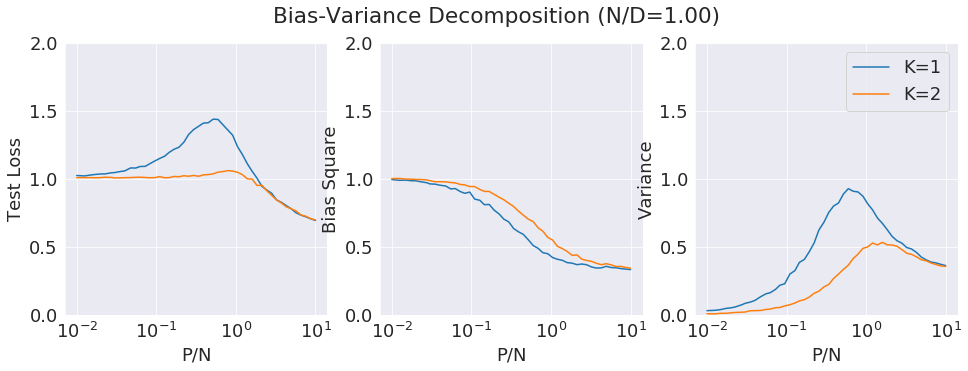

In [19]:
plot_single_vs_ensemble([K1_df, K2_df], [1, 2], N_Ds[0], feature_dim, ymax=2.0)

Change the coef to 0.01

Train size: [400] hidden size: [4] trial: 0, train_loss: 2.037904, test loss: 1.022333, bias2: 1.0223325490951538, variance: 2.1895582569264604e-10
Train size: [400] hidden size: [4] trial: 1, train_loss: 1.939638, test loss: 1.022546, bias2: 1.0103169679641724, variance: 0.012228565290570259
Train size: [400] hidden size: [4] trial: 2, train_loss: 1.908710, test loss: 1.019008, bias2: 1.0052242279052734, variance: 0.013784150592982769
Train size: [400] hidden size: [4] trial: 3, train_loss: 1.915815, test loss: 1.011454, bias2: 0.9934030771255493, variance: 0.01805102452635765
Train size: [400] hidden size: [4] trial: 4, train_loss: 1.903022, test loss: 1.011127, bias2: 0.9859099388122559, variance: 0.025216590613126755
Train size: [400] hidden size: [4] trial: 5, train_loss: 1.922316, test loss: 1.009327, bias2: 0.9871187210083008, variance: 0.022208215668797493
Train size: [400] hidden size: [4] trial: 6, train_loss: 1.933179, test loss: 1.008635, bias2: 0.9886596202850342, variance

Train size: [400] hidden size: [5] trial: 6, train_loss: 1.991885, test loss: 1.019310, bias2: 0.9811966419219971, variance: 0.03811332955956459
Train size: [400] hidden size: [5] trial: 7, train_loss: 1.980800, test loss: 1.019005, bias2: 0.9805086851119995, variance: 0.03849615901708603
Train size: [400] hidden size: [5] trial: 8, train_loss: 1.974581, test loss: 1.019765, bias2: 0.9805285334587097, variance: 0.03923683613538742
Train size: [400] hidden size: [5] trial: 9, train_loss: 1.998992, test loss: 1.021528, bias2: 0.9830766320228577, variance: 0.03845136612653732
Train size: [400] hidden size: [5] trial: 10, train_loss: 2.002708, test loss: 1.021449, bias2: 0.9834628105163574, variance: 0.037986014038324356
Train size: [400] hidden size: [5] trial: 11, train_loss: 1.992410, test loss: 1.019681, bias2: 0.9839743375778198, variance: 0.035706549882888794
Train size: [400] hidden size: [5] trial: 12, train_loss: 1.983169, test loss: 1.020043, bias2: 0.9837977290153503, variance: 

Train size: [400] hidden size: [6] trial: 12, train_loss: 1.982949, test loss: 1.012955, bias2: 0.9746814966201782, variance: 0.038273341953754425
Train size: [400] hidden size: [6] trial: 13, train_loss: 1.992585, test loss: 1.012135, bias2: 0.9745544195175171, variance: 0.037580106407403946
Train size: [400] hidden size: [6] trial: 14, train_loss: 1.992940, test loss: 1.011626, bias2: 0.9747411012649536, variance: 0.03688513860106468
Train size: [400] hidden size: [6] trial: 15, train_loss: 2.001168, test loss: 1.011129, bias2: 0.9744427800178528, variance: 0.03668611869215965
Train size: [400] hidden size: [6] trial: 16, train_loss: 2.011819, test loss: 1.014284, bias2: 0.9729765057563782, variance: 0.04130752012133598
Train size: [400] hidden size: [6] trial: 17, train_loss: 2.021090, test loss: 1.015132, bias2: 0.9733685851097107, variance: 0.04176301881670952
Train size: [400] hidden size: [6] trial: 18, train_loss: 2.007452, test loss: 1.014856, bias2: 0.9726118445396423, varian

Train size: [400] hidden size: [7] trial: 18, train_loss: 1.963552, test loss: 1.026907, bias2: 0.9781752824783325, variance: 0.04873180761933327
Train size: [400] hidden size: [7] trial: 19, train_loss: 1.969985, test loss: 1.027566, bias2: 0.9785109162330627, variance: 0.049054812639951706
Train size: [400] hidden size: [7] trial: 20, train_loss: 1.969672, test loss: 1.026429, bias2: 0.9786763787269592, variance: 0.04775279760360718
Train size: [400] hidden size: [7] trial: 21, train_loss: 1.956940, test loss: 1.026986, bias2: 0.9782276153564453, variance: 0.048757895827293396
Train size: [400] hidden size: [7] trial: 22, train_loss: 1.959740, test loss: 1.027790, bias2: 0.9775260090827942, variance: 0.050263579934835434
Train size: [400] hidden size: [7] trial: 23, train_loss: 1.958842, test loss: 1.027538, bias2: 0.9767797589302063, variance: 0.050758302211761475
Train size: [400] hidden size: [7] trial: 24, train_loss: 1.957812, test loss: 1.026566, bias2: 0.9760184288024902, vari

Train size: [400] hidden size: [8] trial: 24, train_loss: 1.960436, test loss: 1.025832, bias2: 0.9674155712127686, variance: 0.0584164559841156
Train size: [400] hidden size: [8] trial: 25, train_loss: 1.965795, test loss: 1.024879, bias2: 0.9674020409584045, variance: 0.05747705325484276
Train size: [400] hidden size: [8] trial: 26, train_loss: 1.973667, test loss: 1.024259, bias2: 0.967472493648529, variance: 0.056786101311445236
Train size: [400] hidden size: [8] trial: 27, train_loss: 1.958095, test loss: 1.025316, bias2: 0.9679341912269592, variance: 0.05738144740462303
Train size: [400] hidden size: [8] trial: 28, train_loss: 1.956709, test loss: 1.025144, bias2: 0.9684325456619263, variance: 0.056711189448833466
Train size: [400] hidden size: [8] trial: 29, train_loss: 1.949293, test loss: 1.024389, bias2: 0.9690024852752686, variance: 0.055386800318956375
Train size: [400] hidden size: [8] trial: 30, train_loss: 1.954194, test loss: 1.024314, bias2: 0.9692021012306213, varianc

Train size: [400] hidden size: [9] trial: 30, train_loss: 1.943077, test loss: 1.025748, bias2: 0.9676995873451233, variance: 0.05804841220378876
Train size: [400] hidden size: [9] trial: 31, train_loss: 1.948236, test loss: 1.025948, bias2: 0.9682247638702393, variance: 0.057722922414541245
Train size: [400] hidden size: [9] trial: 32, train_loss: 1.940449, test loss: 1.026868, bias2: 0.9685680270195007, variance: 0.058300409466028214
Train size: [400] hidden size: [9] trial: 33, train_loss: 1.944074, test loss: 1.029120, bias2: 0.9694427847862244, variance: 0.05967717245221138
Train size: [400] hidden size: [9] trial: 34, train_loss: 1.941109, test loss: 1.029190, bias2: 0.9699624180793762, variance: 0.05922798067331314
Train size: [400] hidden size: [9] trial: 35, train_loss: 1.939544, test loss: 1.028146, bias2: 0.9687647819519043, variance: 0.05938135087490082
Train size: [400] hidden size: [9] trial: 36, train_loss: 1.938793, test loss: 1.029078, bias2: 0.9681007862091064, varian

Train size: [400] hidden size: [11] trial: 36, train_loss: 1.866746, test loss: 1.034591, bias2: 0.9614431858062744, variance: 0.07314810156822205
Train size: [400] hidden size: [11] trial: 37, train_loss: 1.868482, test loss: 1.034760, bias2: 0.960634708404541, variance: 0.0741247907280922
Train size: [400] hidden size: [11] trial: 38, train_loss: 1.871600, test loss: 1.034332, bias2: 0.960480272769928, variance: 0.07385165244340897
Train size: [400] hidden size: [11] trial: 39, train_loss: 1.876595, test loss: 1.034409, bias2: 0.9603061079978943, variance: 0.07410281896591187
Train size: [400] hidden size: [11] trial: 40, train_loss: 1.875379, test loss: 1.034230, bias2: 0.9596248865127563, variance: 0.07460487633943558
Train size: [400] hidden size: [11] trial: 41, train_loss: 1.878869, test loss: 1.034329, bias2: 0.9601169228553772, variance: 0.07421189546585083
Train size: [400] hidden size: [11] trial: 42, train_loss: 1.880647, test loss: 1.035022, bias2: 0.9602761268615723, vari

Train size: [400] hidden size: [12] trial: 42, train_loss: 1.937888, test loss: 1.033495, bias2: 0.9581077098846436, variance: 0.07538769394159317
Train size: [400] hidden size: [12] trial: 43, train_loss: 1.936326, test loss: 1.033362, bias2: 0.9579426050186157, variance: 0.07541953772306442
Train size: [400] hidden size: [12] trial: 44, train_loss: 1.935703, test loss: 1.033581, bias2: 0.9585607051849365, variance: 0.07502005249261856
Train size: [400] hidden size: [12] trial: 45, train_loss: 1.938645, test loss: 1.033129, bias2: 0.9586409330368042, variance: 0.07448838651180267
Train size: [400] hidden size: [12] trial: 46, train_loss: 1.936081, test loss: 1.033304, bias2: 0.957749605178833, variance: 0.07555415481328964
Train size: [400] hidden size: [12] trial: 47, train_loss: 1.938685, test loss: 1.034657, bias2: 0.9570760130882263, variance: 0.077581487596035
Train size: [400] hidden size: [12] trial: 48, train_loss: 1.939740, test loss: 1.033901, bias2: 0.9567736387252808, vari

Train size: [400] hidden size: [14] trial: 48, train_loss: 1.918895, test loss: 1.041708, bias2: 0.9529889225959778, variance: 0.0887192115187645
Train size: [400] hidden size: [14] trial: 49, train_loss: 1.918682, test loss: 1.040974, bias2: 0.9513013958930969, variance: 0.08967237174510956
##################################################
Train size: [400] hidden size: [16] trial: 0, train_loss: 2.034949, test loss: 1.030106, bias2: 1.0301059484481812, variance: 1.9462739753173253e-10
Train size: [400] hidden size: [16] trial: 1, train_loss: 1.940738, test loss: 1.052762, bias2: 0.9866436719894409, variance: 0.06611838191747665
Train size: [400] hidden size: [16] trial: 2, train_loss: 1.923180, test loss: 1.054273, bias2: 0.9540396332740784, variance: 0.10023301839828491
Train size: [400] hidden size: [16] trial: 3, train_loss: 1.963465, test loss: 1.056143, bias2: 0.9498424530029297, variance: 0.10630038380622864
Train size: [400] hidden size: [16] trial: 4, train_loss: 1.938267, t

Train size: [400] hidden size: [19] trial: 4, train_loss: 1.932670, test loss: 1.082758, bias2: 0.9595791697502136, variance: 0.12317924946546555
Train size: [400] hidden size: [19] trial: 5, train_loss: 1.957637, test loss: 1.076809, bias2: 0.9568336009979248, variance: 0.11997582018375397
Train size: [400] hidden size: [19] trial: 6, train_loss: 1.945558, test loss: 1.072054, bias2: 0.952189564704895, variance: 0.11986467242240906
Train size: [400] hidden size: [19] trial: 7, train_loss: 1.939981, test loss: 1.067962, bias2: 0.9461508989334106, variance: 0.1218113973736763
Train size: [400] hidden size: [19] trial: 8, train_loss: 1.920076, test loss: 1.070828, bias2: 0.944240927696228, variance: 0.12658679485321045
Train size: [400] hidden size: [19] trial: 9, train_loss: 1.920877, test loss: 1.067551, bias2: 0.944179117679596, variance: 0.1233721598982811
Train size: [400] hidden size: [19] trial: 10, train_loss: 1.921888, test loss: 1.066343, bias2: 0.9419024586677551, variance: 0.

Train size: [400] hidden size: [22] trial: 10, train_loss: 1.896693, test loss: 1.077871, bias2: 0.9508729577064514, variance: 0.12699787318706512
Train size: [400] hidden size: [22] trial: 11, train_loss: 1.891512, test loss: 1.070263, bias2: 0.9452633857727051, variance: 0.12499915063381195
Train size: [400] hidden size: [22] trial: 12, train_loss: 1.898489, test loss: 1.068191, bias2: 0.9455211758613586, variance: 0.12266963720321655
Train size: [400] hidden size: [22] trial: 13, train_loss: 1.884461, test loss: 1.070286, bias2: 0.9468115568161011, variance: 0.12347424775362015
Train size: [400] hidden size: [22] trial: 14, train_loss: 1.878179, test loss: 1.071509, bias2: 0.9472038149833679, variance: 0.12430555373430252
Train size: [400] hidden size: [22] trial: 15, train_loss: 1.871652, test loss: 1.075024, bias2: 0.9426983594894409, variance: 0.13232599198818207
Train size: [400] hidden size: [22] trial: 16, train_loss: 1.871734, test loss: 1.072604, bias2: 0.941687822341919, va

Train size: [400] hidden size: [25] trial: 16, train_loss: 1.911323, test loss: 1.091878, bias2: 0.9247862100601196, variance: 0.16709232330322266
Train size: [400] hidden size: [25] trial: 17, train_loss: 1.913432, test loss: 1.091901, bias2: 0.9246951341629028, variance: 0.16720589995384216
Train size: [400] hidden size: [25] trial: 18, train_loss: 1.896204, test loss: 1.090698, bias2: 0.9245274662971497, variance: 0.1661704033613205
Train size: [400] hidden size: [25] trial: 19, train_loss: 1.896324, test loss: 1.089330, bias2: 0.924774706363678, variance: 0.1645553559064865
Train size: [400] hidden size: [25] trial: 20, train_loss: 1.893530, test loss: 1.091323, bias2: 0.9254447221755981, variance: 0.1658782660961151
Train size: [400] hidden size: [25] trial: 21, train_loss: 1.892900, test loss: 1.090193, bias2: 0.9237769842147827, variance: 0.16641603410243988
Train size: [400] hidden size: [25] trial: 22, train_loss: 1.890962, test loss: 1.090205, bias2: 0.9231457710266113, varia

Train size: [400] hidden size: [29] trial: 22, train_loss: 1.805862, test loss: 1.087591, bias2: 0.890516459941864, variance: 0.19707472622394562
Train size: [400] hidden size: [29] trial: 23, train_loss: 1.808683, test loss: 1.086060, bias2: 0.8913939595222473, variance: 0.19466586410999298
Train size: [400] hidden size: [29] trial: 24, train_loss: 1.808459, test loss: 1.084422, bias2: 0.8908202052116394, variance: 0.19360201060771942
Train size: [400] hidden size: [29] trial: 25, train_loss: 1.809486, test loss: 1.088202, bias2: 0.8901873826980591, variance: 0.19801458716392517
Train size: [400] hidden size: [29] trial: 26, train_loss: 1.809922, test loss: 1.093636, bias2: 0.8920230269432068, variance: 0.20161350071430206
Train size: [400] hidden size: [29] trial: 27, train_loss: 1.815591, test loss: 1.093170, bias2: 0.8927009105682373, variance: 0.2004694789648056
Train size: [400] hidden size: [29] trial: 28, train_loss: 1.813873, test loss: 1.090635, bias2: 0.8897970914840698, var

Train size: [400] hidden size: [33] trial: 28, train_loss: 1.822567, test loss: 1.126196, bias2: 0.8886629343032837, variance: 0.23753294348716736
Train size: [400] hidden size: [33] trial: 29, train_loss: 1.823008, test loss: 1.127073, bias2: 0.8859987258911133, variance: 0.2410743087530136
Train size: [400] hidden size: [33] trial: 30, train_loss: 1.818578, test loss: 1.125689, bias2: 0.885918915271759, variance: 0.23977035284042358
Train size: [400] hidden size: [33] trial: 31, train_loss: 1.815885, test loss: 1.124488, bias2: 0.8856124877929688, variance: 0.2388756424188614
Train size: [400] hidden size: [33] trial: 32, train_loss: 1.810448, test loss: 1.124306, bias2: 0.8843561410903931, variance: 0.23994968831539154
Train size: [400] hidden size: [33] trial: 33, train_loss: 1.812605, test loss: 1.123245, bias2: 0.8831860423088074, variance: 0.24005873501300812
Train size: [400] hidden size: [33] trial: 34, train_loss: 1.812387, test loss: 1.125856, bias2: 0.8842693567276001, vari

Train size: [400] hidden size: [38] trial: 34, train_loss: 1.742480, test loss: 1.146483, bias2: 0.8814936876296997, variance: 0.2649894058704376
Train size: [400] hidden size: [38] trial: 35, train_loss: 1.744034, test loss: 1.147877, bias2: 0.881135880947113, variance: 0.26674097776412964
Train size: [400] hidden size: [38] trial: 36, train_loss: 1.744740, test loss: 1.149039, bias2: 0.8805026412010193, variance: 0.2685360312461853
Train size: [400] hidden size: [38] trial: 37, train_loss: 1.747211, test loss: 1.149417, bias2: 0.878868579864502, variance: 0.2705487012863159
Train size: [400] hidden size: [38] trial: 38, train_loss: 1.747452, test loss: 1.149326, bias2: 0.87633216381073, variance: 0.2729935348033905
Train size: [400] hidden size: [38] trial: 39, train_loss: 1.744131, test loss: 1.148195, bias2: 0.8761123418807983, variance: 0.2720830738544464
Train size: [400] hidden size: [38] trial: 40, train_loss: 1.742684, test loss: 1.150659, bias2: 0.8751457929611206, variance: 

Train size: [400] hidden size: [44] trial: 40, train_loss: 1.706496, test loss: 1.159050, bias2: 0.8481349945068359, variance: 0.3109147250652313
Train size: [400] hidden size: [44] trial: 41, train_loss: 1.708327, test loss: 1.157534, bias2: 0.8492727875709534, variance: 0.30826109647750854
Train size: [400] hidden size: [44] trial: 42, train_loss: 1.713833, test loss: 1.159457, bias2: 0.8467864990234375, variance: 0.3126702308654785
Train size: [400] hidden size: [44] trial: 43, train_loss: 1.714917, test loss: 1.158375, bias2: 0.8469401597976685, variance: 0.31143447756767273
Train size: [400] hidden size: [44] trial: 44, train_loss: 1.709685, test loss: 1.156482, bias2: 0.8479481935501099, variance: 0.30853402614593506
Train size: [400] hidden size: [44] trial: 45, train_loss: 1.713610, test loss: 1.157959, bias2: 0.8493142127990723, variance: 0.308644562959671
Train size: [400] hidden size: [44] trial: 46, train_loss: 1.711993, test loss: 1.157003, bias2: 0.8504049777984619, varia

Train size: [400] hidden size: [51] trial: 46, train_loss: 1.656658, test loss: 1.186260, bias2: 0.8260701298713684, variance: 0.36018961668014526
Train size: [400] hidden size: [51] trial: 47, train_loss: 1.658303, test loss: 1.187086, bias2: 0.8262500762939453, variance: 0.36083558201789856
Train size: [400] hidden size: [51] trial: 48, train_loss: 1.660618, test loss: 1.188391, bias2: 0.82692551612854, variance: 0.36146512627601624
Train size: [400] hidden size: [51] trial: 49, train_loss: 1.660198, test loss: 1.190495, bias2: 0.8271514177322388, variance: 0.3633434474468231
##################################################
Train size: [400] hidden size: [58] trial: 0, train_loss: 1.735980, test loss: 1.383228, bias2: 1.3832284212112427, variance: -1.5570191802538602e-09
Train size: [400] hidden size: [58] trial: 1, train_loss: 1.726423, test loss: 1.286333, bias2: 1.0639842748641968, variance: 0.22234858572483063
Train size: [400] hidden size: [58] trial: 2, train_loss: 1.726485, 

Train size: [400] hidden size: [67] trial: 2, train_loss: 1.564741, test loss: 1.233588, bias2: 0.9270646572113037, variance: 0.30652377009391785
Train size: [400] hidden size: [67] trial: 3, train_loss: 1.520173, test loss: 1.252244, bias2: 0.9096011519432068, variance: 0.34264272451400757
Train size: [400] hidden size: [67] trial: 4, train_loss: 1.541476, test loss: 1.232551, bias2: 0.8829876184463501, variance: 0.349563866853714
Train size: [400] hidden size: [67] trial: 5, train_loss: 1.594915, test loss: 1.228024, bias2: 0.8530858755111694, variance: 0.3749382495880127
Train size: [400] hidden size: [67] trial: 6, train_loss: 1.565300, test loss: 1.225492, bias2: 0.8272513151168823, variance: 0.39824047684669495
Train size: [400] hidden size: [67] trial: 7, train_loss: 1.572175, test loss: 1.224870, bias2: 0.8210944533348083, variance: 0.40377551317214966
Train size: [400] hidden size: [67] trial: 8, train_loss: 1.585340, test loss: 1.230787, bias2: 0.8127326369285583, variance: 0

Train size: [400] hidden size: [77] trial: 8, train_loss: 1.513746, test loss: 1.266669, bias2: 0.7890939712524414, variance: 0.477575421333313
Train size: [400] hidden size: [77] trial: 9, train_loss: 1.512387, test loss: 1.276129, bias2: 0.7864640951156616, variance: 0.48966529965400696
Train size: [400] hidden size: [77] trial: 10, train_loss: 1.503444, test loss: 1.279067, bias2: 0.7826886177062988, variance: 0.49637797474861145
Train size: [400] hidden size: [77] trial: 11, train_loss: 1.492040, test loss: 1.279101, bias2: 0.7748783230781555, variance: 0.5042223334312439
Train size: [400] hidden size: [77] trial: 12, train_loss: 1.497747, test loss: 1.283816, bias2: 0.7722399234771729, variance: 0.5115765333175659
Train size: [400] hidden size: [77] trial: 13, train_loss: 1.497869, test loss: 1.286560, bias2: 0.7723167538642883, variance: 0.5142437815666199
Train size: [400] hidden size: [77] trial: 14, train_loss: 1.489644, test loss: 1.279765, bias2: 0.764369785785675, variance:

Train size: [400] hidden size: [89] trial: 14, train_loss: 1.411447, test loss: 1.339982, bias2: 0.7241771817207336, variance: 0.6158044934272766
Train size: [400] hidden size: [89] trial: 15, train_loss: 1.410894, test loss: 1.340770, bias2: 0.7207666635513306, variance: 0.6200029850006104
Train size: [400] hidden size: [89] trial: 16, train_loss: 1.407283, test loss: 1.340776, bias2: 0.7182862162590027, variance: 0.6224893927574158
Train size: [400] hidden size: [89] trial: 17, train_loss: 1.410721, test loss: 1.331474, bias2: 0.717006266117096, variance: 0.6144679188728333
Train size: [400] hidden size: [89] trial: 18, train_loss: 1.403971, test loss: 1.331967, bias2: 0.7173740267753601, variance: 0.6145930886268616
Train size: [400] hidden size: [89] trial: 19, train_loss: 1.404310, test loss: 1.328301, bias2: 0.7172237038612366, variance: 0.6110777258872986
Train size: [400] hidden size: [89] trial: 20, train_loss: 1.406653, test loss: 1.330934, bias2: 0.7160000205039978, variance

Train size: [400] hidden size: [102] trial: 20, train_loss: 1.359117, test loss: 1.454031, bias2: 0.7197794318199158, variance: 0.7342519164085388
Train size: [400] hidden size: [102] trial: 21, train_loss: 1.369713, test loss: 1.444288, bias2: 0.7169488668441772, variance: 0.7273386716842651
Train size: [400] hidden size: [102] trial: 22, train_loss: 1.372573, test loss: 1.437894, bias2: 0.7128729224205017, variance: 0.7250205874443054
Train size: [400] hidden size: [102] trial: 23, train_loss: 1.372170, test loss: 1.439056, bias2: 0.7109087109565735, variance: 0.7281474471092224
Train size: [400] hidden size: [102] trial: 24, train_loss: 1.364915, test loss: 1.442900, bias2: 0.7047296762466431, variance: 0.7381699085235596
Train size: [400] hidden size: [102] trial: 25, train_loss: 1.369962, test loss: 1.442529, bias2: 0.708044707775116, variance: 0.7344847321510315
Train size: [400] hidden size: [102] trial: 26, train_loss: 1.371444, test loss: 1.439081, bias2: 0.708143413066864, va

Train size: [400] hidden size: [118] trial: 26, train_loss: 1.268998, test loss: 1.541495, bias2: 0.6672990918159485, variance: 0.8741959929466248
Train size: [400] hidden size: [118] trial: 27, train_loss: 1.270083, test loss: 1.541145, bias2: 0.6636412739753723, variance: 0.8775036931037903
Train size: [400] hidden size: [118] trial: 28, train_loss: 1.272535, test loss: 1.541592, bias2: 0.6628594994544983, variance: 0.8787326216697693
Train size: [400] hidden size: [118] trial: 29, train_loss: 1.266250, test loss: 1.540423, bias2: 0.6607255339622498, variance: 0.8796979784965515
Train size: [400] hidden size: [118] trial: 30, train_loss: 1.271462, test loss: 1.536225, bias2: 0.6590401530265808, variance: 0.877185046672821
Train size: [400] hidden size: [118] trial: 31, train_loss: 1.272658, test loss: 1.535138, bias2: 0.6587551832199097, variance: 0.8763831853866577
Train size: [400] hidden size: [118] trial: 32, train_loss: 1.272422, test loss: 1.536284, bias2: 0.6568262577056885, v

Train size: [400] hidden size: [136] trial: 32, train_loss: 1.170387, test loss: 1.625939, bias2: 0.5977550745010376, variance: 1.028184175491333
Train size: [400] hidden size: [136] trial: 33, train_loss: 1.168249, test loss: 1.617719, bias2: 0.5986038446426392, variance: 1.019115686416626
Train size: [400] hidden size: [136] trial: 34, train_loss: 1.166168, test loss: 1.618498, bias2: 0.5978991985321045, variance: 1.0205984115600586
Train size: [400] hidden size: [136] trial: 35, train_loss: 1.167000, test loss: 1.620504, bias2: 0.599579930305481, variance: 1.0209245681762695
Train size: [400] hidden size: [136] trial: 36, train_loss: 1.165593, test loss: 1.614906, bias2: 0.6002780199050903, variance: 1.0146278142929077
Train size: [400] hidden size: [136] trial: 37, train_loss: 1.164405, test loss: 1.616679, bias2: 0.6003810167312622, variance: 1.016297698020935
Train size: [400] hidden size: [136] trial: 38, train_loss: 1.165332, test loss: 1.615441, bias2: 0.5990400314331055, vari

Train size: [400] hidden size: [156] trial: 38, train_loss: 1.054566, test loss: 1.787215, bias2: 0.5589473247528076, variance: 1.2282676696777344
Train size: [400] hidden size: [156] trial: 39, train_loss: 1.055335, test loss: 1.784271, bias2: 0.5602517127990723, variance: 1.2240194082260132
Train size: [400] hidden size: [156] trial: 40, train_loss: 1.055183, test loss: 1.793215, bias2: 0.5610160827636719, variance: 1.2321993112564087
Train size: [400] hidden size: [156] trial: 41, train_loss: 1.058193, test loss: 1.789993, bias2: 0.5606848001480103, variance: 1.229308009147644
Train size: [400] hidden size: [156] trial: 42, train_loss: 1.059431, test loss: 1.782445, bias2: 0.5598829984664917, variance: 1.2225615978240967
Train size: [400] hidden size: [156] trial: 43, train_loss: 1.059446, test loss: 1.784632, bias2: 0.5609058141708374, variance: 1.2237266302108765
Train size: [400] hidden size: [156] trial: 44, train_loss: 1.058719, test loss: 1.784147, bias2: 0.5603227615356445, v

Train size: [400] hidden size: [180] trial: 44, train_loss: 0.942655, test loss: 2.016066, bias2: 0.5058801174163818, variance: 1.5101861953735352
Train size: [400] hidden size: [180] trial: 45, train_loss: 0.940018, test loss: 2.019557, bias2: 0.5017095804214478, variance: 1.5178474187850952
Train size: [400] hidden size: [180] trial: 46, train_loss: 0.939807, test loss: 2.018515, bias2: 0.5022553205490112, variance: 1.516259789466858
Train size: [400] hidden size: [180] trial: 47, train_loss: 0.939217, test loss: 2.014102, bias2: 0.5029356479644775, variance: 1.5111668109893799
Train size: [400] hidden size: [180] trial: 48, train_loss: 0.939141, test loss: 2.008930, bias2: 0.5009255409240723, variance: 1.5080044269561768
Train size: [400] hidden size: [180] trial: 49, train_loss: 0.938900, test loss: 2.008972, bias2: 0.4992814064025879, variance: 1.509690523147583
##################################################
Train size: [400] hidden size: [207] trial: 0, train_loss: 0.834436, 

Train size: [400] hidden size: [239] trial: 0, train_loss: 0.644813, test loss: 2.578860, bias2: 2.578859567642212, variance: -2.1798269855821673e-08
Train size: [400] hidden size: [239] trial: 1, train_loss: 0.686437, test loss: 2.348988, bias2: 1.2891640663146973, variance: 1.059823751449585
Train size: [400] hidden size: [239] trial: 2, train_loss: 0.691564, test loss: 2.313786, bias2: 0.9843131303787231, variance: 1.3294724225997925
Train size: [400] hidden size: [239] trial: 3, train_loss: 0.665838, test loss: 2.331445, bias2: 0.8477137088775635, variance: 1.4837312698364258
Train size: [400] hidden size: [239] trial: 4, train_loss: 0.678318, test loss: 2.348965, bias2: 0.7188879251480103, variance: 1.6300767660140991
Train size: [400] hidden size: [239] trial: 5, train_loss: 0.671644, test loss: 2.326221, bias2: 0.6566205024719238, variance: 1.6696009635925293
Train size: [400] hidden size: [239] trial: 6, train_loss: 0.683412, test loss: 2.417115, bias2: 0.6284512281417847, vari

Train size: [400] hidden size: [275] trial: 6, train_loss: 0.547720, test loss: 2.642369, bias2: 0.6362442970275879, variance: 2.006124496459961
Train size: [400] hidden size: [275] trial: 7, train_loss: 0.543221, test loss: 2.636876, bias2: 0.5819449424743652, variance: 2.054931402206421
Train size: [400] hidden size: [275] trial: 8, train_loss: 0.546494, test loss: 2.608608, bias2: 0.5435795783996582, variance: 2.065028667449951
Train size: [400] hidden size: [275] trial: 9, train_loss: 0.537347, test loss: 2.601686, bias2: 0.525712251663208, variance: 2.075974225997925
Train size: [400] hidden size: [275] trial: 10, train_loss: 0.535603, test loss: 2.603525, bias2: 0.5075032711029053, variance: 2.0960211753845215
Train size: [400] hidden size: [275] trial: 11, train_loss: 0.519795, test loss: 2.592255, bias2: 0.5036866664886475, variance: 2.0885682106018066
Train size: [400] hidden size: [275] trial: 12, train_loss: 0.521131, test loss: 2.594664, bias2: 0.4856104850769043, variance:

Train size: [400] hidden size: [316] trial: 12, train_loss: 0.350569, test loss: 3.170927, bias2: 0.4803121089935303, variance: 2.690614938735962
Train size: [400] hidden size: [316] trial: 13, train_loss: 0.354128, test loss: 3.205389, bias2: 0.47238588333129883, variance: 2.7330026626586914
Train size: [400] hidden size: [316] trial: 14, train_loss: 0.351188, test loss: 3.230373, bias2: 0.46466898918151855, variance: 2.7657036781311035
Train size: [400] hidden size: [316] trial: 15, train_loss: 0.349323, test loss: 3.240797, bias2: 0.46201443672180176, variance: 2.778782606124878
Train size: [400] hidden size: [316] trial: 16, train_loss: 0.350555, test loss: 3.253821, bias2: 0.4565126895904541, variance: 2.7973084449768066
Train size: [400] hidden size: [316] trial: 17, train_loss: 0.357489, test loss: 3.254327, bias2: 0.44942712783813477, variance: 2.8049001693725586
Train size: [400] hidden size: [316] trial: 18, train_loss: 0.355497, test loss: 3.259178, bias2: 0.4310262203216553

Train size: [400] hidden size: [364] trial: 18, train_loss: 0.235602, test loss: 3.299381, bias2: 0.37369799613952637, variance: 2.925682783126831
Train size: [400] hidden size: [364] trial: 19, train_loss: 0.233680, test loss: 3.293704, bias2: 0.36652445793151855, variance: 2.9271790981292725
Train size: [400] hidden size: [364] trial: 20, train_loss: 0.233470, test loss: 3.290503, bias2: 0.36112546920776367, variance: 2.929377555847168
Train size: [400] hidden size: [364] trial: 21, train_loss: 0.234317, test loss: 3.288945, bias2: 0.3616209030151367, variance: 2.9273242950439453
Train size: [400] hidden size: [364] trial: 22, train_loss: 0.234695, test loss: 3.288376, bias2: 0.35398340225219727, variance: 2.9343926906585693
Train size: [400] hidden size: [364] trial: 23, train_loss: 0.236221, test loss: 3.333316, bias2: 0.34440159797668457, variance: 2.9889140129089355
Train size: [400] hidden size: [364] trial: 24, train_loss: 0.237287, test loss: 3.337188, bias2: 0.334491014480590

Train size: [400] hidden size: [419] trial: 24, train_loss: 0.128044, test loss: 3.140845, bias2: 0.3249819278717041, variance: 2.8158631324768066
Train size: [400] hidden size: [419] trial: 25, train_loss: 0.128919, test loss: 3.154793, bias2: 0.3219594955444336, variance: 2.832833766937256
Train size: [400] hidden size: [419] trial: 26, train_loss: 0.129917, test loss: 3.168876, bias2: 0.32267260551452637, variance: 2.8462038040161133
Train size: [400] hidden size: [419] trial: 27, train_loss: 0.129949, test loss: 3.165575, bias2: 0.3200366497039795, variance: 2.84553861618042
Train size: [400] hidden size: [419] trial: 28, train_loss: 0.129015, test loss: 3.175555, bias2: 0.3162837028503418, variance: 2.859271287918091
Train size: [400] hidden size: [419] trial: 29, train_loss: 0.128833, test loss: 3.174189, bias2: 0.31581950187683105, variance: 2.8583693504333496
Train size: [400] hidden size: [419] trial: 30, train_loss: 0.128967, test loss: 3.183822, bias2: 0.31670093536376953, v

Train size: [400] hidden size: [483] trial: 30, train_loss: 0.079675, test loss: 3.007553, bias2: 0.28633880615234375, variance: 2.7212142944335938
Train size: [400] hidden size: [483] trial: 31, train_loss: 0.079952, test loss: 3.014601, bias2: 0.2836029529571533, variance: 2.7309980392456055
Train size: [400] hidden size: [483] trial: 32, train_loss: 0.079745, test loss: 3.008252, bias2: 0.28418493270874023, variance: 2.724067211151123
Train size: [400] hidden size: [483] trial: 33, train_loss: 0.079925, test loss: 3.006961, bias2: 0.28052234649658203, variance: 2.726438522338867
Train size: [400] hidden size: [483] trial: 34, train_loss: 0.079558, test loss: 2.999881, bias2: 0.2815394401550293, variance: 2.7183420658111572
Train size: [400] hidden size: [483] trial: 35, train_loss: 0.079912, test loss: 2.996904, bias2: 0.276827335357666, variance: 2.720076322555542
Train size: [400] hidden size: [483] trial: 36, train_loss: 0.079127, test loss: 2.986217, bias2: 0.27307891845703125, 

Train size: [400] hidden size: [556] trial: 36, train_loss: 0.046483, test loss: 2.519688, bias2: 0.2552299499511719, variance: 2.264458179473877
Train size: [400] hidden size: [556] trial: 37, train_loss: 0.046347, test loss: 2.518767, bias2: 0.2548027038574219, variance: 2.2639639377593994
Train size: [400] hidden size: [556] trial: 38, train_loss: 0.046194, test loss: 2.515650, bias2: 0.25111889839172363, variance: 2.264531373977661
Train size: [400] hidden size: [556] trial: 39, train_loss: 0.046092, test loss: 2.509538, bias2: 0.2496497631072998, variance: 2.259887933731079
Train size: [400] hidden size: [556] trial: 40, train_loss: 0.045966, test loss: 2.508429, bias2: 0.2495882511138916, variance: 2.258841037750244
Train size: [400] hidden size: [556] trial: 41, train_loss: 0.046060, test loss: 2.505338, bias2: 0.25082993507385254, variance: 2.2545080184936523
Train size: [400] hidden size: [556] trial: 42, train_loss: 0.045944, test loss: 2.501836, bias2: 0.250014066696167, var

Train size: [400] hidden size: [640] trial: 42, train_loss: 0.031460, test loss: 2.171172, bias2: 0.24832141399383545, variance: 1.922850251197815
Train size: [400] hidden size: [640] trial: 43, train_loss: 0.031271, test loss: 2.172535, bias2: 0.24901819229125977, variance: 1.9235165119171143
Train size: [400] hidden size: [640] trial: 44, train_loss: 0.031327, test loss: 2.174386, bias2: 0.24774086475372314, variance: 1.9266453981399536
Train size: [400] hidden size: [640] trial: 45, train_loss: 0.031262, test loss: 2.173420, bias2: 0.24841046333312988, variance: 1.9250099658966064
Train size: [400] hidden size: [640] trial: 46, train_loss: 0.031176, test loss: 2.172337, bias2: 0.24841761589050293, variance: 1.923919677734375
Train size: [400] hidden size: [640] trial: 47, train_loss: 0.031100, test loss: 2.172726, bias2: 0.24784183502197266, variance: 1.9248836040496826
Train size: [400] hidden size: [640] trial: 48, train_loss: 0.031098, test loss: 2.170637, bias2: 0.24728381633758

Train size: [400] hidden size: [737] trial: 48, train_loss: 0.020421, test loss: 1.856228, bias2: 0.21923983097076416, variance: 1.6369885206222534
Train size: [400] hidden size: [737] trial: 49, train_loss: 0.020517, test loss: 1.857240, bias2: 0.2170119285583496, variance: 1.6402277946472168
##################################################
Train size: [400] hidden size: [848] trial: 0, train_loss: 0.017644, test loss: 1.600969, bias2: 1.6009690761566162, variance: -1.0120625226761604e-08
Train size: [400] hidden size: [848] trial: 1, train_loss: 0.016704, test loss: 1.600755, bias2: 0.9532716274261475, variance: 0.6474833488464355
Train size: [400] hidden size: [848] trial: 2, train_loss: 0.015729, test loss: 1.669205, bias2: 0.6840339303016663, variance: 0.9851714968681335
Train size: [400] hidden size: [848] trial: 3, train_loss: 0.015944, test loss: 1.647914, bias2: 0.5576118230819702, variance: 1.0903021097183228
Train size: [400] hidden size: [848] trial: 4, train_loss: 0.0169

Train size: [400] hidden size: [977] trial: 3, train_loss: 0.011759, test loss: 1.470549, bias2: 0.4603170156478882, variance: 1.0102322101593018
Train size: [400] hidden size: [977] trial: 4, train_loss: 0.012327, test loss: 1.456300, bias2: 0.38700592517852783, variance: 1.0692938566207886
Train size: [400] hidden size: [977] trial: 5, train_loss: 0.012562, test loss: 1.450226, bias2: 0.350766658782959, variance: 1.099458932876587
Train size: [400] hidden size: [977] trial: 6, train_loss: 0.012391, test loss: 1.433951, bias2: 0.3206428289413452, variance: 1.1133085489273071
Train size: [400] hidden size: [977] trial: 7, train_loss: 0.012324, test loss: 1.447012, bias2: 0.3064413070678711, variance: 1.1405709981918335
Train size: [400] hidden size: [977] trial: 8, train_loss: 0.012481, test loss: 1.458770, bias2: 0.3026832342147827, variance: 1.1560872793197632
Train size: [400] hidden size: [977] trial: 9, train_loss: 0.012449, test loss: 1.460126, bias2: 0.28727078437805176, varianc

Train size: [400] hidden size: [1125] trial: 9, train_loss: 0.010029, test loss: 1.313785, bias2: 0.31315457820892334, variance: 1.000630497932434
Train size: [400] hidden size: [1125] trial: 10, train_loss: 0.010075, test loss: 1.316374, bias2: 0.2959756851196289, variance: 1.0203979015350342
Train size: [400] hidden size: [1125] trial: 11, train_loss: 0.010124, test loss: 1.322226, bias2: 0.286726713180542, variance: 1.0354989767074585
Train size: [400] hidden size: [1125] trial: 12, train_loss: 0.010193, test loss: 1.330717, bias2: 0.2805955410003662, variance: 1.0501216650009155
Train size: [400] hidden size: [1125] trial: 13, train_loss: 0.010167, test loss: 1.328177, bias2: 0.27694642543792725, variance: 1.0512303113937378
Train size: [400] hidden size: [1125] trial: 14, train_loss: 0.010181, test loss: 1.327679, bias2: 0.27116477489471436, variance: 1.0565145015716553
Train size: [400] hidden size: [1125] trial: 15, train_loss: 0.010197, test loss: 1.338508, bias2: 0.26944386959

Train size: [400] hidden size: [1295] trial: 14, train_loss: 0.009377, test loss: 1.217057, bias2: 0.2608887553215027, variance: 0.9561682343482971
Train size: [400] hidden size: [1295] trial: 15, train_loss: 0.009363, test loss: 1.219283, bias2: 0.2534409165382385, variance: 0.9658425450325012
Train size: [400] hidden size: [1295] trial: 16, train_loss: 0.009318, test loss: 1.220357, bias2: 0.250118613243103, variance: 0.9702383279800415
Train size: [400] hidden size: [1295] trial: 17, train_loss: 0.009327, test loss: 1.219192, bias2: 0.24414163827896118, variance: 0.9750506281852722
Train size: [400] hidden size: [1295] trial: 18, train_loss: 0.009331, test loss: 1.216557, bias2: 0.24023228883743286, variance: 0.9763244986534119
Train size: [400] hidden size: [1295] trial: 19, train_loss: 0.009297, test loss: 1.219488, bias2: 0.23749077320098877, variance: 0.981997013092041
Train size: [400] hidden size: [1295] trial: 20, train_loss: 0.009257, test loss: 1.220870, bias2: 0.2322673201

Train size: [400] hidden size: [1491] trial: 19, train_loss: 0.007967, test loss: 1.157239, bias2: 0.2526888847351074, variance: 0.9045497179031372
Train size: [400] hidden size: [1491] trial: 20, train_loss: 0.007997, test loss: 1.155816, bias2: 0.24958431720733643, variance: 0.9062315225601196
Train size: [400] hidden size: [1491] trial: 21, train_loss: 0.007943, test loss: 1.153078, bias2: 0.24662071466445923, variance: 0.9064571261405945
Train size: [400] hidden size: [1491] trial: 22, train_loss: 0.007968, test loss: 1.150670, bias2: 0.2441825270652771, variance: 0.9064870476722717
Train size: [400] hidden size: [1491] trial: 23, train_loss: 0.007944, test loss: 1.151163, bias2: 0.24519997835159302, variance: 0.905963122844696
Train size: [400] hidden size: [1491] trial: 24, train_loss: 0.008011, test loss: 1.150919, bias2: 0.2410721778869629, variance: 0.9098465442657471
Train size: [400] hidden size: [1491] trial: 25, train_loss: 0.008044, test loss: 1.145986, bias2: 0.240147471

Train size: [400] hidden size: [1717] trial: 24, train_loss: 0.007157, test loss: 1.092747, bias2: 0.2405071258544922, variance: 0.8522402048110962
Train size: [400] hidden size: [1717] trial: 25, train_loss: 0.007159, test loss: 1.090910, bias2: 0.23503828048706055, variance: 0.8558717966079712
Train size: [400] hidden size: [1717] trial: 26, train_loss: 0.007127, test loss: 1.089719, bias2: 0.2337142825126648, variance: 0.8560051321983337
Train size: [400] hidden size: [1717] trial: 27, train_loss: 0.007106, test loss: 1.087965, bias2: 0.23504102230072021, variance: 0.8529236316680908
Train size: [400] hidden size: [1717] trial: 28, train_loss: 0.007077, test loss: 1.087042, bias2: 0.23561811447143555, variance: 0.8514242172241211
Train size: [400] hidden size: [1717] trial: 29, train_loss: 0.007079, test loss: 1.092278, bias2: 0.23710602521896362, variance: 0.8551720976829529
Train size: [400] hidden size: [1717] trial: 30, train_loss: 0.007112, test loss: 1.093735, bias2: 0.2365022

Train size: [400] hidden size: [1977] trial: 29, train_loss: 0.006591, test loss: 1.007939, bias2: 0.22013217210769653, variance: 0.7878068089485168
Train size: [400] hidden size: [1977] trial: 30, train_loss: 0.006578, test loss: 1.008407, bias2: 0.22174346446990967, variance: 0.7866631746292114
Train size: [400] hidden size: [1977] trial: 31, train_loss: 0.006569, test loss: 1.008996, bias2: 0.2224806547164917, variance: 0.7865148782730103
Train size: [400] hidden size: [1977] trial: 32, train_loss: 0.006546, test loss: 1.010303, bias2: 0.22245126962661743, variance: 0.7878515124320984
Train size: [400] hidden size: [1977] trial: 33, train_loss: 0.006543, test loss: 1.010708, bias2: 0.22029417753219604, variance: 0.7904142737388611
Train size: [400] hidden size: [1977] trial: 34, train_loss: 0.006560, test loss: 1.010272, bias2: 0.2193031907081604, variance: 0.7909688353538513
Train size: [400] hidden size: [1977] trial: 35, train_loss: 0.006600, test loss: 1.012263, bias2: 0.2184888

Train size: [400] hidden size: [2276] trial: 34, train_loss: 0.006035, test loss: 0.969776, bias2: 0.21632933616638184, variance: 0.7534468173980713
Train size: [400] hidden size: [2276] trial: 35, train_loss: 0.006030, test loss: 0.969942, bias2: 0.21729153394699097, variance: 0.7526502013206482
Train size: [400] hidden size: [2276] trial: 36, train_loss: 0.006039, test loss: 0.968422, bias2: 0.21672594547271729, variance: 0.7516956329345703
Train size: [400] hidden size: [2276] trial: 37, train_loss: 0.006067, test loss: 0.968662, bias2: 0.21463966369628906, variance: 0.7540223002433777
Train size: [400] hidden size: [2276] trial: 38, train_loss: 0.006078, test loss: 0.967115, bias2: 0.2132863998413086, variance: 0.7538288235664368
Train size: [400] hidden size: [2276] trial: 39, train_loss: 0.006097, test loss: 0.968026, bias2: 0.21212905645370483, variance: 0.755896806716919
Train size: [400] hidden size: [2276] trial: 40, train_loss: 0.006090, test loss: 0.966629, bias2: 0.2108320

Train size: [400] hidden size: [2621] trial: 39, train_loss: 0.005682, test loss: 0.944868, bias2: 0.22127783298492432, variance: 0.7235899567604065
Train size: [400] hidden size: [2621] trial: 40, train_loss: 0.005646, test loss: 0.942781, bias2: 0.22012996673583984, variance: 0.7226512432098389
Train size: [400] hidden size: [2621] trial: 41, train_loss: 0.005636, test loss: 0.944167, bias2: 0.22050482034683228, variance: 0.7236618399620056
Train size: [400] hidden size: [2621] trial: 42, train_loss: 0.005626, test loss: 0.943179, bias2: 0.21952420473098755, variance: 0.723654568195343
Train size: [400] hidden size: [2621] trial: 43, train_loss: 0.005655, test loss: 0.942633, bias2: 0.21880489587783813, variance: 0.7238282561302185
Train size: [400] hidden size: [2621] trial: 44, train_loss: 0.005633, test loss: 0.941657, bias2: 0.21935266256332397, variance: 0.7223042845726013
Train size: [400] hidden size: [2621] trial: 45, train_loss: 0.005619, test loss: 0.940951, bias2: 0.219278

Train size: [400] hidden size: [3017] trial: 44, train_loss: 0.005152, test loss: 0.888909, bias2: 0.21618002653121948, variance: 0.6727290749549866
Train size: [400] hidden size: [3017] trial: 45, train_loss: 0.005143, test loss: 0.888728, bias2: 0.21596503257751465, variance: 0.6727628707885742
Train size: [400] hidden size: [3017] trial: 46, train_loss: 0.005161, test loss: 0.890514, bias2: 0.21591782569885254, variance: 0.6745961308479309
Train size: [400] hidden size: [3017] trial: 47, train_loss: 0.005153, test loss: 0.893438, bias2: 0.2161063551902771, variance: 0.6773315668106079
Train size: [400] hidden size: [3017] trial: 48, train_loss: 0.005170, test loss: 0.891806, bias2: 0.2140125036239624, variance: 0.6777939200401306
Train size: [400] hidden size: [3017] trial: 49, train_loss: 0.005162, test loss: 0.890223, bias2: 0.2133539319038391, variance: 0.67686927318573
##################################################
Train size: [400] hidden size: [3474] trial: 0, train_loss: 

Train size: [400] hidden size: [3474] trial: 49, train_loss: 0.004986, test loss: 0.874790, bias2: 0.21947991847991943, variance: 0.6553099155426025
##################################################
Train size: [400] hidden size: [4000] trial: 0, train_loss: 0.005031, test loss: 0.966842, bias2: 0.9668416976928711, variance: -1.5570191802538602e-09
Train size: [400] hidden size: [4000] trial: 1, train_loss: 0.005025, test loss: 0.923551, bias2: 0.5831531286239624, variance: 0.3403974175453186
Train size: [400] hidden size: [4000] trial: 2, train_loss: 0.005044, test loss: 0.917553, bias2: 0.4775446653366089, variance: 0.44000816345214844
Train size: [400] hidden size: [4000] trial: 3, train_loss: 0.005067, test loss: 0.891243, bias2: 0.3936423361301422, variance: 0.49760112166404724
Train size: [400] hidden size: [4000] trial: 4, train_loss: 0.005098, test loss: 0.891589, bias2: 0.355252206325531, variance: 0.5363370180130005
Train size: [400] hidden size: [4000] trial: 5, train_loss:

Train size: [400] hidden size: [4] trial: 4, train_loss: 1.965581, test loss: 1.000478, bias2: 0.9974180459976196, variance: 0.0030601928010582924
Train size: [400] hidden size: [4] trial: 5, train_loss: 1.959105, test loss: 1.001617, bias2: 0.9976685643196106, variance: 0.003947905730456114
Train size: [400] hidden size: [4] trial: 6, train_loss: 1.964111, test loss: 1.000375, bias2: 0.9959831833839417, variance: 0.004391636699438095
Train size: [400] hidden size: [4] trial: 7, train_loss: 1.939375, test loss: 0.999976, bias2: 0.9958164095878601, variance: 0.004159722477197647
Train size: [400] hidden size: [4] trial: 8, train_loss: 1.938464, test loss: 0.998894, bias2: 0.9947783350944519, variance: 0.004115825518965721
Train size: [400] hidden size: [4] trial: 9, train_loss: 1.945351, test loss: 0.999031, bias2: 0.9946784973144531, variance: 0.004352707415819168
Train size: [400] hidden size: [4] trial: 10, train_loss: 1.959610, test loss: 0.999134, bias2: 0.9941758513450623, varianc

Train size: [400] hidden size: [5] trial: 10, train_loss: 1.951771, test loss: 0.997346, bias2: 0.9912858605384827, variance: 0.006060111336410046
Train size: [400] hidden size: [5] trial: 11, train_loss: 1.945246, test loss: 0.997064, bias2: 0.9911664724349976, variance: 0.00589709123596549
Train size: [400] hidden size: [5] trial: 12, train_loss: 1.943563, test loss: 0.998154, bias2: 0.991040825843811, variance: 0.0071132308803498745
Train size: [400] hidden size: [5] trial: 13, train_loss: 1.951699, test loss: 0.998216, bias2: 0.9909942150115967, variance: 0.007221884094178677
Train size: [400] hidden size: [5] trial: 14, train_loss: 1.960487, test loss: 0.998505, bias2: 0.9900653958320618, variance: 0.00843933317810297
Train size: [400] hidden size: [5] trial: 15, train_loss: 1.955845, test loss: 0.998905, bias2: 0.9906880259513855, variance: 0.008216677233576775
Train size: [400] hidden size: [5] trial: 16, train_loss: 1.955150, test loss: 0.998722, bias2: 0.9908726215362549, vari

Train size: [400] hidden size: [6] trial: 16, train_loss: 2.009930, test loss: 0.996863, bias2: 0.9887171983718872, variance: 0.008145906962454319
Train size: [400] hidden size: [6] trial: 17, train_loss: 2.005511, test loss: 0.996612, bias2: 0.9884023666381836, variance: 0.008209716528654099
Train size: [400] hidden size: [6] trial: 18, train_loss: 2.005406, test loss: 0.996144, bias2: 0.987831175327301, variance: 0.008312665857374668
Train size: [400] hidden size: [6] trial: 19, train_loss: 1.993085, test loss: 0.995903, bias2: 0.9874467253684998, variance: 0.008455855771899223
Train size: [400] hidden size: [6] trial: 20, train_loss: 1.992244, test loss: 0.995806, bias2: 0.9874085187911987, variance: 0.008397439494729042
Train size: [400] hidden size: [6] trial: 21, train_loss: 1.994410, test loss: 0.995214, bias2: 0.9865323305130005, variance: 0.008681228384375572
Train size: [400] hidden size: [6] trial: 22, train_loss: 1.992080, test loss: 0.996424, bias2: 0.9871348738670349, var

Train size: [400] hidden size: [7] trial: 22, train_loss: 1.970956, test loss: 0.997769, bias2: 0.9864851832389832, variance: 0.011284095235168934
Train size: [400] hidden size: [7] trial: 23, train_loss: 1.971053, test loss: 0.997475, bias2: 0.9860110282897949, variance: 0.011464334093034267
Train size: [400] hidden size: [7] trial: 24, train_loss: 1.971449, test loss: 0.998101, bias2: 0.9866054654121399, variance: 0.011495726183056831
Train size: [400] hidden size: [7] trial: 25, train_loss: 1.965810, test loss: 0.998326, bias2: 0.9868799448013306, variance: 0.011446249671280384
Train size: [400] hidden size: [7] trial: 26, train_loss: 1.964559, test loss: 0.998284, bias2: 0.9870879650115967, variance: 0.011195727623999119
Train size: [400] hidden size: [7] trial: 27, train_loss: 1.964496, test loss: 0.998532, bias2: 0.9873669743537903, variance: 0.011165349744260311
Train size: [400] hidden size: [7] trial: 28, train_loss: 1.966683, test loss: 0.998258, bias2: 0.9872006177902222, va

Train size: [400] hidden size: [8] trial: 28, train_loss: 1.962245, test loss: 0.999431, bias2: 0.984157919883728, variance: 0.015273437835276127
Train size: [400] hidden size: [8] trial: 29, train_loss: 1.961620, test loss: 0.999176, bias2: 0.9841224551200867, variance: 0.015053864568471909
Train size: [400] hidden size: [8] trial: 30, train_loss: 1.957279, test loss: 0.999940, bias2: 0.9842463135719299, variance: 0.015694061294198036
Train size: [400] hidden size: [8] trial: 31, train_loss: 1.961740, test loss: 0.999631, bias2: 0.9841222167015076, variance: 0.015508865937590599
Train size: [400] hidden size: [8] trial: 32, train_loss: 1.956954, test loss: 0.999513, bias2: 0.984299898147583, variance: 0.015213511884212494
Train size: [400] hidden size: [8] trial: 33, train_loss: 1.955460, test loss: 0.999390, bias2: 0.9845046401023865, variance: 0.014885004609823227
Train size: [400] hidden size: [8] trial: 34, train_loss: 1.960865, test loss: 0.999525, bias2: 0.9848487377166748, vari

Train size: [400] hidden size: [9] trial: 34, train_loss: 1.916122, test loss: 0.999161, bias2: 0.984390377998352, variance: 0.014770123176276684
Train size: [400] hidden size: [9] trial: 35, train_loss: 1.917528, test loss: 0.999486, bias2: 0.9847401976585388, variance: 0.014745954424142838
Train size: [400] hidden size: [9] trial: 36, train_loss: 1.922930, test loss: 0.999680, bias2: 0.9848192930221558, variance: 0.01486087217926979
Train size: [400] hidden size: [9] trial: 37, train_loss: 1.928448, test loss: 0.999613, bias2: 0.9847618937492371, variance: 0.014851530082523823
Train size: [400] hidden size: [9] trial: 38, train_loss: 1.934912, test loss: 0.999944, bias2: 0.9849425554275513, variance: 0.015001778490841389
Train size: [400] hidden size: [9] trial: 39, train_loss: 1.936264, test loss: 0.999914, bias2: 0.9847453832626343, variance: 0.015168815851211548
Train size: [400] hidden size: [9] trial: 40, train_loss: 1.930717, test loss: 0.999911, bias2: 0.985003650188446, varia

Train size: [400] hidden size: [11] trial: 40, train_loss: 1.933549, test loss: 0.997184, bias2: 0.9784274101257324, variance: 0.018756121397018433
Train size: [400] hidden size: [11] trial: 41, train_loss: 1.931370, test loss: 0.996993, bias2: 0.9783662557601929, variance: 0.01862690970301628
Train size: [400] hidden size: [11] trial: 42, train_loss: 1.931443, test loss: 0.996917, bias2: 0.9782488942146301, variance: 0.018668437376618385
Train size: [400] hidden size: [11] trial: 43, train_loss: 1.935078, test loss: 0.996578, bias2: 0.9778769016265869, variance: 0.01870109885931015
Train size: [400] hidden size: [11] trial: 44, train_loss: 1.932946, test loss: 0.996651, bias2: 0.9779293537139893, variance: 0.018722012639045715
Train size: [400] hidden size: [11] trial: 45, train_loss: 1.933471, test loss: 0.997265, bias2: 0.978337287902832, variance: 0.018927449360489845
Train size: [400] hidden size: [11] trial: 46, train_loss: 1.931034, test loss: 0.997161, bias2: 0.9783599972724915

Train size: [400] hidden size: [12] trial: 46, train_loss: 1.960779, test loss: 1.002009, bias2: 0.981249213218689, variance: 0.020759351551532745
Train size: [400] hidden size: [12] trial: 47, train_loss: 1.963220, test loss: 1.001880, bias2: 0.9809580445289612, variance: 0.020921766757965088
Train size: [400] hidden size: [12] trial: 48, train_loss: 1.968010, test loss: 1.001797, bias2: 0.9809262156486511, variance: 0.02087121270596981
Train size: [400] hidden size: [12] trial: 49, train_loss: 1.962162, test loss: 1.001804, bias2: 0.9811969995498657, variance: 0.020606501027941704
##################################################
Train size: [400] hidden size: [14] trial: 0, train_loss: 1.896084, test loss: 0.994394, bias2: 0.994394063949585, variance: 1.9462739753173253e-10
Train size: [400] hidden size: [14] trial: 1, train_loss: 1.897959, test loss: 0.992392, bias2: 0.9744247794151306, variance: 0.017967062070965767
Train size: [400] hidden size: [14] trial: 2, train_loss: 1.9066

Train size: [400] hidden size: [16] trial: 1, train_loss: 2.019820, test loss: 1.004568, bias2: 0.9868522882461548, variance: 0.01771583966910839
Train size: [400] hidden size: [16] trial: 2, train_loss: 1.975337, test loss: 1.002242, bias2: 0.9781880378723145, variance: 0.02405366487801075
Train size: [400] hidden size: [16] trial: 3, train_loss: 1.962108, test loss: 0.999858, bias2: 0.9770711064338684, variance: 0.02278720773756504
Train size: [400] hidden size: [16] trial: 4, train_loss: 1.959175, test loss: 0.998369, bias2: 0.9735402464866638, variance: 0.024829039350152016
Train size: [400] hidden size: [16] trial: 5, train_loss: 1.963505, test loss: 0.994412, bias2: 0.9692659378051758, variance: 0.025146517902612686
Train size: [400] hidden size: [16] trial: 6, train_loss: 1.924965, test loss: 0.994180, bias2: 0.9685357809066772, variance: 0.02564440667629242
Train size: [400] hidden size: [16] trial: 7, train_loss: 1.956646, test loss: 0.993517, bias2: 0.9688848853111267, varian

Train size: [400] hidden size: [19] trial: 7, train_loss: 1.916760, test loss: 1.000841, bias2: 0.9786832928657532, variance: 0.022158106788992882
Train size: [400] hidden size: [19] trial: 8, train_loss: 1.924716, test loss: 0.998331, bias2: 0.9749861359596252, variance: 0.023344749584794044
Train size: [400] hidden size: [19] trial: 9, train_loss: 1.910737, test loss: 0.998015, bias2: 0.9746201634407043, variance: 0.023394957184791565
Train size: [400] hidden size: [19] trial: 10, train_loss: 1.877770, test loss: 1.000481, bias2: 0.972684383392334, variance: 0.027796121314167976
Train size: [400] hidden size: [19] trial: 11, train_loss: 1.877877, test loss: 0.997337, bias2: 0.9685904383659363, variance: 0.028746914118528366
Train size: [400] hidden size: [19] trial: 12, train_loss: 1.871717, test loss: 0.996970, bias2: 0.968142569065094, variance: 0.02882741577923298
Train size: [400] hidden size: [19] trial: 13, train_loss: 1.871435, test loss: 0.996846, bias2: 0.967971682548523, va

Train size: [400] hidden size: [22] trial: 13, train_loss: 1.831416, test loss: 0.998808, bias2: 0.9663872122764587, variance: 0.03242047503590584
Train size: [400] hidden size: [22] trial: 14, train_loss: 1.835993, test loss: 0.998153, bias2: 0.966054379940033, variance: 0.032098814845085144
Train size: [400] hidden size: [22] trial: 15, train_loss: 1.843927, test loss: 0.996564, bias2: 0.9650851488113403, variance: 0.031479015946388245
Train size: [400] hidden size: [22] trial: 16, train_loss: 1.840328, test loss: 0.997040, bias2: 0.965967059135437, variance: 0.031073102727532387
Train size: [400] hidden size: [22] trial: 17, train_loss: 1.846576, test loss: 0.996607, bias2: 0.9649937152862549, variance: 0.031613174825906754
Train size: [400] hidden size: [22] trial: 18, train_loss: 1.855762, test loss: 0.996556, bias2: 0.9649472832679749, variance: 0.031608518213033676
Train size: [400] hidden size: [22] trial: 19, train_loss: 1.856645, test loss: 0.996430, bias2: 0.9644795060157776

Train size: [400] hidden size: [25] trial: 19, train_loss: 1.884846, test loss: 0.999354, bias2: 0.9538995027542114, variance: 0.04545453190803528
Train size: [400] hidden size: [25] trial: 20, train_loss: 1.879849, test loss: 0.999442, bias2: 0.9539440870285034, variance: 0.04549795761704445
Train size: [400] hidden size: [25] trial: 21, train_loss: 1.877569, test loss: 0.999438, bias2: 0.9545893669128418, variance: 0.044848475605249405
Train size: [400] hidden size: [25] trial: 22, train_loss: 1.879842, test loss: 0.999309, bias2: 0.9549222588539124, variance: 0.04438721761107445
Train size: [400] hidden size: [25] trial: 23, train_loss: 1.867658, test loss: 1.000249, bias2: 0.9553016424179077, variance: 0.04494773969054222
Train size: [400] hidden size: [25] trial: 24, train_loss: 1.863579, test loss: 1.000700, bias2: 0.9553266763687134, variance: 0.045372869819402695
Train size: [400] hidden size: [25] trial: 25, train_loss: 1.855401, test loss: 1.000132, bias2: 0.9552908539772034,

Train size: [400] hidden size: [29] trial: 25, train_loss: 1.882111, test loss: 0.996815, bias2: 0.9519155025482178, variance: 0.04490001127123833
Train size: [400] hidden size: [29] trial: 26, train_loss: 1.878143, test loss: 0.996258, bias2: 0.9516201615333557, variance: 0.04463758319616318
Train size: [400] hidden size: [29] trial: 27, train_loss: 1.877694, test loss: 0.995642, bias2: 0.9516698718070984, variance: 0.043971896171569824
Train size: [400] hidden size: [29] trial: 28, train_loss: 1.877849, test loss: 0.995355, bias2: 0.9507625102996826, variance: 0.04459289088845253
Train size: [400] hidden size: [29] trial: 29, train_loss: 1.877701, test loss: 0.995480, bias2: 0.9513686299324036, variance: 0.04411159083247185
Train size: [400] hidden size: [29] trial: 30, train_loss: 1.875550, test loss: 0.994925, bias2: 0.9506654739379883, variance: 0.044259410351514816
Train size: [400] hidden size: [29] trial: 31, train_loss: 1.867583, test loss: 0.994081, bias2: 0.9500055313110352,

Train size: [400] hidden size: [33] trial: 31, train_loss: 1.885101, test loss: 0.999573, bias2: 0.9433795809745789, variance: 0.05619369447231293
Train size: [400] hidden size: [33] trial: 32, train_loss: 1.881444, test loss: 0.998756, bias2: 0.9419907331466675, variance: 0.056765198707580566
Train size: [400] hidden size: [33] trial: 33, train_loss: 1.885402, test loss: 0.998735, bias2: 0.9415179491043091, variance: 0.05721740797162056
Train size: [400] hidden size: [33] trial: 34, train_loss: 1.884920, test loss: 0.997822, bias2: 0.9405924081802368, variance: 0.057229604572057724
Train size: [400] hidden size: [33] trial: 35, train_loss: 1.887654, test loss: 0.997246, bias2: 0.9402982592582703, variance: 0.05694732815027237
Train size: [400] hidden size: [33] trial: 36, train_loss: 1.884654, test loss: 0.996940, bias2: 0.9404189586639404, variance: 0.05652111768722534
Train size: [400] hidden size: [33] trial: 37, train_loss: 1.881568, test loss: 0.997427, bias2: 0.9407507181167603,

Train size: [400] hidden size: [38] trial: 37, train_loss: 1.821894, test loss: 1.000307, bias2: 0.9363107681274414, variance: 0.06399597972631454
Train size: [400] hidden size: [38] trial: 38, train_loss: 1.824534, test loss: 0.999883, bias2: 0.9347223043441772, variance: 0.0651608556509018
Train size: [400] hidden size: [38] trial: 39, train_loss: 1.823906, test loss: 1.000050, bias2: 0.9351871609687805, variance: 0.06486255675554276
Train size: [400] hidden size: [38] trial: 40, train_loss: 1.828473, test loss: 0.999723, bias2: 0.9348049163818359, variance: 0.06491799652576447
Train size: [400] hidden size: [38] trial: 41, train_loss: 1.832753, test loss: 0.999059, bias2: 0.9344804883003235, variance: 0.06457889080047607
Train size: [400] hidden size: [38] trial: 42, train_loss: 1.829340, test loss: 0.999399, bias2: 0.934782087802887, variance: 0.0646168664097786
Train size: [400] hidden size: [38] trial: 43, train_loss: 1.827997, test loss: 1.000310, bias2: 0.9357658624649048, vari

Train size: [400] hidden size: [44] trial: 43, train_loss: 1.797688, test loss: 1.001048, bias2: 0.9200174808502197, variance: 0.0810304805636406
Train size: [400] hidden size: [44] trial: 44, train_loss: 1.798232, test loss: 1.001694, bias2: 0.9205273985862732, variance: 0.08116618543863297
Train size: [400] hidden size: [44] trial: 45, train_loss: 1.798752, test loss: 1.000932, bias2: 0.9195311069488525, variance: 0.08140100538730621
Train size: [400] hidden size: [44] trial: 46, train_loss: 1.803557, test loss: 1.000756, bias2: 0.919516921043396, variance: 0.08123920857906342
Train size: [400] hidden size: [44] trial: 47, train_loss: 1.802525, test loss: 0.999654, bias2: 0.9179793000221252, variance: 0.08167470991611481
Train size: [400] hidden size: [44] trial: 48, train_loss: 1.806076, test loss: 0.999024, bias2: 0.9176651239395142, variance: 0.08135928958654404
Train size: [400] hidden size: [44] trial: 49, train_loss: 1.809418, test loss: 0.999619, bias2: 0.9175713062286377, var

Train size: [400] hidden size: [51] trial: 49, train_loss: 1.760990, test loss: 0.998614, bias2: 0.9062241911888123, variance: 0.09238991886377335
##################################################
Train size: [400] hidden size: [58] trial: 0, train_loss: 1.763337, test loss: 1.013872, bias2: 1.0138720273971558, variance: -2.4328425385355956e-10
Train size: [400] hidden size: [58] trial: 1, train_loss: 1.739484, test loss: 1.015347, bias2: 0.9515475034713745, variance: 0.06379983574151993
Train size: [400] hidden size: [58] trial: 2, train_loss: 1.746403, test loss: 1.001299, bias2: 0.9278337955474854, variance: 0.07346519827842712
Train size: [400] hidden size: [58] trial: 3, train_loss: 1.722795, test loss: 1.001949, bias2: 0.9278119802474976, variance: 0.07413707673549652
Train size: [400] hidden size: [58] trial: 4, train_loss: 1.700625, test loss: 0.995114, bias2: 0.9078158140182495, variance: 0.08729822933673859
Train size: [400] hidden size: [58] trial: 5, train_loss: 1.715699, 

Train size: [400] hidden size: [67] trial: 5, train_loss: 1.662602, test loss: 1.000904, bias2: 0.9033212065696716, variance: 0.09758275747299194
Train size: [400] hidden size: [67] trial: 6, train_loss: 1.696867, test loss: 1.000985, bias2: 0.9012241959571838, variance: 0.09976081550121307
Train size: [400] hidden size: [67] trial: 7, train_loss: 1.694199, test loss: 1.003174, bias2: 0.9018563628196716, variance: 0.10131783038377762
Train size: [400] hidden size: [67] trial: 8, train_loss: 1.701566, test loss: 1.003750, bias2: 0.9009255766868591, variance: 0.10282405465841293
Train size: [400] hidden size: [67] trial: 9, train_loss: 1.712943, test loss: 1.004069, bias2: 0.9001514315605164, variance: 0.10391788184642792
Train size: [400] hidden size: [67] trial: 10, train_loss: 1.700729, test loss: 1.001840, bias2: 0.8949189186096191, variance: 0.10692146420478821
Train size: [400] hidden size: [67] trial: 11, train_loss: 1.706792, test loss: 0.999889, bias2: 0.8946712017059326, varian

Train size: [400] hidden size: [77] trial: 11, train_loss: 1.594618, test loss: 1.011371, bias2: 0.8796281218528748, variance: 0.13174264132976532
Train size: [400] hidden size: [77] trial: 12, train_loss: 1.603773, test loss: 1.010276, bias2: 0.8766332864761353, variance: 0.13364265859127045
Train size: [400] hidden size: [77] trial: 13, train_loss: 1.607279, test loss: 1.009628, bias2: 0.8741843700408936, variance: 0.1354435533285141
Train size: [400] hidden size: [77] trial: 14, train_loss: 1.606953, test loss: 1.009419, bias2: 0.8763864040374756, variance: 0.1330321878194809
Train size: [400] hidden size: [77] trial: 15, train_loss: 1.594834, test loss: 1.008536, bias2: 0.8751466870307922, variance: 0.13338905572891235
Train size: [400] hidden size: [77] trial: 16, train_loss: 1.599802, test loss: 1.009228, bias2: 0.8757063746452332, variance: 0.13352172076702118
Train size: [400] hidden size: [77] trial: 17, train_loss: 1.600459, test loss: 1.006118, bias2: 0.8704095482826233, var

Train size: [400] hidden size: [89] trial: 17, train_loss: 1.653144, test loss: 1.026144, bias2: 0.8579217195510864, variance: 0.16822181642055511
Train size: [400] hidden size: [89] trial: 18, train_loss: 1.640344, test loss: 1.026590, bias2: 0.8585328459739685, variance: 0.16805702447891235
Train size: [400] hidden size: [89] trial: 19, train_loss: 1.635681, test loss: 1.027841, bias2: 0.8572221994400024, variance: 0.17061926424503326
Train size: [400] hidden size: [89] trial: 20, train_loss: 1.632196, test loss: 1.025835, bias2: 0.8547733426094055, variance: 0.1710614413022995
Train size: [400] hidden size: [89] trial: 21, train_loss: 1.631382, test loss: 1.025011, bias2: 0.8539956212043762, variance: 0.17101579904556274
Train size: [400] hidden size: [89] trial: 22, train_loss: 1.621791, test loss: 1.026014, bias2: 0.8559760451316833, variance: 0.1700381487607956
Train size: [400] hidden size: [89] trial: 23, train_loss: 1.621731, test loss: 1.024753, bias2: 0.8547491431236267, var

Train size: [400] hidden size: [102] trial: 23, train_loss: 1.524975, test loss: 1.013748, bias2: 0.8335801362991333, variance: 0.180168017745018
Train size: [400] hidden size: [102] trial: 24, train_loss: 1.520207, test loss: 1.016013, bias2: 0.8355437517166138, variance: 0.18046900629997253
Train size: [400] hidden size: [102] trial: 25, train_loss: 1.524197, test loss: 1.017585, bias2: 0.8370496034622192, variance: 0.18053558468818665
Train size: [400] hidden size: [102] trial: 26, train_loss: 1.521582, test loss: 1.017221, bias2: 0.8351723551750183, variance: 0.1820485144853592
Train size: [400] hidden size: [102] trial: 27, train_loss: 1.530129, test loss: 1.017185, bias2: 0.8344802856445312, variance: 0.18270482122898102
Train size: [400] hidden size: [102] trial: 28, train_loss: 1.533507, test loss: 1.016921, bias2: 0.832848846912384, variance: 0.18407195806503296
Train size: [400] hidden size: [102] trial: 29, train_loss: 1.534361, test loss: 1.018676, bias2: 0.8344976902008057

Train size: [400] hidden size: [118] trial: 29, train_loss: 1.487659, test loss: 1.033706, bias2: 0.8130506873130798, variance: 0.2206553816795349
Train size: [400] hidden size: [118] trial: 30, train_loss: 1.484407, test loss: 1.033599, bias2: 0.8116828799247742, variance: 0.22191566228866577
Train size: [400] hidden size: [118] trial: 31, train_loss: 1.476022, test loss: 1.031979, bias2: 0.8115252256393433, variance: 0.2204533815383911
Train size: [400] hidden size: [118] trial: 32, train_loss: 1.470593, test loss: 1.030719, bias2: 0.8111621737480164, variance: 0.21955721080303192
Train size: [400] hidden size: [118] trial: 33, train_loss: 1.475238, test loss: 1.030362, bias2: 0.8105267286300659, variance: 0.2198352813720703
Train size: [400] hidden size: [118] trial: 34, train_loss: 1.480807, test loss: 1.030692, bias2: 0.8106937408447266, variance: 0.2199985682964325
Train size: [400] hidden size: [118] trial: 35, train_loss: 1.474180, test loss: 1.030361, bias2: 0.8111344575881958

Train size: [400] hidden size: [136] trial: 35, train_loss: 1.415001, test loss: 1.037870, bias2: 0.7906618714332581, variance: 0.24720843136310577
Train size: [400] hidden size: [136] trial: 36, train_loss: 1.417734, test loss: 1.038535, bias2: 0.7905232906341553, variance: 0.2480112463235855
Train size: [400] hidden size: [136] trial: 37, train_loss: 1.418414, test loss: 1.037479, bias2: 0.7879750728607178, variance: 0.24950386583805084
Train size: [400] hidden size: [136] trial: 38, train_loss: 1.418973, test loss: 1.037353, bias2: 0.7875440716743469, variance: 0.24980920553207397
Train size: [400] hidden size: [136] trial: 39, train_loss: 1.415004, test loss: 1.035972, bias2: 0.7855360507965088, variance: 0.25043585896492004
Train size: [400] hidden size: [136] trial: 40, train_loss: 1.415382, test loss: 1.036466, bias2: 0.7860133647918701, variance: 0.2504526376724243
Train size: [400] hidden size: [136] trial: 41, train_loss: 1.415051, test loss: 1.035878, bias2: 0.78514564037323

Train size: [400] hidden size: [156] trial: 41, train_loss: 1.340113, test loss: 1.043760, bias2: 0.7450811266899109, variance: 0.298678457736969
Train size: [400] hidden size: [156] trial: 42, train_loss: 1.338657, test loss: 1.043302, bias2: 0.7462334632873535, variance: 0.29706844687461853
Train size: [400] hidden size: [156] trial: 43, train_loss: 1.340077, test loss: 1.042907, bias2: 0.7463436722755432, variance: 0.2965635657310486
Train size: [400] hidden size: [156] trial: 44, train_loss: 1.340955, test loss: 1.043533, bias2: 0.7460528612136841, variance: 0.2974800765514374
Train size: [400] hidden size: [156] trial: 45, train_loss: 1.337373, test loss: 1.042913, bias2: 0.7465000152587891, variance: 0.29641303420066833
Train size: [400] hidden size: [156] trial: 46, train_loss: 1.339533, test loss: 1.043603, bias2: 0.746741771697998, variance: 0.2968612015247345
Train size: [400] hidden size: [156] trial: 47, train_loss: 1.341050, test loss: 1.043323, bias2: 0.7459248304367065, 

Train size: [400] hidden size: [180] trial: 47, train_loss: 1.281358, test loss: 1.056912, bias2: 0.7127363681793213, variance: 0.34417518973350525
Train size: [400] hidden size: [180] trial: 48, train_loss: 1.280164, test loss: 1.057398, bias2: 0.7128413915634155, variance: 0.34455621242523193
Train size: [400] hidden size: [180] trial: 49, train_loss: 1.278024, test loss: 1.059212, bias2: 0.713491678237915, variance: 0.34572073817253113
##################################################
Train size: [400] hidden size: [207] trial: 0, train_loss: 1.265883, test loss: 1.112370, bias2: 1.1123701333999634, variance: 3.8925479506346505e-10
Train size: [400] hidden size: [207] trial: 1, train_loss: 1.207269, test loss: 1.108002, bias2: 0.8907641172409058, variance: 0.21723772585391998
Train size: [400] hidden size: [207] trial: 2, train_loss: 1.213192, test loss: 1.087356, bias2: 0.8105186223983765, variance: 0.27683696150779724
Train size: [400] hidden size: [207] trial: 3, train_loss: 1.2

Train size: [400] hidden size: [239] trial: 2, train_loss: 1.104234, test loss: 1.099775, bias2: 0.7638051509857178, variance: 0.33596980571746826
Train size: [400] hidden size: [239] trial: 3, train_loss: 1.104258, test loss: 1.096153, bias2: 0.715939998626709, variance: 0.3802126348018646
Train size: [400] hidden size: [239] trial: 4, train_loss: 1.107339, test loss: 1.104861, bias2: 0.6947673559188843, variance: 0.41009414196014404
Train size: [400] hidden size: [239] trial: 5, train_loss: 1.088713, test loss: 1.105579, bias2: 0.6900549530982971, variance: 0.4155239462852478
Train size: [400] hidden size: [239] trial: 6, train_loss: 1.084690, test loss: 1.103697, bias2: 0.6803259253501892, variance: 0.4233711361885071
Train size: [400] hidden size: [239] trial: 7, train_loss: 1.079035, test loss: 1.105574, bias2: 0.6735286712646484, variance: 0.4320451319217682
Train size: [400] hidden size: [239] trial: 8, train_loss: 1.077290, test loss: 1.111354, bias2: 0.6676305532455444, varian

Train size: [400] hidden size: [275] trial: 8, train_loss: 0.909972, test loss: 1.142734, bias2: 0.6210699081420898, variance: 0.521664023399353
Train size: [400] hidden size: [275] trial: 9, train_loss: 0.909426, test loss: 1.147528, bias2: 0.6158017516136169, variance: 0.5317259430885315
Train size: [400] hidden size: [275] trial: 10, train_loss: 0.898744, test loss: 1.145994, bias2: 0.6121448278427124, variance: 0.5338493585586548
Train size: [400] hidden size: [275] trial: 11, train_loss: 0.906821, test loss: 1.145245, bias2: 0.611025869846344, variance: 0.5342192053794861
Train size: [400] hidden size: [275] trial: 12, train_loss: 0.898862, test loss: 1.147055, bias2: 0.6113146543502808, variance: 0.5357407331466675
Train size: [400] hidden size: [275] trial: 13, train_loss: 0.903308, test loss: 1.150197, bias2: 0.6058738827705383, variance: 0.5443230271339417
Train size: [400] hidden size: [275] trial: 14, train_loss: 0.908212, test loss: 1.146761, bias2: 0.6073748469352722, vari

Train size: [400] hidden size: [316] trial: 14, train_loss: 0.846617, test loss: 1.245396, bias2: 0.603145956993103, variance: 0.6422501802444458
Train size: [400] hidden size: [316] trial: 15, train_loss: 0.839619, test loss: 1.239787, bias2: 0.5968936681747437, variance: 0.6428930759429932
Train size: [400] hidden size: [316] trial: 16, train_loss: 0.830784, test loss: 1.242536, bias2: 0.5978442430496216, variance: 0.6446913480758667
Train size: [400] hidden size: [316] trial: 17, train_loss: 0.827350, test loss: 1.251104, bias2: 0.5996108651161194, variance: 0.6514928936958313
Train size: [400] hidden size: [316] trial: 18, train_loss: 0.821394, test loss: 1.259583, bias2: 0.6020899415016174, variance: 0.6574934124946594
Train size: [400] hidden size: [316] trial: 19, train_loss: 0.825031, test loss: 1.256743, bias2: 0.5990332961082458, variance: 0.657709538936615
Train size: [400] hidden size: [316] trial: 20, train_loss: 0.826074, test loss: 1.250154, bias2: 0.5974178314208984, va

Train size: [400] hidden size: [364] trial: 20, train_loss: 0.720037, test loss: 1.306230, bias2: 0.5173969864845276, variance: 0.7888328433036804
Train size: [400] hidden size: [364] trial: 21, train_loss: 0.721453, test loss: 1.304388, bias2: 0.5163071751594543, variance: 0.788080632686615
Train size: [400] hidden size: [364] trial: 22, train_loss: 0.720848, test loss: 1.302193, bias2: 0.5151182413101196, variance: 0.7870748043060303
Train size: [400] hidden size: [364] trial: 23, train_loss: 0.721103, test loss: 1.316443, bias2: 0.5189452171325684, variance: 0.7974978685379028
Train size: [400] hidden size: [364] trial: 24, train_loss: 0.718343, test loss: 1.314004, bias2: 0.5174923539161682, variance: 0.7965111136436462
Train size: [400] hidden size: [364] trial: 25, train_loss: 0.717204, test loss: 1.316123, bias2: 0.5182843208312988, variance: 0.7978388071060181
Train size: [400] hidden size: [364] trial: 26, train_loss: 0.715693, test loss: 1.317410, bias2: 0.5206514596939087, v

Train size: [400] hidden size: [419] trial: 26, train_loss: 0.584477, test loss: 1.446044, bias2: 0.4856979250907898, variance: 0.9603458046913147
Train size: [400] hidden size: [419] trial: 27, train_loss: 0.586620, test loss: 1.443428, bias2: 0.4841121435165405, variance: 0.9593157768249512
Train size: [400] hidden size: [419] trial: 28, train_loss: 0.586347, test loss: 1.442702, bias2: 0.4840463399887085, variance: 0.9586559534072876
Train size: [400] hidden size: [419] trial: 29, train_loss: 0.585710, test loss: 1.441218, bias2: 0.48082447052001953, variance: 0.9603935480117798
Train size: [400] hidden size: [419] trial: 30, train_loss: 0.584809, test loss: 1.437001, bias2: 0.48195070028305054, variance: 0.955050528049469
Train size: [400] hidden size: [419] trial: 31, train_loss: 0.583849, test loss: 1.437696, bias2: 0.48377370834350586, variance: 0.9539222717285156
Train size: [400] hidden size: [419] trial: 32, train_loss: 0.583877, test loss: 1.437928, bias2: 0.483224093914032,

Train size: [400] hidden size: [483] trial: 32, train_loss: 0.471596, test loss: 1.590023, bias2: 0.41168665885925293, variance: 1.1783361434936523
Train size: [400] hidden size: [483] trial: 33, train_loss: 0.471023, test loss: 1.588508, bias2: 0.4119246006011963, variance: 1.1765830516815186
Train size: [400] hidden size: [483] trial: 34, train_loss: 0.468952, test loss: 1.587197, bias2: 0.41118335723876953, variance: 1.176013708114624
Train size: [400] hidden size: [483] trial: 35, train_loss: 0.468934, test loss: 1.585404, bias2: 0.41001224517822266, variance: 1.1753920316696167
Train size: [400] hidden size: [483] trial: 36, train_loss: 0.468486, test loss: 1.579926, bias2: 0.40933310985565186, variance: 1.170593023300171
Train size: [400] hidden size: [483] trial: 37, train_loss: 0.470521, test loss: 1.578665, bias2: 0.40850067138671875, variance: 1.1701648235321045
Train size: [400] hidden size: [483] trial: 38, train_loss: 0.469258, test loss: 1.577331, bias2: 0.408872723579406

Train size: [400] hidden size: [556] trial: 38, train_loss: 0.353751, test loss: 1.822251, bias2: 0.3818650245666504, variance: 1.440386176109314
Train size: [400] hidden size: [556] trial: 39, train_loss: 0.356246, test loss: 1.818649, bias2: 0.3806040287017822, variance: 1.4380446672439575
Train size: [400] hidden size: [556] trial: 40, train_loss: 0.356273, test loss: 1.817785, bias2: 0.3814697265625, variance: 1.4363149404525757
Train size: [400] hidden size: [556] trial: 41, train_loss: 0.355361, test loss: 1.812653, bias2: 0.3806864023208618, variance: 1.4319669008255005
Train size: [400] hidden size: [556] trial: 42, train_loss: 0.356168, test loss: 1.802250, bias2: 0.37710726261138916, variance: 1.4251428842544556
Train size: [400] hidden size: [556] trial: 43, train_loss: 0.355752, test loss: 1.802796, bias2: 0.37708520889282227, variance: 1.4257111549377441
Train size: [400] hidden size: [556] trial: 44, train_loss: 0.354889, test loss: 1.797219, bias2: 0.37464988231658936, v

Train size: [400] hidden size: [640] trial: 44, train_loss: 0.237583, test loss: 1.951844, bias2: 0.30982816219329834, variance: 1.6420155763626099
Train size: [400] hidden size: [640] trial: 45, train_loss: 0.238072, test loss: 1.953245, bias2: 0.30938780307769775, variance: 1.6438568830490112
Train size: [400] hidden size: [640] trial: 46, train_loss: 0.238036, test loss: 1.961050, bias2: 0.30864250659942627, variance: 1.6524077653884888
Train size: [400] hidden size: [640] trial: 47, train_loss: 0.237651, test loss: 1.962094, bias2: 0.3087151050567627, variance: 1.6533793210983276
Train size: [400] hidden size: [640] trial: 48, train_loss: 0.239096, test loss: 1.963922, bias2: 0.30590736865997314, variance: 1.6580148935317993
Train size: [400] hidden size: [640] trial: 49, train_loss: 0.239600, test loss: 1.962050, bias2: 0.306351900100708, variance: 1.6556984186172485
##################################################
Train size: [400] hidden size: [737] trial: 0, train_loss: 0.162

Train size: [400] hidden size: [848] trial: 0, train_loss: 0.082874, test loss: 1.955279, bias2: 1.955278754234314, variance: 1.4013172844329347e-08
Train size: [400] hidden size: [848] trial: 1, train_loss: 0.085394, test loss: 2.011183, bias2: 1.1275330781936646, variance: 0.8836499452590942
Train size: [400] hidden size: [848] trial: 2, train_loss: 0.086794, test loss: 2.018721, bias2: 0.8270601034164429, variance: 1.1916612386703491
Train size: [400] hidden size: [848] trial: 3, train_loss: 0.083768, test loss: 1.921634, bias2: 0.639741063117981, variance: 1.281893253326416
Train size: [400] hidden size: [848] trial: 4, train_loss: 0.083041, test loss: 1.974468, bias2: 0.5901226997375488, variance: 1.3843450546264648
Train size: [400] hidden size: [848] trial: 5, train_loss: 0.082113, test loss: 1.976936, bias2: 0.5319104194641113, variance: 1.4450253248214722
Train size: [400] hidden size: [848] trial: 6, train_loss: 0.080556, test loss: 1.943380, bias2: 0.48289942741394043, varia

Train size: [400] hidden size: [977] trial: 6, train_loss: 0.054127, test loss: 1.860452, bias2: 0.49344730377197266, variance: 1.3670051097869873
Train size: [400] hidden size: [977] trial: 7, train_loss: 0.052690, test loss: 1.872113, bias2: 0.45432567596435547, variance: 1.4177874326705933
Train size: [400] hidden size: [977] trial: 8, train_loss: 0.051965, test loss: 1.849225, bias2: 0.41752004623413086, variance: 1.4317049980163574
Train size: [400] hidden size: [977] trial: 9, train_loss: 0.051228, test loss: 1.844055, bias2: 0.4085201025009155, variance: 1.4355347156524658
Train size: [400] hidden size: [977] trial: 10, train_loss: 0.052078, test loss: 1.833594, bias2: 0.39720118045806885, variance: 1.4363927841186523
Train size: [400] hidden size: [977] trial: 11, train_loss: 0.051575, test loss: 1.837395, bias2: 0.3795076608657837, variance: 1.4578869342803955
Train size: [400] hidden size: [977] trial: 12, train_loss: 0.051883, test loss: 1.832696, bias2: 0.37001335620880127,

Train size: [400] hidden size: [1125] trial: 12, train_loss: 0.031747, test loss: 1.582133, bias2: 0.3406490087509155, variance: 1.2414841651916504
Train size: [400] hidden size: [1125] trial: 13, train_loss: 0.031869, test loss: 1.583298, bias2: 0.3293648958206177, variance: 1.2539334297180176
Train size: [400] hidden size: [1125] trial: 14, train_loss: 0.031673, test loss: 1.575648, bias2: 0.31865131855010986, variance: 1.2569963932037354
Train size: [400] hidden size: [1125] trial: 15, train_loss: 0.031388, test loss: 1.571191, bias2: 0.31679749488830566, variance: 1.2543938159942627
Train size: [400] hidden size: [1125] trial: 16, train_loss: 0.031053, test loss: 1.570106, bias2: 0.31156837940216064, variance: 1.258538007736206
Train size: [400] hidden size: [1125] trial: 17, train_loss: 0.031070, test loss: 1.566944, bias2: 0.3065609931945801, variance: 1.2603826522827148
Train size: [400] hidden size: [1125] trial: 18, train_loss: 0.030820, test loss: 1.568140, bias2: 0.304977893

Train size: [400] hidden size: [1295] trial: 18, train_loss: 0.022869, test loss: 1.423539, bias2: 0.2751268148422241, variance: 1.1484119892120361
Train size: [400] hidden size: [1295] trial: 19, train_loss: 0.022932, test loss: 1.426352, bias2: 0.2719155550003052, variance: 1.1544361114501953
Train size: [400] hidden size: [1295] trial: 20, train_loss: 0.022813, test loss: 1.422804, bias2: 0.2703012228012085, variance: 1.1525026559829712
Train size: [400] hidden size: [1295] trial: 21, train_loss: 0.023077, test loss: 1.424971, bias2: 0.2676384449005127, variance: 1.1573323011398315
Train size: [400] hidden size: [1295] trial: 22, train_loss: 0.023226, test loss: 1.427248, bias2: 0.26461517810821533, variance: 1.1626331806182861
Train size: [400] hidden size: [1295] trial: 23, train_loss: 0.022991, test loss: 1.425603, bias2: 0.26566267013549805, variance: 1.159940481185913
Train size: [400] hidden size: [1295] trial: 24, train_loss: 0.023135, test loss: 1.427406, bias2: 0.2645484209

Train size: [400] hidden size: [1491] trial: 23, train_loss: 0.016542, test loss: 1.268908, bias2: 0.2633044719696045, variance: 1.0056037902832031
Train size: [400] hidden size: [1491] trial: 24, train_loss: 0.016531, test loss: 1.268124, bias2: 0.25671589374542236, variance: 1.0114082098007202
Train size: [400] hidden size: [1491] trial: 25, train_loss: 0.016484, test loss: 1.265050, bias2: 0.25378942489624023, variance: 1.0112602710723877
Train size: [400] hidden size: [1491] trial: 26, train_loss: 0.016466, test loss: 1.270159, bias2: 0.2537727355957031, variance: 1.0163860321044922
Train size: [400] hidden size: [1491] trial: 27, train_loss: 0.016520, test loss: 1.271029, bias2: 0.250302791595459, variance: 1.0207257270812988
Train size: [400] hidden size: [1491] trial: 28, train_loss: 0.016549, test loss: 1.267915, bias2: 0.24492335319519043, variance: 1.0229918956756592
Train size: [400] hidden size: [1491] trial: 29, train_loss: 0.016594, test loss: 1.270207, bias2: 0.242365837

Train size: [400] hidden size: [1717] trial: 28, train_loss: 0.013089, test loss: 1.154654, bias2: 0.2281840443611145, variance: 0.9264702200889587
Train size: [400] hidden size: [1717] trial: 29, train_loss: 0.013126, test loss: 1.152879, bias2: 0.22742348909378052, variance: 0.9254550337791443
Train size: [400] hidden size: [1717] trial: 30, train_loss: 0.013175, test loss: 1.155596, bias2: 0.2276170253753662, variance: 0.9279788732528687
Train size: [400] hidden size: [1717] trial: 31, train_loss: 0.013140, test loss: 1.153860, bias2: 0.22634583711624146, variance: 0.9275144934654236
Train size: [400] hidden size: [1717] trial: 32, train_loss: 0.013073, test loss: 1.157573, bias2: 0.22750896215438843, variance: 0.9300639033317566
Train size: [400] hidden size: [1717] trial: 33, train_loss: 0.013035, test loss: 1.158512, bias2: 0.2284976840019226, variance: 0.930014431476593
Train size: [400] hidden size: [1717] trial: 34, train_loss: 0.013113, test loss: 1.161241, bias2: 0.227580845

Train size: [400] hidden size: [1977] trial: 33, train_loss: 0.010881, test loss: 1.086831, bias2: 0.2384893298149109, variance: 0.8483420014381409
Train size: [400] hidden size: [1977] trial: 34, train_loss: 0.010853, test loss: 1.085150, bias2: 0.2369917631149292, variance: 0.848158597946167
Train size: [400] hidden size: [1977] trial: 35, train_loss: 0.010829, test loss: 1.084341, bias2: 0.2359209656715393, variance: 0.848419725894928
Train size: [400] hidden size: [1977] trial: 36, train_loss: 0.010813, test loss: 1.082489, bias2: 0.2364053726196289, variance: 0.8460838794708252
Train size: [400] hidden size: [1977] trial: 37, train_loss: 0.010786, test loss: 1.083519, bias2: 0.23483961820602417, variance: 0.8486791253089905
Train size: [400] hidden size: [1977] trial: 38, train_loss: 0.010785, test loss: 1.079813, bias2: 0.23334604501724243, variance: 0.8464667201042175
Train size: [400] hidden size: [1977] trial: 39, train_loss: 0.010779, test loss: 1.081008, bias2: 0.23352909088

Train size: [400] hidden size: [2276] trial: 38, train_loss: 0.009181, test loss: 1.042508, bias2: 0.2259342074394226, variance: 0.816573441028595
Train size: [400] hidden size: [2276] trial: 39, train_loss: 0.009187, test loss: 1.042370, bias2: 0.2264581322669983, variance: 0.8159119486808777
Train size: [400] hidden size: [2276] trial: 40, train_loss: 0.009209, test loss: 1.046673, bias2: 0.2286386489868164, variance: 0.8180347681045532
Train size: [400] hidden size: [2276] trial: 41, train_loss: 0.009192, test loss: 1.046674, bias2: 0.23066657781600952, variance: 0.8160070776939392
Train size: [400] hidden size: [2276] trial: 42, train_loss: 0.009179, test loss: 1.048074, bias2: 0.2303624153137207, variance: 0.8177112340927124
Train size: [400] hidden size: [2276] trial: 43, train_loss: 0.009141, test loss: 1.047417, bias2: 0.22976231575012207, variance: 0.8176542520523071
Train size: [400] hidden size: [2276] trial: 44, train_loss: 0.009158, test loss: 1.048070, bias2: 0.2297896742

Train size: [400] hidden size: [2621] trial: 43, train_loss: 0.007781, test loss: 0.962795, bias2: 0.21560508012771606, variance: 0.7471903562545776
Train size: [400] hidden size: [2621] trial: 44, train_loss: 0.007762, test loss: 0.961304, bias2: 0.21487104892730713, variance: 0.7464331388473511
Train size: [400] hidden size: [2621] trial: 45, train_loss: 0.007765, test loss: 0.961144, bias2: 0.21427035331726074, variance: 0.7468734979629517
Train size: [400] hidden size: [2621] trial: 46, train_loss: 0.007781, test loss: 0.961396, bias2: 0.2132854461669922, variance: 0.7481107115745544
Train size: [400] hidden size: [2621] trial: 47, train_loss: 0.007782, test loss: 0.962821, bias2: 0.21376872062683105, variance: 0.7490526437759399
Train size: [400] hidden size: [2621] trial: 48, train_loss: 0.007810, test loss: 0.962067, bias2: 0.21323955059051514, variance: 0.7488273978233337
Train size: [400] hidden size: [2621] trial: 49, train_loss: 0.007779, test loss: 0.960860, bias2: 0.212173

Train size: [400] hidden size: [3017] trial: 48, train_loss: 0.006938, test loss: 0.924589, bias2: 0.21973109245300293, variance: 0.7048574090003967
Train size: [400] hidden size: [3017] trial: 49, train_loss: 0.006965, test loss: 0.926133, bias2: 0.21981525421142578, variance: 0.7063173651695251
##################################################
Train size: [400] hidden size: [3474] trial: 0, train_loss: 0.006669, test loss: 0.829952, bias2: 0.8299523591995239, variance: -7.785096123313906e-09
Train size: [400] hidden size: [3474] trial: 1, train_loss: 0.006168, test loss: 0.870671, bias2: 0.5267138481140137, variance: 0.3439570367336273
Train size: [400] hidden size: [3474] trial: 2, train_loss: 0.005794, test loss: 0.857872, bias2: 0.42177173495292664, variance: 0.4360997974872589
Train size: [400] hidden size: [3474] trial: 3, train_loss: 0.005922, test loss: 0.878682, bias2: 0.37116527557373047, variance: 0.507516622543335
Train size: [400] hidden size: [3474] trial: 4, train_loss

Train size: [400] hidden size: [4000] trial: 3, train_loss: 0.006007, test loss: 0.852553, bias2: 0.37854793667793274, variance: 0.4740053117275238
Train size: [400] hidden size: [4000] trial: 4, train_loss: 0.006251, test loss: 0.882990, bias2: 0.3470625877380371, variance: 0.5359275341033936
Train size: [400] hidden size: [4000] trial: 5, train_loss: 0.006366, test loss: 0.880252, bias2: 0.31952160596847534, variance: 0.56072998046875
Train size: [400] hidden size: [4000] trial: 6, train_loss: 0.006151, test loss: 0.872916, bias2: 0.3053128123283386, variance: 0.5676036477088928
Train size: [400] hidden size: [4000] trial: 7, train_loss: 0.006121, test loss: 0.862683, bias2: 0.28916025161743164, variance: 0.5735225081443787
Train size: [400] hidden size: [4000] trial: 8, train_loss: 0.006057, test loss: 0.860973, bias2: 0.281630277633667, variance: 0.579342246055603
Train size: [400] hidden size: [4000] trial: 9, train_loss: 0.006133, test loss: 0.862886, bias2: 0.2727122902870178, v

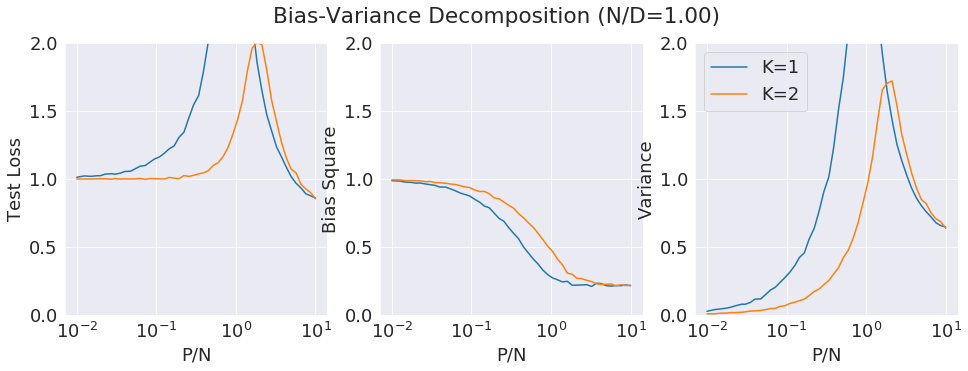

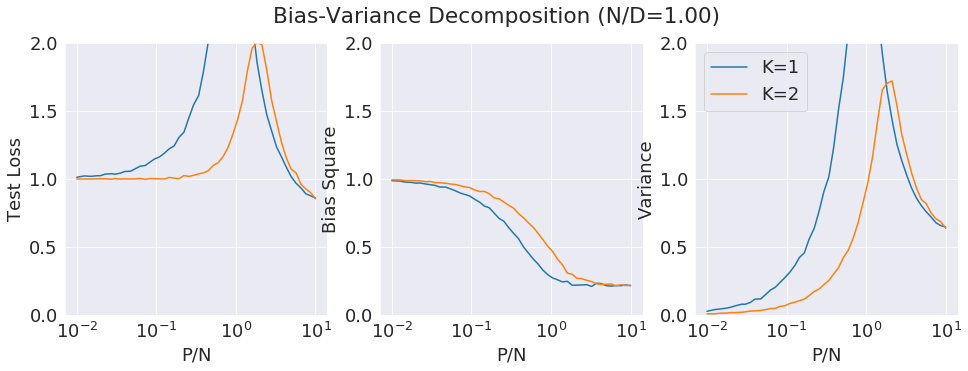

In [7]:
coef = 0.01
outdir = 'synthetic_coef_{}'.format(coef)
if not os.path.exists(outdir):
    os.makedirs(outdir)
run_exps_ridge(train_sizes, N_Ds, P_Ns, beta, test_size, feature_dim, num_classes, num_trials, coef,
         outdir, 'singleNN_output.csv', SNR= SNR, K = 1, F_norm = 1)
run_exps_ridge(train_sizes, N_Ds, P_Ns, beta, test_size, feature_dim, num_classes, num_trials, coef,
             outdir, 'ensembleNNK=2_output.csv', SNR= SNR, K = 2, F_norm = 1)
K2_df = pd.read_csv(os.path.join(outdir, 'ensembleNNK=2_output.csv'))
K1_df = pd.read_csv(os.path.join(outdir, 'singleNN_output.csv'))


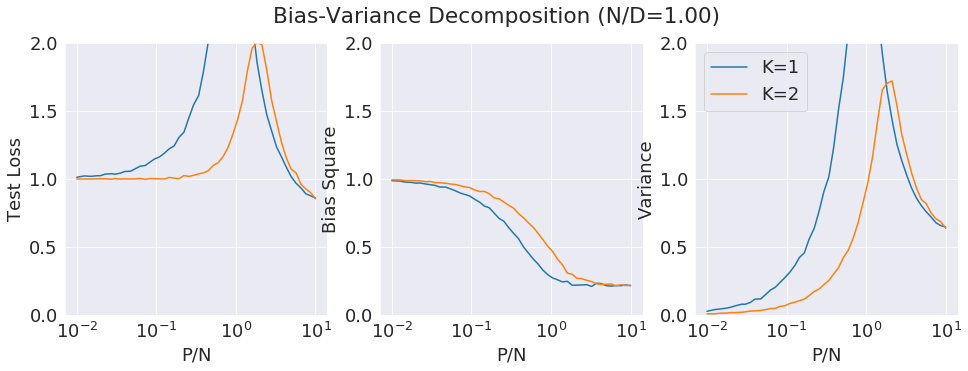

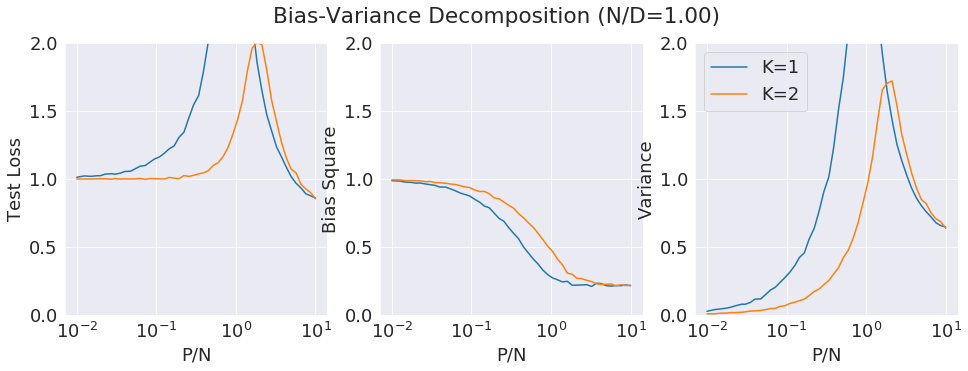

In [8]:
plot_single_vs_ensemble([K1_df, K2_df], [1, 2], N_Ds[0], feature_dim, ymax=2.0)
plot_single_vs_ensemble([K1_df, K2_df], [1, 2], N_Ds[0], feature_dim, ymax=2.0)